<a href="https://colab.research.google.com/github/evelyn0414/FCL_L361_project/blob/main/L361_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Library and downloading dataset

In [ ]:
# The simulation component of flower uses RAY under the hood.
# `pip` could produce some errors. Nothing to worry about.
# The execution has been verified, it's working anyway.
! pip install --quiet --upgrade "pip"
! pip install --quiet 'flwr[simulation]' torch torchvision matplotlib gdown tqdm seaborn
# The following is just needed to show the folder tree
! apt-get install -qq tree

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 31.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.5/90.5 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.4/201.4 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 13.0 MB/s eta 0:00:

In [ ]:
## Imports

import csv
import numbers
import os
import random
from collections import OrderedDict, defaultdict
from copy import deepcopy
from pathlib import Path
from typing import *

import flwr as fl
import gdown
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.common import Metrics
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig
from flwr.server.strategy import FedAvgM as FedAvg
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, Subset
from torch import autograd
import torch.optim as optim
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum
import json


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337

np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False # type: ignore
torch.backends.cudnn.deterministic = True # type: ignore

def start_seeded_simulation(
    client_fn,
    num_clients,
    client_resources,
    config,
    strategy,
    seed: int = Seeds.DEFAULT,
):
    """Wrapper to always seed client selection."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources=client_resources,
        config=config,
        strategy=strategy,
    )

def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf)


PathType = Optional[Union[Path, str]]


def get_device() -> str:
    return str(torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))

**Use FEMNIST**

In [ ]:
home_dir = Path("/content")
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

In [ ]:
#  Download compressed dataset
if not (home_dir / "femnist.tar.gz").exists():
    id = "1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist.tar.gz"),
    )
    
# Decompress dataset 
if not dataset_dir.exists():
  !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
  print(f"Dataset extracted in {dataset_dir}")

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-
To: /content/femnist.tar.gz
100%|██████████| 223M/223M [00:05<00:00, 38.9MB/s]


Dataset extracted in /content/femnist


**Load the FEMNIST dataset object**

In [ ]:
if not (home_dir / "femnist_dataset.py").exists():
    id = "11xG4oIhdbVcDtXxbS2ZosDSJYAC0iL7q"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "femnist_dataset.py"),
    )
if not (home_dir / "client.py").exists():
    id = "11xRc__g3iMOBRiQsPr9mDor5Ile_Pude"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "client.py"),
    )
if not (home_dir / "client_utils.py").exists():
    id = "121UMOA7kg96rrZBe7vwt-2vgc-sTGu-X"
    gdown.download(
        f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
        str(home_dir / "client_utils.py"),
    )

from femnist_dataset import FEMNIST
from client_utils import to_tensor_transform, get_model_parameters, get_federated_evaluation_function, aggregate_weighted_average
from client import FlowerRayClient, get_flower_client_generator

Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=11xG4oIhdbVcDtXxbS2ZosDSJYAC0iL7q
To: /content/femnist_dataset.py
100%|██████████| 4.07k/4.07k [00:00<00:00, 3.67MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=11xRc__g3iMOBRiQsPr9mDor5Ile_Pude
To: /content/client.py
100%|██████████| 9.20k/9.20k [00:00<00:00, 20.5MB/s]
Downloading...
From: https://drive.google.com/uc?export=download&confirm=pbef&id=121UMOA7kg96rrZBe7vwt-2vgc-sTGu-X
To: /content/client_utils.py
100%|██████████| 10.6k/10.6k [00:00<00:00, 21.8MB/s]


# Overcoming-Catastrophic-forgetting-in-Neural-Networks: elastic weight consolidation

In [ ]:
class ElasticWeightConsolidation:

    def __init__(self, model, crit, lr=0.001, weight=1000000):
        self.model = model
        self.weight = weight
        self.crit = crit
        self.optimizer = optim.Adam(self.model.parameters(), lr)

    def _update_mean_params(self):
        for param_name, param in self.model.named_parameters():
            _buff_param_name = param_name.replace('.', '__')
            self.model.register_buffer(_buff_param_name+'_estimated_mean', param.data.clone())

    def _update_fisher_params(self, current_ds, batch_size, num_batch):
        # dl = DataLoader(current_ds, batch_size, shuffle=True)  This line is not needed
        dl = current_ds
        # log_liklihoods = []
        log_liklihoods = 0   # Changed here
        for i, (input, target) in enumerate(dl):
            if i > num_batch:
                break
            output = F.log_softmax(self.model(input), dim=1)
            # log_liklihoods.append(output[:, target])
            log_liklihoods = ((i+1) * log_liklihoods + output[:, target]) / (i+2)  # Changed here
        log_likelihood = torch.cat([log_liklihoods]).mean()  # Changed here
        grad_log_liklihood = autograd.grad(log_likelihood, self.model.parameters(), allow_unused=False)
        _buff_param_names = [param[0].replace('.', '__') for param in self.model.named_parameters()]
        for _buff_param_name, param in zip(_buff_param_names, grad_log_liklihood):
            self.model.register_buffer(_buff_param_name+'_estimated_fisher', param.data.clone() ** 2)

    def register_ewc_params(self, dataset, batch_size, num_batches):
        self._update_fisher_params(dataset, batch_size, num_batches)
        self._update_mean_params()

    def _compute_consolidation_loss(self, weight):
        try:
            losses = []
            for param_name, param in self.model.named_parameters():
                _buff_param_name = param_name.replace('.', '__')
                estimated_mean = getattr(self.model, '{}_estimated_mean'.format(_buff_param_name))
                estimated_fisher = getattr(self.model, '{}_estimated_fisher'.format(_buff_param_name))
                losses.append((estimated_fisher * (param - estimated_mean) ** 2).sum())
            return (weight / 2) * sum(losses)
        except AttributeError:
            return 0

    def forward_backward_update(self, input, target):
        output = self.model(input)
        loss = self._compute_consolidation_loss(self.weight) + self.crit(output, target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss

    def save(self, filename):
        torch.save(self.model, filename)

    def load(self, filename):
        self.model = torch.load(filename)

# (Adaptive) Fuzzy Tiling Activation, Powerpropagation, and Network

In [ ]:
# Permuted-FEMNIST input and output dimensions
# input_dim, output_dim = 784, 10

# # Split-FEMNIST input and output dimensions
input_dim, output_dim = 784, 2

In [ ]:
# FTA Class
class FTA:
    def __init__(self, device, tiles, bound_low, bound_high, eta, input_dim):
        # 1 tiling, binning
        self.n_tilings = 1
        self.n_tiles = tiles
        self.bound_low, self.bound_high = bound_low, bound_high
        self.delta = (self.bound_high - self.bound_low) / self.n_tiles
        self.c_mat = torch.as_tensor(np.array([self.delta * i for i in range(self.n_tiles)]) + self.bound_low, dtype=torch.float32, device=device)
        self.eta = eta
        self.d = input_dim

    def __call__(self, reps):
        temp = reps
        temp = temp.reshape([-1, self.d, 1])
        onehots = 1.0 - self.i_plus_eta(self.sum_relu(self.c_mat, temp))
        out = torch.reshape(torch.reshape(onehots, [-1]), [-1, int(self.d * self.n_tiles * self.n_tilings)])
        # print(torch.min(out).item(), torch.max(out).item(), torch.mean(out).item())
        return out

    def sum_relu(self, c, x):
        out = F.relu(c - x) + F.relu(x - self.delta - c)
        return out

    def i_plus_eta(self, x):
        if self.eta == 0:
            return torch.sign(x)
        out = (x <= self.eta).type(torch.float32) * x + (x > self.eta).type(torch.float32)
        return out



#  Define MLP for FTA
class FCBody(nn.Module):
    def __init__(self, input_dim, hidden_units=(64, 64), activation=F.relu):
        super().__init__()
        dims = (input_dim,) + hidden_units
        self.layers = nn.ModuleList([layer_init_xavier(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
        self.activation = activation
        self.feature_dim = dims[-1]

    def forward(self, x):
        for i, layer in enumerate(self.layers):
            # print(layer(x).min(), layer(x).max())
            if i == len(self.layers) - 1:
              x = layer(x)
            else:
              x = self.activation(layer(x))
        return x


class FTA_FCN(nn.Module):
    def __init__(self, input_units, hidden_units, output_units, fta_params, head_activation='fta'):
        super().__init__()
        body = FCBody(input_units, hidden_units=tuple(hidden_units))
        self.fc_head_fta = layer_init_xavier(nn.Linear(body.feature_dim * fta_params["tiles"], output_units))
        self.fc_head = layer_init_xavier(nn.Linear(body.feature_dim, output_units))
        self.fta_params = fta_params
        self.flatten = nn.Flatten()
        self.relu = nn.ReLU()
        self.body = body
        self.head_activation = head_activation

    def forward(self, x):
        x = self.flatten(x)
        phi = self.body(x)
        # fta
        if self.head_activation == 'fta':
            # Must initialize FTA and get phi.device inside forward because how Flower Ray simulation allocates resources
            fta__ = FTA(phi.device, tiles=self.fta_params["tiles"], bound_low=self.fta_params["bound_low"], bound_high=self.fta_params["bound_high"], eta=self.fta_params["eta"], input_dim=hidden_dims[-1])
            phi = fta__(phi)
            phi = self.fc_head_fta(phi)
        else:
            phi = self.fc_head(self.relu(phi))
        return phi


def layer_init_xavier(layer):
    nn.init.xavier_uniform_(layer.weight)
    nn.init.constant_(layer.bias.data, 0)
    return layer



#  Define CNN for FTA
class FTA_CNN(nn.Module):
    def __init__(self, input_units, output_units, fta_params, head_activation='fta', adaptive=False):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc_head_fta = nn.Linear(84 * fta_params["tiles"], output_units)
        self.fc_head = nn.Linear(84, output_units)
        self.fta_params = fta_params
        self.head_activation = head_activation
        self.adaptive = adaptive
        # This needs to be experimented for adaptive FTA
        self.bounds = np.asarray([0.01, 0.05, 0,1, 0.5, 1.0, 5.0, 10.0, 20.0])
        # self.bounds = np.arange(0, 31, 1.0)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        # fta
        if self.head_activation == 'fta':
          x = self.fc2(x)
          # Must initialize FTA and get x.device inside forward because how Flower Ray simulation allocates resources
          if self.adaptive == True:
            # bound_high_adap = find_nearest(self.bounds, torch.max(x).item(), high=True)
            # bound_low_adap = find_nearest(0 - self.bounds, torch.min(x).item(), high=False)
            bound_high_adap = find_nearest(self.bounds, torch.mean(x).item() + 2 * torch.std(x).item(), high=True)
            bound_low_adap = find_nearest(0 - self.bounds, torch.mean(x).item() - 2 * torch.std(x).item(), high=False)
            eta_adap = (bound_high_adap - bound_low_adap) / self.fta_params["tiles"]
            # print(torch.min(x).item(), torch.max(x).item(), bound_low_adap, bound_high_adap)
            # print(torch.mean(x).item() - 2 * torch.std(x).item(), torch.mean(x).item() + 2 * torch.std(x).item(), bound_low_adap, bound_high_adap)
            # print(eta_adap)
            fta__ = FTA(x.device, tiles=self.fta_params["tiles"], bound_low=bound_low_adap, bound_high=bound_high_adap, eta=eta_adap, input_dim=84)
          else:
            fta__ = FTA(x.device, tiles=self.fta_params["tiles"], bound_low=self.fta_params["bound_low"], bound_high=self.fta_params["bound_high"], eta=self.fta_params["eta"], input_dim=84)
          x = fta__(x)
          x = self.fc_head_fta(x)
        else:
          x = F.relu(self.fc2(x))
          x = self.fc_head(x)
        return x


def find_nearest(array, value, high=True):
  diff = array - value
  if high == True:
    diff[diff < 0] = 1e6
    return array[diff.argmin()]
  else:
    diff[diff > 0] = -1e6
    return array[diff.argmax()]



#-----------------------------------------------------------------------------
# Powerpropagation Class
def calculate_fan_in(tensor: torch.Tensor):
    """Modified from: https://github.com/pytorch/pytorch/blob/master/torch/nn/init.py"""
    dimensions = tensor.dim()
    if dimensions < 2:
        raise ValueError("Fan in can not be computed for tensor with fewer than 2 dimensions")
    num_input_fmaps = tensor.size(1)
    receptive_field_size = 1
    if dimensions > 2:
        for s in tensor.shape[2:]:
            receptive_field_size *= s
    fan_in = num_input_fmaps * receptive_field_size
    return fan_in


def init_weights(module: nn.Module):
    if isinstance(module, (PowerPropLinear, PowerPropConv)):
        fan_in = calculate_fan_in(module.w.data)
        # constant from scipy.stats.truncnorm.std(a=-2, b=2, loc=0., scale=1.)
        distribution_stddev = .87962566103423978
        # std = torch.sqrt(1. / fan_in) / distribution_stddev  This line has bug, fan_in is not tensor
        std = ((1. / fan_in) ** 0.5) / distribution_stddev
        a, b = -2. * std, 2. * std
        u = nn.init.trunc_normal_(module.w.data, std=std, a=a, b=b)
        u = torch.sign(u) * torch.pow(torch.abs(u), 1.0 / module.alpha)
        module.w.data = u
        module.b.data.zero_()


class PowerPropLinear(nn.Module):
    """Powerpropagation Linear module."""
    def __init__(self, alpha, in_features, out_features):
        super(PowerPropLinear, self).__init__()
        self.alpha = alpha
        self.w = torch.nn.Parameter(torch.empty(out_features, in_features))
        self.b = torch.nn.Parameter(torch.empty(out_features))

    def get_weights(self):
        weights = self.w.detach()
        return torch.sign(weights) * torch.pow(torch.abs(weights), self.alpha)

    def forward(self, inputs, mask=None):
        weights = self.w * torch.pow(torch.abs(self.w), self.alpha - 1.)
        if mask is not None:
            weights *= mask
        return F.linear(inputs, weights, self.b)


class PowerPropConv(nn.Module):
    """Powerpropagation Conv2D module."""
    def __init__(self, alpha, in_channels, out_channels, kernel_size=3):
        super(PowerPropConv, self).__init__()
        self.alpha = alpha
        self.w = torch.nn.Parameter(torch.empty(out_channels, in_channels, kernel_size, kernel_size))
        self.b = torch.nn.Parameter(torch.empty(out_channels))

    def get_weights(self):
        weights = self.w.detach()
        return torch.sign(weights) * torch.pow(torch.abs(weights), self.alpha)

    def forward(self, inputs, mask=None):
        weights = self.w * torch.pow(torch.abs(self.w), self.alpha - 1.)
        if mask is not None:
            weights *= mask
        return F.conv2d(inputs, weights, self.b, stride=1, padding=0)



# Define CNN for Powerpropagation
class PP_CNN(nn.Module):
    def __init__(self, input_units, output_units, alpha):
        super(PP_CNN, self).__init__()
        self.conv1 = PowerPropConv(alpha, 1, 6, 5)
        self.conv2 = PowerPropConv(alpha, 6, 16, 5)
        self.fc1 = PowerPropLinear(alpha, 256, 120)
        self.fc2 = PowerPropLinear(alpha, 120, 84)
        self.fc_head = PowerPropLinear(alpha, 84, output_units)

    def get_weights(self):
        return [self.conv1.get_weights(), self.conv2.get_weights(), self.fc1.get_weights(), self.fc2.get_weights(), self.fc_head.get_weights()]

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc_head(x)
        return x



#-----------------------------------------------------------------------------
# # FEMNIST input and output dimensions
# input_dim, output_dim = 784, 62

# MLP dimensions (not used in the below experiments)
hidden_dims = [1000, 500]

# FTA parameters
# bound = [bound_low, bound_high]
# tiling width = (bound_high - bound_low) / tiles
# eta = tiling width, is the minimum value to guarantee nonzero gradient everywhere
fta_params = {}
fta_params["tiles"] = 10
fta_params["bound_low"] = -1
fta_params["bound_high"] = 1
fta_params["eta"] = (fta_params["bound_high"] - fta_params["bound_low"]) / fta_params["tiles"]

# Powerpropagation parameters
alpha = 3.0



#-----------------------------------------------------------------------------
# Initialization of FTA CNN
def get_network_generator_cnn_fta():
    untrained_net: FTA_CNN = FTA_CNN(input_dim, output_dim, fta_params, head_activation='fta')
    def generated_net():
        return deepcopy(untrained_net)
    return generated_net


# Initialization of Adaptive FTA CNN
def get_network_generator_cnn_fta_adap():
    untrained_net: FTA_CNN = FTA_CNN(input_dim, output_dim, fta_params, head_activation='fta', adaptive=True)
    def generated_net():
        return deepcopy(untrained_net)
    return generated_net


# Initialization of Powerpropagatoin CNN
def get_network_generator_cnn_pp():
    untrained_net: PP_CNN = PP_CNN(input_dim, output_dim, alpha)
    untrained_net.apply(init_weights)
    def generated_net():
        return deepcopy(untrained_net)
    return generated_net


# Initialization of normal CNN
def get_network_generator_cnn():
    untrained_net: FTA_CNN = FTA_CNN(input_dim, output_dim, fta_params, head_activation=None)
    def generated_net():
        return deepcopy(untrained_net)
    return generated_net


# Initialization of FTA MLP
def get_network_generator_mlp_fta():
    untrained_net: FTA_FCN = FTA_FCN(input_dim, hidden_dims, output_dim, fta_params, head_activation='fta')
    def generated_net():
        return deepcopy(untrained_net)
    return generated_net


# Initialization of normal MLP
def get_network_generator_mlp():
    untrained_net: FTA_FCN = FTA_FCN(input_dim, hidden_dims, output_dim, fta_params, head_activation=None)
    def generated_net():
        return deepcopy(untrained_net)
    return generated_net

# The effects of sparsity under FL with data heterogeneity



## FEMNIST folder structure



By default, FEMNIST will be split as follows:

- `femnist`: the location of the relevant data
  - `client_data_mappings`: contains different partitions
    - `centralized`: mappings from writer_id -> `[image_path, label]` for the centralized dataset
    - `fed_natural`: mappings from writer_id -> `[image_path, label]` for the naturally federated dataset
  - `data`: contains the macro partitions between test, train, and val
    - `train`: contains the raw images---samples of the train set
    - `test`: contains the raw images---samples of the test set
    - `val`: contains the raw images---samples of the val set
- `femnist.tar.gz`: the compressed dataset

We will store client datasets in sequentially labelled folders within each partition and do all necessary remapping in python.

In [ ]:
# Showing resulting folder tree
! tree -dC -L 3 ./

./
├── femnist
│   ├── client_data_mappings
│   │   ├── centralized
│   │   └── fed_natural
│   └── data
│       ├── test
│       ├── train
│       └── val
└── sample_data

9 directories


## Testing in FL

The testing set we use is the **federated test set**.


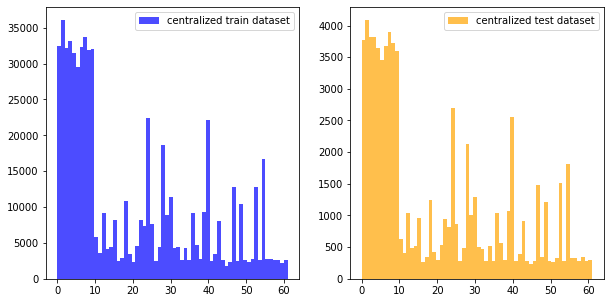

In [ ]:
centralized_train_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition/'0',
    data_dir=data_dir,
    name='train'
    )
centralized_test_dataset: FEMNIST = FEMNIST(
    mapping=centralized_partition/'0',
    data_dir=data_dir,
    name='test'
    )
fig, ax = plt.subplots(1,2,figsize=(10,5))
train_histo = ax[0].hist([int(x[1]) for x in centralized_train_dataset.data], bins=62, color="blue", alpha=0.7, label="centralized train dataset")
test_histo = ax[1].hist([int(x[1]) for x in centralized_test_dataset.data], bins=62, color="orange", alpha=0.7, label="centralized test dataset")
ax[0].legend()
ax[1].legend()

In [ ]:
print(f'The least represented class in the train set has {min(train_histo[0])} samples')
print(f'The least represented class in the test set has {min(test_histo[0])} samples')
max_train_samples = int(min(train_histo[0]))
max_test_samples = int(min(test_histo[0]))

The least represented class in the train set has 1786.0 samples
The least represented class in the test set has 233.0 samples


In [ ]:
!wget https://raw.githubusercontent.com/adap/flower/v1.0.0/baselines/flwr_baselines/dataset/utils/common.py -O lda_utils.py

--2023-03-18 13:15:57--  https://raw.githubusercontent.com/adap/flower/v1.0.0/baselines/flwr_baselines/dataset/utils/common.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17166 (17K) [text/plain]
Saving to: ‘lda_utils.py’

lda_utils.py        100%[===================>]  16.76K  --.-KB/s    in 0s      

2023-03-18 13:15:57 (85.3 MB/s) - ‘lda_utils.py’ saved [17166/17166]



In [ ]:
from lda_utils import create_lda_partitions

In [ ]:
concentration = 2.5 # [0.1, 2.5, 5, 1.0, 99999]
# Create partitions
x = np.array([x[0] for x in centralized_train_dataset.data])
y = np.array([x[1] for x in centralized_train_dataset.data])
train_clients_partitions, dist = create_lda_partitions(
    dataset=(x,y),
    dirichlet_dist=None,
    num_partitions=3229,
    concentration=concentration,
    accept_imbalanced=True,
)
x = np.array([x[0] for x in centralized_test_dataset.data])
y = np.array([x[1] for x in centralized_test_dataset.data])
test_clients_partitions, dist = create_lda_partitions(
    dataset=(x,y),
    dirichlet_dist=dist,
    num_partitions=3229,
    concentration=concentration,
    accept_imbalanced=True,
)

In [ ]:
Ida_path = 'lda' + str(concentration)
lda_partition: Path = dataset_dir / 'client_data_mappings' / Ida_path
lda_partition.mkdir(parents=True, exist_ok=True)

for i, (train_set, test_set) in enumerate(zip(train_clients_partitions, test_clients_partitions)):
  folder_path: Path = lda_partition / str(i)
  folder_path.mkdir(parents=True, exist_ok=True)

  train_path: Path = folder_path / "train.csv"
  test_path: Path = folder_path / "test.csv"

  pd.DataFrame({'client_id': [0]*len(train_set[0]),
              'sample_path': train_set[0],
              'sample_id': range(len(train_set[0])),
              'label': train_set[1]}).to_csv(train_path, index=False)
  pd.DataFrame({'client_id': [0]*len(test_set[0]),
              'sample_path': test_set[0],
              'sample_id': range(len(test_set[0])),
              'label': test_set[1]}).to_csv(test_path, index=False)

In [ ]:
# Select sparsity strategy for the network
network_list = ["FTA_CNN", "FTA_Adap_CNN", "PP_CNN", "CNN", "FTA_MLP", "MLP"]
network = network_list[2]

torch.manual_seed(Seeds.DEFAULT)
if network == "FTA_CNN":
  network_generator_fta = get_network_generator_cnn_fta()
elif network == "FTA_Adap_CNN":
  network_generator_fta = get_network_generator_cnn_fta_adap()
elif network == "PP_CNN":
  network_generator_fta = get_network_generator_cnn_pp()
elif network == "CNN":
  torch.manual_seed(Seeds.DEFAULT)
  network_generator_fta = get_network_generator_cnn()
elif network == "FTA_MLP":
  network_generator_fta = get_network_generator_mlp_fta()
elif network == "MLP":
  network_generator_fta = get_network_generator_mlp()

seed_net_fta = network_generator_fta()
seed_model_fta_params: NDArrays = get_model_parameters(seed_net_fta)

In [ ]:
# NOTE: the functions in this cell will be used as they are for the rest of the notebook
test_config: Dict[str, Any] = {
    "batch_size": 64,
    "num_workers": 2,
}

federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_fta,
    criterion=nn.CrossEntropyLoss(),
)

In [ ]:
# NOTE: these parameters will have the same value for the rest of the notebook
on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: test_config
accept_failures = False
server_learning_rate = 1.0
min_fit_clients = 2
min_evaluate_clients = 0
min_available_clients = 2
initial_parameters: Parameters = ndarrays_to_parameters(seed_model_fta_params)
client_resources = {
    "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0, # maximum amount of resources that a client can take
}

In [ ]:
# Create client generators for both LDA partition and natural partition
# lda_flower_client_generator: Callable[
#     [int], FlowerRayClient
# ] = get_flower_client_generator(network_generator_fta, data_dir, lda_partition) # type: ignore

federated_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_flower_client_generator(network_generator_fta, data_dir, federated_partition) # type: ignore

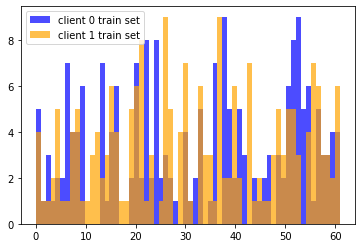

In [ ]:
# Visualization of the LDA heterogeneous partitions
plt.hist([int(x[1]) for x in lda_flower_client_generator(0)._load_dataset('train').data], bins=62, color="blue", alpha=0.7, label="client 0 train set")
plt.hist([int(x[1]) for x in lda_flower_client_generator(1)._load_dataset('train').data], bins=62, color="orange", alpha=0.7, label="client 1 train set")
plt.legend()

In [ ]:
train_config: Dict[str, Any] = {
    "epochs": 10,
    "batch_size": 16,
    "client_learning_rate": 0.0005, # For FTA, important to have a small learning rate (e.g. 5e-4 instead of 1e-2)
    "weight_decay": 0.001,
    "num_workers": 2,
}

on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config

num_total_clients = 3229
num_clients_per_round: int = 5
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

strategy = FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=on_fit_config_fn,
    on_evaluate_config_fn=on_evaluate_config_fn,
    evaluate_fn=federated_evaluation_function,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    server_learning_rate=server_learning_rate,
)

In [ ]:
def save_hist_object(filename, hist):
  with open(filename, 'w', encoding='utf-8') as f:
      json.dump(hist.metrics_centralized, f, ensure_ascii=False, indent=4)

In [ ]:
# fta_cnn
hist_fed_fta = fl.simulation.start_simulation(
    client_fn=federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=30),
    strategy=strategy,
)

save_hist_object('hist_fed_fta.json', hist_fed_fta)

In [ ]:
# fta_adaptive_cnn
hist_fed_fta_adap = fl.simulation.start_simulation(
    client_fn=federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=30),
    strategy=strategy,
)

save_hist_object('hist_fed_fta_adap.json', hist_fed_fta_adap)

In [ ]:
# powerpropagation cnn
hist_fed_pp = fl.simulation.start_simulation(
    client_fn=federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=30),
    strategy=strategy,
)

save_hist_object('hist_fed_pp.json', hist_fed_pp)

In [ ]:
# normal cnn
hist_fed_none = fl.simulation.start_simulation(
    client_fn=federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=30),
    strategy=strategy,
)

save_hist_object('hist_fed_none.json', hist_fed_none)

In [ ]:
def load_hist_object(filenames: str):
  f = open(filenames)
  return json.load(f)

def plot_hist(hist_fta: Any, hist_fta_adap: Any, hist_pp: Any, hist_none: Any, title: str) -> None:
  if not isinstance(hist_fta, Dict): 
    hist_fta = hist_fta.metrics_centralized['accuracy']
  else:
    hist_fta = hist_fta['accuracy']
  if not isinstance(hist_fta_adap, Dict): 
    hist_fta_adap = hist_fta_adap.metrics_centralized['accuracy']
  else:
    hist_fta_adap = hist_fta_adap['accuracy']
  if not isinstance(hist_pp, Dict): 
    hist_pp = hist_pp.metrics_centralized['accuracy']
  else:
    hist_pp = hist_pp['accuracy']
  if not isinstance(hist_none, Dict): 
    hist_none = hist_none.metrics_centralized['accuracy']
  else:
    hist_none = hist_none['accuracy']
  
  rounds = list(zip(*hist_fta))[0][1:]
  hist_fta_acc = np.asarray(list(zip(*hist_fta))[1][1:]) * 100
  hist_fta_adap_acc = np.asarray(list(zip(*hist_fta_adap))[1][1:]) * 100
  hist_pp_acc = np.asarray(list(zip(*hist_pp))[1][1:]) * 100
  hist_none_acc = np.asarray(list(zip(*hist_none))[1][1:]) * 100
 
  fig, ax = plt.subplots(figsize=(12, 6))
  plt.plot(rounds, hist_fta_acc, label = "FTA")
  plt.plot(rounds, hist_fta_adap_acc, label = "Adaptive FTA")
  plt.plot(rounds, hist_pp_acc, label = "Powerpropagation")
  plt.plot(rounds, hist_none_acc, label = "Without FTA")
  plt.legend()
  for index in range(len(rounds)):
    ax.text(rounds[index], round(hist_fta_acc[index], 2), round(hist_fta_acc[index], 2))
    ax.text(rounds[index], round(hist_fta_adap_acc[index], 2), round(hist_fta_adap_acc[index], 2))
    ax.text(rounds[index], round(hist_pp_acc[index], 2), round(hist_pp_acc[index], 2))
    ax.text(rounds[index], round(hist_none_acc[index], 2), round(hist_none_acc[index], 2))
  plt.title(title)
  plt.xlabel('Round')
  plt.ylabel('Accuracy')
  plt.show()

In [ ]:
hist_fed_fta, hist_fed_fta_adap, hist_fed_pp, hist_fed_none = load_hist_object('hist_fed_fta.json'), load_hist_object('hist_fed_fta_adap.json'), load_hist_object('hist_fed_pp.json'), load_hist_object('hist_fed_none.json')
plot_hist(hist_fta=hist_fed_fta, hist_fta_adap=hist_fed_fta_adap, hist_pp=hist_fed_pp, hist_none=hist_fed_none, title="Accuracy vs. Round with Federated Partition using CNN")

# Federated Continual Learning Set-up

## PermutedFEMNIST

### Permuting (archived, this version of implementation is too time consuming)

In [ ]:
# from google.colab import files
# ## Mount Google drive
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# home_dir = Path("/content/drive/MyDrive/L361")
# dataset_dir: Path = home_dir / "femnist"
# data_dir: Path = dataset_dir / "data"
# centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
# centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
# federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

In [ ]:
# #  Download compressed dataset
# if not (home_dir / "femnist.tar.gz").exists():
#     id = "1-CI6-QoEmGiInV23-n_l6Yd8QGWerw8-"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "femnist.tar.gz"),
#     )
    
# # Decompress dataset 
# if not dataset_dir.exists():
#   !tar -xf {str(home_dir)}/femnist.tar.gz -C {str(home_dir)} 2> /dev/null
#   print(f"Dataset extracted in {dataset_dir}")

# if not (home_dir / "femnist_dataset.py").exists():
#     id = "11xG4oIhdbVcDtXxbS2ZosDSJYAC0iL7q"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "femnist_dataset.py"),
#     )
# if not (home_dir / "client.py").exists():
#     id = "11xRc__g3iMOBRiQsPr9mDor5Ile_Pude"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "client.py"),
#     )
# if not (home_dir / "client_utils.py").exists():
#     id = "121UMOA7kg96rrZBe7vwt-2vgc-sTGu-X"
#     gdown.download(
#         f"https://drive.google.com/uc?export=download&confirm=pbef&id={id}",
#         str(home_dir / "client_utils.py"),
#     )

# from femnist_dataset import FEMNIST
# from client_utils import to_tensor_transform, get_model_parameters, get_federated_evaluation_function, aggregate_weighted_average
# from client import FlowerRayClient, get_flower_client_generator

In [ ]:
!zip -r /content/femnist.zip /content/femnist

In [ ]:
files.download("/content/femnist.zip")

In [ ]:
import glob as gb
import torchvision.transforms as transforms
from torchvision.io import read_image, write_png
names = ["test", "train", "val"]

permute_idx = list(range(28 * 28))

for task_idx in range(1,2):
  print(task_idx)
  Permuted_path = 'task' + str(task_idx)
  Permuted_data: Path = data_dir / Permuted_path
  Permuted_data.mkdir(parents=True, exist_ok=True)

  random.shuffle(permute_idx)
  for name in names[:1]:
      print(name)
      Permuted_data_name: Path = Permuted_data / name
      Permuted_data_name.mkdir(parents=True, exist_ok=True)
      image_dir_loc = np.array(gb.glob("/content/femnist/data/" + name + "/*.png")) # drive/MyDrive/L361
      for i in range(image_dir_loc.shape[0]):
          filename = image_dir_loc[i]
          fileID = filename.split('/')[-1]
          # print(fileID)
          img: ImageType = Image.open(filename).convert("L")
          print(img)
          transform = transforms.Compose([transforms.PILToTensor()])

          tensor = transform(img)
          print(tensor)
          img = tensor.view(-1)[permute_idx]
          img = img.reshape(1, 28, 28)
          print(img)
          transform = transforms.Compose([transforms.ToPILImage()])

          img = transform(img)
          # img : ImageType = transforms.ToPILImage(img)
          print(img)
          # img = read_image(filename)
          # if task_idx > 0:
              # img = img.view(-1)[permute_idx]
              # img = img.reshape(1, 28, 28)
          # save_dir = "/content/drive/MyDrive/L361/femnist/data/task{}/{}/{}".format(task_idx, name, fileID)
          # write_png(img, save_dir)
          break

1
test
<PIL.Image.Image image mode=L size=28x28 at 0x7F651C6DB700>
tensor([[[255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
          255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
          255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
          255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
          255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255,
          255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255],
         [255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 255, 254,
          255, 255, 255, 255, 255, 255, 255, 255

### pre-processing

In [ ]:
home_dir = Path("/content")
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

permuted_partition = dataset_dir / 'client_data_mappings' / "permuted"
permuted_centralized_mapping = dataset_dir / 'client_data_mappings' / "permuted_centralized" / '0'

In [ ]:
# centralized_mapping

for name in ["train", "test", "val"]:
    filename = name + ".csv"
    partition = pd.read_csv(centralized_mapping / filename)

    filter_labels = [i for i in range(10)]

    folder_path = permuted_centralized_mapping
    folder_path.mkdir(parents=True, exist_ok=True)

    filtered = partition[partition["label"].isin(filter_labels)]

    dir_path: Path = folder_path / filename
    filtered.to_csv(dir_path, index=False)


In [ ]:
import pandas as pd
from tqdm import tqdm

def filter_10class(original_partition):
  for client in tqdm(range(3229)):
      fed_par_dir : Path = original_partition / str(client)
      partition_train = pd.read_csv(fed_par_dir /  "train.csv")
      partition_test = pd.read_csv(fed_par_dir /  "train.csv")

      filter_labels = [i for i in range(10)]
      folder_path = permuted_partition /  str(client)
      folder_path.mkdir(parents=True, exist_ok=True)

      filter_train = partition_train[partition_train["label"].isin(filter_labels)]
      filter_test = partition_test[partition_test["label"].isin(filter_labels)]


      train_path: Path = folder_path / "train.csv"
      test_path: Path = folder_path / "test.csv"

      filter_train.to_csv(train_path, index=False)
      filter_test.to_csv(test_path, index=False)

filter_10class(federated_partition)

100%|██████████| 3229/3229 [00:22<00:00, 146.23it/s]


### Modifications from the previous version of implementation

`femnist_dataset.py`
* fixed_permute_idxs
* PermutedFEMNIST class with given permute_idx


`client_utils.py`
* load_PermutedFEMNIST_dataset() function
* get_permuted_evaluation_function() to adjust to average of all seen tasks, with fed_eval_config["n_task"] to control by server.


`client.py`
* PermutedFlowerRayClient class
  * _load_dataset()
  * _create_data_loader()
  * (maybe evaluate() ? )
* get_permuted_client_generator

In [ ]:
fixed_permute_idxs = [None]
random.seed(0)
permute_idx = list(range(28 * 28))
for i in range(9):
    # print(permute_idx)
    random.shuffle(permute_idx)
    fixed_permute_idxs.append(list(permute_idx))
print(fixed_permute_idxs)
TASK_NUM = 5
ROUND_PER_TASK = 10

[None, [72, 660, 757, 548, 56, 696, 665, 214, 546, 698, 34, 236, 274, 567, 211, 67, 52, 396, 532, 464, 96, 87, 570, 89, 385, 386, 766, 728, 57, 45, 738, 301, 390, 479, 417, 278, 139, 102, 314, 151, 217, 344, 69, 205, 634, 304, 283, 579, 35, 263, 669, 772, 54, 447, 313, 302, 167, 276, 578, 391, 770, 513, 94, 549, 272, 559, 30, 303, 688, 600, 413, 92, 484, 361, 712, 480, 337, 618, 762, 495, 286, 426, 345, 81, 445, 459, 402, 474, 750, 356, 176, 777, 551, 273, 180, 619, 368, 398, 160, 470, 644, 683, 485, 519, 136, 664, 152, 771, 598, 527, 782, 384, 661, 295, 607, 147, 306, 372, 440, 232, 331, 104, 702, 431, 554, 622, 382, 410, 137, 233, 181, 511, 469, 489, 724, 781, 765, 141, 510, 339, 114, 291, 316, 462, 237, 651, 420, 210, 746, 108, 144, 109, 624, 29, 78, 129, 107, 260, 128, 615, 353, 406, 146, 719, 463, 6, 539, 124, 638, 499, 393, 486, 415, 116, 574, 736, 378, 602, 238, 48, 473, 503, 623, 652, 99, 251, 307, 159, 182, 315, 577, 230, 86, 692, 416, 648, 745, 609, 778, 28, 261, 219, 673, 20

In [ ]:
def train_FEMNIST_ewc(
    net: Module,
    train_loader: DataLoader,
    epochs: int,
    device: str,
    optimizer: torch.optim.Optimizer,
    criterion: Module,
) -> float:
    """Trains the network on the training set.

    Args:
        net (Module): generic module object describing the network to train.
        train_loader (DataLoader): dataloader to iterate during the training.
        epochs (int): number of epochs of training.
        device (str): device name onto which perform the computation.
        optimizer (torch.optim.Optimizer): optimizer object.
        criterion (Module): generic module describing the loss function.

    Returns:
        float: the final epoch mean train loss.
    """
    net.train()
    running_loss, total = 0.0, 0

    ewc = ElasticWeightConsolidation(net, crit=torch.nn.CrossEntropyLoss(), lr=5e-4)
    for _ in range(epochs):
        running_loss = 0.0
        total = 0
        batches_for_epoch = 0
        for data, labels in train_loader:
            batches_for_epoch += 1
            data, labels = data.to(device), labels.to(device)
            loss = ewc.forward_backward_update(data, labels)
            running_loss += loss.item()
            total += labels.size(0)
    print("EWC loss: ", running_loss / total)
    # ewc.register_ewc_params(train_loader, total // batches_for_epoch, batches_for_epoch)
    return running_loss / total

In [ ]:
def train_FEMNIST_kd(
    net: Module,
    train_loader: DataLoader,
    epochs: int,
    device: str,
    optimizer: torch.optim.Optimizer,
    criterion: Module,
) -> float:
    """Trains the network on the training set.

    Args:
        net (Module): generic module object describing the network to train.
        train_loader (DataLoader): dataloader to iterate during the training.
        epochs (int): number of epochs of training.
        device (str): device name onto which perform the computation.
        optimizer (torch.optim.Optimizer): optimizer object.
        criterion (Module): generic module describing the loss function.

    Returns:
        float: the final epoch mean train loss.
    """
    teacher_net: Module = deepcopy(net)
    teacher_net.requires_grad_(False)
    net.train()
    running_loss, total = 0.0, 0

    alpha = 0.6
    T = 1.0   # Temperature of kl divergence
    kl_loss = nn.KLDivLoss(reduction="batchmean")
    softmax = nn.Softmax(dim=1)
    for _ in range(epochs):
        running_loss = 0.0
        total = 0
        batches_for_epoch = 0
        for data, labels in train_loader:
            batches_for_epoch += 1
            data, labels = data.to(device), labels.to(device)
            optimizer.zero_grad()
            # NOTE: here comes the implementation of FedKL algorithm
            loss = (1-alpha) * criterion(net(data), labels) + alpha * kl_loss(softmax(net(data) / T), softmax(teacher_net(data) / T))         
            running_loss += loss.item()
            total += labels.size(0)
            loss.backward()
            optimizer.step()
    
    print("KLloss: ", running_loss / total)
    return running_loss / total

In [ ]:
# femnist_dataset.py
from femnist_dataset import FEMNIST
import torchvision.transforms as transforms

class PermutedFEMNIST(FEMNIST):
    def __init__(self,
        mapping: Path,
        data_dir: Path,
        name: str = 'train',
        transform: Optional[Callable[[ImageType], Any]] = None,
        target_transform: Optional[Callable[[int], Any]] = None,
        permute_idx=None
    ):
        super(PermutedFEMNIST, self).__init__(mapping, data_dir, name, transform, target_transform)
        assert permute_idx is None or len(permute_idx) == 28 * 28
        self.permute_idx = permute_idx
        self.tensor_transform = transforms.Compose([transforms.PILToTensor()])
        self.image_transform = transforms.Compose([transforms.ToPILImage()])
    
    def __getitem__(self, index) -> Tuple[Any, Any]:
        """Function used by PyTorch to get a sample.

        Args:
            index (_type_): index of the sample.

        Returns:
            Tuple[Any, Any]: couple (sample, label).
        """
        sample_path, label = self.data[index]

        # Convert to the full path
        full_sample_path: Path = self.data_dir / self.name / sample_path

        img: ImageType = Image.open(full_sample_path).convert("L")
        if self.permute_idx is not None:
            # Permutation
            tensor = self.tensor_transform(img)
            img = tensor.view(-1)[self.permute_idx]
            img = img.reshape(1, 28, 28)
            img = self.image_transform(img)

        if self.transform is not None:
            img = self.transform(img)

        if self.target_transform is not None:
            label = self.target_transform(label)

        return img, label

In [ ]:
from client_utils import *

def load_PermutedFEMNIST_dataset(data_dir: Path, mapping: Path, name: str, permute_idx) -> Dataset:
    """Function to load the FEMNIST dataset given the mapping .csv file.
    The relevant transforms are automatically applied.

    Args:
        data_dir (Path): path to the dataset folder.
        mapping (Path): path to the mapping .csv file chosen.
        name (str): name of the dataset to load, train or test.

    Returns:
        Dataset: FEMNIST dataset object, ready-to-use.
    """
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
        ]
    )

    return PermutedFEMNIST(
        mapping=mapping,
        name=name,
        data_dir=data_dir,
        transform=transform,
        target_transform=to_tensor_transform,
        permute_idx=permute_idx
    )

def get_permuted_evaluation_function(
    data_dir: Path,
    centralized_mapping: Path,
    device: str,
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
) -> Callable[[int, NDArrays, Dict[str, Any]], Tuple[float, Dict[str, Scalar]]]:
    """Wrapper function for the external federated evaluation function.
    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Args:
        data_dir (Path): path to the dataset folder.
        centralized_mapping (Path): path to the mapping .csv file chosen.
        device (str):  device name onto which perform the computation.
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the model.

    Returns:
        Callable[[int, NDArrays, Dict[str, Any]], Tuple[float, Dict[str, Scalar]]]: external federated evaluation function.
    """

    full_file: Path = permuted_centralized_mapping
    datasets = [load_PermutedFEMNIST_dataset(data_dir, full_file, "val", permute_idx=fixed_permute_idxs[i]) for i in range(10)]

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: Dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> Tuple[float, Dict[str, Scalar]]:
        """Evaluation function external to the federation.
        It uses the centralized val set for sake of simplicity.

        Args:
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (Dict[str, Any]): mandatory argument in Flower, can contain some configuration info

        Returns:
            Tuple[float, Dict[str, Scalar]]: evaluation results
        """
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        losses, accs = [], []
        # print(fed_eval_config)
        # n_task = ((server_round - 1) // 10) % 5 + 1
        # n_task = 5 if "n_task" not in fed_eval_config else fed_eval_config["n_task"]
        task_num = TASK_NUM
        task_id = ((server_round - 1) // ROUND_PER_TASK) % task_num
        n_task = task_id + 1
        
        for dataset in datasets[:n_task]:
            valid_loader = DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=num_workers,
                drop_last=False,
            )
            
            loss, acc = test_FEMNIST(
                net=net,
                test_loader=valid_loader,
                device=device,
                criterion=criterion,
            )
            losses.append(loss)
            accs.append(acc)
        print(server_round, accs)
        return np.mean(losses), {"mean_accuracy": np.mean(accs), "all_loss": losses, "all_acc":accs}

    return federated_evaluation_function

In [ ]:
# client.py
from client import *

class PermutedFlowerRayClient(FlowerRayClient):
    def __init__(
        self,
        cid: int,
        data_dir: Path,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        super(PermutedFlowerRayClient, self).__init__(cid, data_dir, partition_dir, model_generator)

    def _create_data_loader(self, config: Dict[str, Scalar], name: str) -> DataLoader:
        """Creates the data loader using the specified config parameters

        Args:
            config (Dict[str, Scalar]): Dictionary containing dataloader and dataset parameters
            mode (str): Load the training or testing set for the client

        Returns:
            DataLoader: A pytorch dataloader iterable for training/testing
        """
        # print(config["task"])
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name, config["permute_idx"])

        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name, permute_idx) -> Dataset:
        full_file: Path = permuted_partition / str(self.cid)
        return load_PermutedFEMNIST_dataset(
            data_dir=self.data_dir, mapping=full_file, name=name, permute_idx=permute_idx
        )
    
    def _train(
        self, net: Module, train_loader: DataLoader, config: Dict[str, Scalar]
    ) -> float:

        # Change here for different CL techniques 
        # train_FEMNIST
        # train_FEMNIST_kd
        # train_FEMNIST_ewc
        return train_FEMNIST_kd(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
        )

    def _test(
        self, net, test_loader: DataLoader, config: Dict[str, Scalar]
    ) -> Tuple[float, float]:
        return test_FEMNIST(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
        )

def get_permuted_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Optional[Callable[[int], int]] = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns:
            FlowerRayClient: client instance.
        """
        return PermutedFlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

### Experiments

* get_permuted_fit_config_fn() to send the permute_idx to clients in each round
* get_permuted_eval_config_fn() to determine number of tasks to be averaged in each round

#### configs

In [ ]:
# Select sparsity strategy for the network
network_list = ["FTA_CNN", "FTA_Adap_CNN", "PP_CNN", "CNN", "FTA_MLP", "MLP"]
network = network_list[3]

torch.manual_seed(Seeds.DEFAULT)
if network == "FTA_CNN":
  network_generator_fta = get_network_generator_cnn_fta()
elif network == "FTA_Adap_CNN":
  network_generator_fta = get_network_generator_cnn_fta_adap()
elif network == "PP_CNN":
  network_generator_fta = get_network_generator_cnn_pp()
elif network == "CNN":
  torch.manual_seed(Seeds.DEFAULT)
  network_generator_fta = get_network_generator_cnn()
elif network == "FTA_MLP":
  network_generator_fta = get_network_generator_mlp_fta()
elif network == "MLP":
  network_generator_fta = get_network_generator_mlp()

seed_net_fta = network_generator_fta()
seed_model_fta_params: NDArrays = get_model_parameters(seed_net_fta)

In [ ]:
# Create client generators for both LDA partition and natural partition
# lda_flower_client_generator: Callable[
#     [int], FlowerRayClient
# ] = get_permuted_client_generator(network_generator_fta, data_dir, lda_partition) # type: ignore

permuted_federated_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_permuted_client_generator(network_generator_fta, data_dir, federated_partition) # type: ignore

In [ ]:
# def get_permuted_fit_config_fn() -> Callable[[int], Dict[str, str]]:
#     """Return a function which returns training configurations."""


def permuted_fit_config(server_round: int) -> Dict[str, str]:
    """Return a configuration with static batch size and (local) epochs."""
    task_id = ((server_round - 1) // ROUND_PER_TASK) % TASK_NUM
    config = {
        "epochs": 10,
        "batch_size": 16,
        "client_learning_rate": 0.0005, # For FTA, important to have a small learning rate (e.g. 5e-4 instead of 1e-2)
        "weight_decay": 0.001,
        "num_workers": 2,
        "task": task_id,
        "permute_idx": fixed_permute_idxs[task_id]
    }
    return config

    # return fit_config

# def get_permuted_eval_config_fn() -> Callable[[int], Dict[str, str]]:
#     """Return a function which returns training configurations."""

def permuted_eval_config(server_round: int) -> Dict[str, str]:
    """Return a configuration with static batch size and (local) epochs."""
    task_id = ((server_round - 1) // ROUND_PER_TASK) % TASK_NUM
    config = {
        "batch_size": 64,
        "num_workers": 2,
        "n_task": task_id + 1
    }
    return config

    # return eval_config

In [ ]:
num_total_clients = 3229
num_clients_per_round: int = 5
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

accept_failures = False
server_learning_rate = 1.0
min_fit_clients = 2
min_evaluate_clients = 0
min_available_clients = 2
initial_parameters: Parameters = ndarrays_to_parameters(seed_model_fta_params)
client_resources = {
    "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0, # maximum amount of resources that a client can take
}

test_config: Dict[str, Any] = {
    "batch_size": 64,
    "num_workers": 2,
}

permuted_evaluation_function = get_permuted_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_fta,
    criterion=nn.CrossEntropyLoss()
)

permuted_strategy = FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=permuted_fit_config, # this line is different
    on_evaluate_config_fn=permuted_eval_config, # this line is different
    evaluate_fn=permuted_evaluation_function, # this line is different
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    server_learning_rate=server_learning_rate,
)

In [ ]:
def save_hist_object(filename, hist):
  with open(filename, 'w', encoding='utf-8') as f:
      json.dump(hist.metrics_centralized, f, ensure_ascii=False, indent=4)

def load_hist_object(filenames: str):
  f = open(filenames)
  return json.load(f)

In [ ]:
def plot_CL_hist(hist, title, num_task=5) -> None:
  if not isinstance(hist, Dict): 
    accs = hist.metrics_centralized['all_acc']
    mean_accuracy = hist.metrics_centralized['mean_accuracy']
  else:
    accs = hist['all_acc']
    mean_accuracy = hist['mean_accuracy']

  rounds = list(zip(*mean_accuracy))[0][1:]
  task_acc = [[] for i in range(num_task)]
  mean_acc = []
  for rd, acc_list in accs[1:]:
      for i, val in enumerate(acc_list):
          task_acc[i].append((rd, val))
      mean_acc.append((rd, np.mean(acc_list)))
  hist_mean_acc = np.asarray(list(zip(*mean_acc))[1]) * 100
  print("avg acc of last three rounds", round(np.mean(hist_mean_acc[-3:]) , 2), hist_mean_acc[-3:])
  
  fig, ax = plt.subplots(2, 1, figsize=(14, 8))
  # plt.tight_layout()
  ax[0].plot(rounds, hist_mean_acc, label = "mean accuracy of seen tasks")
  for index in range(0, len(rounds) - 3, 2):
    ax[0].text(rounds[index], round(hist_mean_acc[index], 2), round(hist_mean_acc[index], 2))
  for index in range(len(rounds) - 3, len(rounds), 1):
    ax[0].text(rounds[index], round(hist_mean_acc[index], 2), round(hist_mean_acc[index], 2))
  ax[0].legend()
  ax[0].set_title(title)
  # ax[0].set_xlabel('Round')
  # ax[0].set_ylabel('Accuracy')

  for i, acc_list in enumerate(task_acc):
      # print(acc_list)
      rounds = list(zip(*acc_list))[0][1:]
      hist_acc = np.asarray(list(zip(*acc_list))[1][1:]) * 100
      ax[1].plot(rounds, hist_acc, label = "task_{}".format(i))
      max_index = np.argmax(hist_acc)
      # task max accuracy
      ax[1].text(rounds[max_index], round(hist_acc[max_index], 2), round(hist_acc[max_index], 2))
      # task last round accuracy
      ax[1].text(rounds[len(hist_acc)-1], round(hist_acc[len(hist_acc)-1], 2), round(hist_acc[len(hist_acc)-1], 2))
      print("task {} max accuracy {} final accuracy {} forgetting {}".format(i, round(hist_acc[max_index], 2), round(hist_acc[len(hist_acc)-1], 2), round(hist_acc[max_index], 2) - round(hist_acc[len(hist_acc)-1], 2)))
  ax[1].legend()
  ax[1].set_title("Per Task " + title)
  # ax[1].set_xlabel('Round')
  # ax[1].set_ylabel('Accuracy')
  plt.show()

#### 10-Task 62-class example for illustrating the forgetting

In [ ]:
permuted_hist_fed_none = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=100),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_none.json', permuted_hist_fed_none)

INFO flwr 2023-03-17 22:02:37,073 | app.py:145 | Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
INFO:flwr:Starting Flower simulation, config: ServerConfig(num_rounds=100, round_timeout=None)
2023-03-17 22:02:43,080	INFO worker.py:1529 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8266 
INFO flwr 2023-03-17 22:02:45,614 | app.py:179 | Flower VCE: Ray initialized with resources: {'object_store_memory': 3969567129.0, 'CPU': 2.0, 'memory': 7939134260.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO:flwr:Flower VCE: Ray initialized with resources: {'object_store_memory': 3969567129.0, 'CPU': 2.0, 'memory': 7939134260.0, 'node:172.28.0.12': 1.0, 'GPU': 1.0}
INFO flwr 2023-03-17 22:02:45,650 | server.py:86 | Initializing global parameters
INFO:flwr:Initializing global parameters
INFO flwr 2023-03-17 22:02:45,657 | server.py:266 | Using initial parameters provided by strategy
INFO:flwr:Using initial parameters provided by strategy
INFO flwr 

0 [0.005892669238863556, 0.004665029814100316, 0.00459487898982813, 0.004524728165555945, 0.0043844265170115745, 0.004665029814100316, 0.0043142756927393895, 0.004665029814100316, 0.00459487898982813, 0.004910557699052964]
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0


DEBUG flwr 2023-03-17 22:05:52,468 | server.py:229 | fit_round 1 received 5 results and 0 failures
DEBUG:flwr:fit_round 1 received 5 results and 0 failures
100%|██████████| 446/446 [00:13<00:00, 33.71it/s]
INFO flwr 2023-03-17 22:06:05,728 | server.py:116 | fit progress: (1, 1569.3549318313599, {'mean_accuracy': 0.08372500876885304, 'all_loss': [1569.3549318313599], 'all_acc': [0.08372500876885304]}, 24.460527577999983)
INFO:flwr:fit progress: (1, 1569.3549318313599, {'mean_accuracy': 0.08372500876885304, 'all_loss': [1569.3549318313599], 'all_acc': [0.08372500876885304]}, 24.460527577999983)
INFO flwr 2023-03-17 22:06:05,731 | server.py:163 | evaluate_round 1: no clients selected, cancel
INFO:flwr:evaluate_round 1: no clients selected, cancel
DEBUG flwr 2023-03-17 22:06:05,733 | server.py:215 | fit_round 2: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 2: strategy sampled 5 clients (out of 3229)


1 [0.08372500876885304]
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21616) 0


DEBUG flwr 2023-03-17 22:06:15,351 | server.py:229 | fit_round 2 received 5 results and 0 failures
DEBUG:flwr:fit_round 2 received 5 results and 0 failures
100%|██████████| 446/446 [00:14<00:00, 31.76it/s]
INFO flwr 2023-03-17 22:06:29,423 | server.py:116 | fit progress: (2, 1613.5933291912079, {'mean_accuracy': 0.07986671343388285, 'all_loss': [1613.5933291912079], 'all_acc': [0.07986671343388285]}, 48.15568884200002)
INFO:flwr:fit progress: (2, 1613.5933291912079, {'mean_accuracy': 0.07986671343388285, 'all_loss': [1613.5933291912079], 'all_acc': [0.07986671343388285]}, 48.15568884200002)
INFO flwr 2023-03-17 22:06:29,428 | server.py:163 | evaluate_round 2: no clients selected, cancel
INFO:flwr:evaluate_round 2: no clients selected, cancel
DEBUG flwr 2023-03-17 22:06:29,432 | server.py:215 | fit_round 3: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 3: strategy sampled 5 clients (out of 3229)


2 [0.07986671343388285]
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0


DEBUG flwr 2023-03-17 22:06:39,159 | server.py:229 | fit_round 3 received 5 results and 0 failures
DEBUG:flwr:fit_round 3 received 5 results and 0 failures
100%|██████████| 446/446 [00:14<00:00, 31.75it/s]
INFO flwr 2023-03-17 22:06:53,237 | server.py:116 | fit progress: (3, 1668.641782283783, {'mean_accuracy': 0.0051560855840056125, 'all_loss': [1668.641782283783], 'all_acc': [0.0051560855840056125]}, 71.96953362799968)
INFO:flwr:fit progress: (3, 1668.641782283783, {'mean_accuracy': 0.0051560855840056125, 'all_loss': [1668.641782283783], 'all_acc': [0.0051560855840056125]}, 71.96953362799968)
INFO flwr 2023-03-17 22:06:53,242 | server.py:163 | evaluate_round 3: no clients selected, cancel
INFO:flwr:evaluate_round 3: no clients selected, cancel
DEBUG flwr 2023-03-17 22:06:53,248 | server.py:215 | fit_round 4: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 4: strategy sampled 5 clients (out of 3229)


3 [0.0051560855840056125]
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21615) 0


DEBUG flwr 2023-03-17 22:07:00,705 | server.py:229 | fit_round 4 received 5 results and 0 failures
DEBUG:flwr:fit_round 4 received 5 results and 0 failures
100%|██████████| 446/446 [00:14<00:00, 31.65it/s]
INFO flwr 2023-03-17 22:07:14,827 | server.py:116 | fit progress: (4, 1483.2148051261902, {'mean_accuracy': 0.16976499473868817, 'all_loss': [1483.2148051261902], 'all_acc': [0.16976499473868817]}, 93.55907176299979)
INFO:flwr:fit progress: (4, 1483.2148051261902, {'mean_accuracy': 0.16976499473868817, 'all_loss': [1483.2148051261902], 'all_acc': [0.16976499473868817]}, 93.55907176299979)
INFO flwr 2023-03-17 22:07:14,833 | server.py:163 | evaluate_round 4: no clients selected, cancel
INFO:flwr:evaluate_round 4: no clients selected, cancel
DEBUG flwr 2023-03-17 22:07:14,837 | server.py:215 | fit_round 5: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 5: strategy sampled 5 clients (out of 3229)


4 [0.16976499473868817]
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21615) 0


DEBUG flwr 2023-03-17 22:07:23,992 | server.py:229 | fit_round 5 received 5 results and 0 failures
DEBUG:flwr:fit_round 5 received 5 results and 0 failures
100%|██████████| 446/446 [00:13<00:00, 33.38it/s]
INFO flwr 2023-03-17 22:07:37,389 | server.py:116 | fit progress: (5, 1402.721192598343, {'mean_accuracy': 0.26580147316730973, 'all_loss': [1402.721192598343], 'all_acc': [0.26580147316730973]}, 116.12114304499983)
INFO:flwr:fit progress: (5, 1402.721192598343, {'mean_accuracy': 0.26580147316730973, 'all_loss': [1402.721192598343], 'all_acc': [0.26580147316730973]}, 116.12114304499983)
INFO flwr 2023-03-17 22:07:37,395 | server.py:163 | evaluate_round 5: no clients selected, cancel
INFO:flwr:evaluate_round 5: no clients selected, cancel
DEBUG flwr 2023-03-17 22:07:37,397 | server.py:215 | fit_round 6: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 6: strategy sampled 5 clients (out of 3229)


5 [0.26580147316730973]
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21616) 0


DEBUG flwr 2023-03-17 22:07:49,777 | server.py:229 | fit_round 6 received 5 results and 0 failures
DEBUG:flwr:fit_round 6 received 5 results and 0 failures
100%|██████████| 446/446 [00:11<00:00, 39.29it/s]
INFO flwr 2023-03-17 22:08:01,159 | server.py:116 | fit progress: (6, 1281.4653098583221, {'mean_accuracy': 0.31346895826025956, 'all_loss': [1281.4653098583221], 'all_acc': [0.31346895826025956]}, 139.89176057999975)
INFO:flwr:fit progress: (6, 1281.4653098583221, {'mean_accuracy': 0.31346895826025956, 'all_loss': [1281.4653098583221], 'all_acc': [0.31346895826025956]}, 139.89176057999975)
INFO flwr 2023-03-17 22:08:01,166 | server.py:163 | evaluate_round 6: no clients selected, cancel
INFO:flwr:evaluate_round 6: no clients selected, cancel
DEBUG flwr 2023-03-17 22:08:01,169 | server.py:215 | fit_round 7: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 7: strategy sampled 5 clients (out of 3229)


6 [0.31346895826025956]
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21616) 0


DEBUG flwr 2023-03-17 22:08:19,151 | server.py:229 | fit_round 7 received 5 results and 0 failures
DEBUG:flwr:fit_round 7 received 5 results and 0 failures
100%|██████████| 446/446 [00:08<00:00, 51.02it/s]
INFO flwr 2023-03-17 22:08:27,924 | server.py:116 | fit progress: (7, 1185.245701789856, {'mean_accuracy': 0.3561206594177482, 'all_loss': [1185.245701789856], 'all_acc': [0.3561206594177482]}, 166.65675798499979)
INFO:flwr:fit progress: (7, 1185.245701789856, {'mean_accuracy': 0.3561206594177482, 'all_loss': [1185.245701789856], 'all_acc': [0.3561206594177482]}, 166.65675798499979)
INFO flwr 2023-03-17 22:08:27,928 | server.py:163 | evaluate_round 7: no clients selected, cancel
INFO:flwr:evaluate_round 7: no clients selected, cancel
DEBUG flwr 2023-03-17 22:08:27,931 | server.py:215 | fit_round 8: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 8: strategy sampled 5 clients (out of 3229)


7 [0.3561206594177482]
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0


DEBUG flwr 2023-03-17 22:08:44,787 | server.py:229 | fit_round 8 received 5 results and 0 failures
DEBUG:flwr:fit_round 8 received 5 results and 0 failures
100%|██████████| 446/446 [00:10<00:00, 40.98it/s]
INFO flwr 2023-03-17 22:08:55,699 | server.py:116 | fit progress: (8, 1228.7687146663666, {'mean_accuracy': 0.3531743247983164, 'all_loss': [1228.7687146663666], 'all_acc': [0.3531743247983164]}, 194.43163460699998)
INFO:flwr:fit progress: (8, 1228.7687146663666, {'mean_accuracy': 0.3531743247983164, 'all_loss': [1228.7687146663666], 'all_acc': [0.3531743247983164]}, 194.43163460699998)
INFO flwr 2023-03-17 22:08:55,703 | server.py:163 | evaluate_round 8: no clients selected, cancel
INFO:flwr:evaluate_round 8: no clients selected, cancel
DEBUG flwr 2023-03-17 22:08:55,707 | server.py:215 | fit_round 9: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 9: strategy sampled 5 clients (out of 3229)


8 [0.3531743247983164]
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0


DEBUG flwr 2023-03-17 22:09:05,788 | server.py:229 | fit_round 9 received 5 results and 0 failures
DEBUG:flwr:fit_round 9 received 5 results and 0 failures
100%|██████████| 446/446 [00:09<00:00, 44.80it/s]
INFO flwr 2023-03-17 22:09:15,775 | server.py:116 | fit progress: (9, 1054.0758711099625, {'mean_accuracy': 0.43058575938267274, 'all_loss': [1054.0758711099625], 'all_acc': [0.43058575938267274]}, 214.507481311)
INFO:flwr:fit progress: (9, 1054.0758711099625, {'mean_accuracy': 0.43058575938267274, 'all_loss': [1054.0758711099625], 'all_acc': [0.43058575938267274]}, 214.507481311)
INFO flwr 2023-03-17 22:09:15,781 | server.py:163 | evaluate_round 9: no clients selected, cancel
INFO:flwr:evaluate_round 9: no clients selected, cancel
DEBUG flwr 2023-03-17 22:09:15,784 | server.py:215 | fit_round 10: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 10: strategy sampled 5 clients (out of 3229)


9 [0.43058575938267274]
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0
(launch_and_fit pid=21616) 0
(launch_and_fit pid=21615) 0


DEBUG flwr 2023-03-17 22:09:29,965 | server.py:229 | fit_round 10 received 5 results and 0 failures
DEBUG:flwr:fit_round 10 received 5 results and 0 failures
100%|██████████| 446/446 [00:11<00:00, 39.80it/s]
INFO flwr 2023-03-17 22:09:41,197 | server.py:116 | fit progress: (10, 1224.424505352974, {'mean_accuracy': 0.33156787092248335, 'all_loss': [1224.424505352974], 'all_acc': [0.33156787092248335]}, 239.92957251200005)
INFO:flwr:fit progress: (10, 1224.424505352974, {'mean_accuracy': 0.33156787092248335, 'all_loss': [1224.424505352974], 'all_acc': [0.33156787092248335]}, 239.92957251200005)
INFO flwr 2023-03-17 22:09:41,201 | server.py:163 | evaluate_round 10: no clients selected, cancel
INFO:flwr:evaluate_round 10: no clients selected, cancel
DEBUG flwr 2023-03-17 22:09:41,202 | server.py:215 | fit_round 11: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 11: strategy sampled 5 clients (out of 3229)


10 [0.33156787092248335]
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1


DEBUG flwr 2023-03-17 22:09:53,942 | server.py:229 | fit_round 11 received 5 results and 0 failures
DEBUG:flwr:fit_round 11 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.56it/s]
INFO flwr 2023-03-17 22:10:22,958 | server.py:116 | fit progress: (11, 1521.1706035137177, {'mean_accuracy': 0.12932304454577342, 'all_loss': [1253.212154507637, 1521.1706035137177], 'all_acc': [0.3273938968782883, 0.12932304454577342]}, 281.6899250379997)
INFO:flwr:fit progress: (11, 1521.1706035137177, {'mean_accuracy': 0.12932304454577342, 'all_loss': [1253.212154507637, 1521.1706035137177], 'all_acc': [0.3273938968782883, 0.12932304454577342]}, 281.6899250379997)
INFO flwr 2023-03-17 22:10:22,960 | server.py:163 | evaluate_round 11: no clients selected, cancel
INFO:flwr:evaluate_round 11: no clients selected, cancel
DEBUG flwr 2023-03-17 22:10:22,965 | server.py:215 | fit_round 12: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 12: strategy sampled 5 clients (out

11 [0.3273938968782883, 0.12932304454577342]
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1


DEBUG flwr 2023-03-17 22:10:39,315 | server.py:229 | fit_round 12 received 5 results and 0 failures
DEBUG:flwr:fit_round 12 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.84it/s]
INFO flwr 2023-03-17 22:11:08,678 | server.py:116 | fit progress: (12, 1528.1986801624298, {'mean_accuracy': 0.17176429323044545, 'all_loss': [1392.9794672727585, 1528.1986801624298], 'all_acc': [0.29694843914415997, 0.17176429323044545]}, 327.41004845099997)
INFO:flwr:fit progress: (12, 1528.1986801624298, {'mean_accuracy': 0.17176429323044545, 'all_loss': [1392.9794672727585, 1528.1986801624298], 'all_acc': [0.29694843914415997, 0.17176429323044545]}, 327.41004845099997)
INFO flwr 2023-03-17 22:11:08,680 | server.py:163 | evaluate_round 12: no clients selected, cancel
INFO:flwr:evaluate_round 12: no clients selected, cancel
DEBUG flwr 2023-03-17 22:11:08,682 | server.py:215 | fit_round 13: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 13: strategy sampled 5 client

12 [0.29694843914415997, 0.17176429323044545]
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21615) 1


DEBUG flwr 2023-03-17 22:11:22,179 | server.py:229 | fit_round 13 received 5 results and 0 failures
DEBUG:flwr:fit_round 13 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.38it/s]
INFO flwr 2023-03-17 22:11:50,249 | server.py:116 | fit progress: (13, 1487.2673830986023, {'mean_accuracy': 0.17253595229743948, 'all_loss': [1552.1676938533783, 1487.2673830986023], 'all_acc': [0.25861101367941075, 0.17253595229743948]}, 368.98101853299977)
INFO:flwr:fit progress: (13, 1487.2673830986023, {'mean_accuracy': 0.17253595229743948, 'all_loss': [1552.1676938533783, 1487.2673830986023], 'all_acc': [0.25861101367941075, 0.17253595229743948]}, 368.98101853299977)
INFO flwr 2023-03-17 22:11:50,253 | server.py:163 | evaluate_round 13: no clients selected, cancel
INFO:flwr:evaluate_round 13: no clients selected, cancel
DEBUG flwr 2023-03-17 22:11:50,258 | server.py:215 | fit_round 14: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 14: strategy sampled 5 client

13 [0.25861101367941075, 0.17253595229743948]
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1


DEBUG flwr 2023-03-17 22:12:05,252 | server.py:229 | fit_round 14 received 5 results and 0 failures
DEBUG:flwr:fit_round 14 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 26.52it/s]
INFO flwr 2023-03-17 22:12:34,887 | server.py:116 | fit progress: (14, 1406.198634147644, {'mean_accuracy': 0.23595229743949492, 'all_loss': [1497.885624885559, 1406.198634147644], 'all_acc': [0.28386531041739743, 0.23595229743949492]}, 413.61976883199986)
INFO:flwr:fit progress: (14, 1406.198634147644, {'mean_accuracy': 0.23595229743949492, 'all_loss': [1497.885624885559, 1406.198634147644], 'all_acc': [0.28386531041739743, 0.23595229743949492]}, 413.61976883199986)
INFO flwr 2023-03-17 22:12:34,890 | server.py:163 | evaluate_round 14: no clients selected, cancel
INFO:flwr:evaluate_round 14: no clients selected, cancel
DEBUG flwr 2023-03-17 22:12:34,892 | server.py:215 | fit_round 15: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 15: strategy sampled 5 clients (out

14 [0.28386531041739743, 0.23595229743949492]
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21615) 1


DEBUG flwr 2023-03-17 22:12:50,059 | server.py:229 | fit_round 15 received 5 results and 0 failures
DEBUG:flwr:fit_round 15 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.87it/s]
INFO flwr 2023-03-17 22:13:17,712 | server.py:116 | fit progress: (15, 1424.2789869308472, {'mean_accuracy': 0.23858295334970187, 'all_loss': [1607.8690495491028, 1424.2789869308472], 'all_acc': [0.2544370396352157, 0.23858295334970187]}, 456.4445517549998)
INFO:flwr:fit progress: (15, 1424.2789869308472, {'mean_accuracy': 0.23858295334970187, 'all_loss': [1607.8690495491028, 1424.2789869308472], 'all_acc': [0.2544370396352157, 0.23858295334970187]}, 456.4445517549998)
INFO flwr 2023-03-17 22:13:17,716 | server.py:163 | evaluate_round 15: no clients selected, cancel
INFO:flwr:evaluate_round 15: no clients selected, cancel
DEBUG flwr 2023-03-17 22:13:17,718 | server.py:215 | fit_round 16: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 16: strategy sampled 5 clients (o

15 [0.2544370396352157, 0.23858295334970187]
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21615) 1


DEBUG flwr 2023-03-17 22:13:32,268 | server.py:229 | fit_round 16 received 5 results and 0 failures
DEBUG:flwr:fit_round 16 received 5 results and 0 failures
100%|██████████| 446/446 [00:19<00:00, 23.44it/s]
INFO flwr 2023-03-17 22:14:00,022 | server.py:116 | fit progress: (16, 1320.2104346752167, {'mean_accuracy': 0.27036127674500177, 'all_loss': [1551.2118465900421, 1320.2104346752167], 'all_acc': [0.277271132935812, 0.27036127674500177]}, 498.754393487)
INFO:flwr:fit progress: (16, 1320.2104346752167, {'mean_accuracy': 0.27036127674500177, 'all_loss': [1551.2118465900421, 1320.2104346752167], 'all_acc': [0.277271132935812, 0.27036127674500177]}, 498.754393487)
INFO flwr 2023-03-17 22:14:00,025 | server.py:163 | evaluate_round 16: no clients selected, cancel
INFO:flwr:evaluate_round 16: no clients selected, cancel
DEBUG flwr 2023-03-17 22:14:00,029 | server.py:215 | fit_round 17: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 17: strategy sampled 5 clients (out of 3229

16 [0.277271132935812, 0.27036127674500177]
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1


DEBUG flwr 2023-03-17 22:14:15,267 | server.py:229 | fit_round 17 received 5 results and 0 failures
DEBUG:flwr:fit_round 17 received 5 results and 0 failures
100%|██████████| 446/446 [00:19<00:00, 23.43it/s]
INFO flwr 2023-03-17 22:14:43,242 | server.py:116 | fit progress: (17, 1309.4679342508316, {'mean_accuracy': 0.28831988775868117, 'all_loss': [1596.6836322546005, 1309.4679342508316], 'all_acc': [0.2820063135741845, 0.28831988775868117]}, 541.974219494)
INFO:flwr:fit progress: (17, 1309.4679342508316, {'mean_accuracy': 0.28831988775868117, 'all_loss': [1596.6836322546005, 1309.4679342508316], 'all_acc': [0.2820063135741845, 0.28831988775868117]}, 541.974219494)
INFO flwr 2023-03-17 22:14:43,247 | server.py:163 | evaluate_round 17: no clients selected, cancel
INFO:flwr:evaluate_round 17: no clients selected, cancel
DEBUG flwr 2023-03-17 22:14:43,253 | server.py:215 | fit_round 18: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 18: strategy sampled 5 clients (out of 32

17 [0.2820063135741845, 0.28831988775868117]
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1


DEBUG flwr 2023-03-17 22:14:56,529 | server.py:229 | fit_round 18 received 5 results and 0 failures
DEBUG:flwr:fit_round 18 received 5 results and 0 failures
100%|██████████| 446/446 [00:19<00:00, 23.16it/s]
INFO flwr 2023-03-17 22:15:25,791 | server.py:116 | fit progress: (18, 1284.2861841917038, {'mean_accuracy': 0.30410382321992285, 'all_loss': [1715.8957424163818, 1284.2861841917038], 'all_acc': [0.2502981410031568, 0.30410382321992285]}, 584.5234541949999)
INFO:flwr:fit progress: (18, 1284.2861841917038, {'mean_accuracy': 0.30410382321992285, 'all_loss': [1715.8957424163818, 1284.2861841917038], 'all_acc': [0.2502981410031568, 0.30410382321992285]}, 584.5234541949999)
INFO flwr 2023-03-17 22:15:25,796 | server.py:163 | evaluate_round 18: no clients selected, cancel
INFO:flwr:evaluate_round 18: no clients selected, cancel
DEBUG flwr 2023-03-17 22:15:25,801 | server.py:215 | fit_round 19: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 19: strategy sampled 5 clients (o

18 [0.2502981410031568, 0.30410382321992285]
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21615) 1


DEBUG flwr 2023-03-17 22:15:38,250 | server.py:229 | fit_round 19 received 5 results and 0 failures
DEBUG:flwr:fit_round 19 received 5 results and 0 failures
100%|██████████| 446/446 [00:19<00:00, 23.37it/s]
INFO flwr 2023-03-17 22:16:08,187 | server.py:116 | fit progress: (19, 1306.1001604795456, {'mean_accuracy': 0.3174675552437741, 'all_loss': [1944.0204546451569, 1306.1001604795456], 'all_acc': [0.23717993686425815, 0.3174675552437741]}, 626.9198812079999)
INFO:flwr:fit progress: (19, 1306.1001604795456, {'mean_accuracy': 0.3174675552437741, 'all_loss': [1944.0204546451569, 1306.1001604795456], 'all_acc': [0.23717993686425815, 0.3174675552437741]}, 626.9198812079999)
INFO flwr 2023-03-17 22:16:08,191 | server.py:163 | evaluate_round 19: no clients selected, cancel
INFO:flwr:evaluate_round 19: no clients selected, cancel
DEBUG flwr 2023-03-17 22:16:08,196 | server.py:215 | fit_round 20: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 20: strategy sampled 5 clients (out

19 [0.23717993686425815, 0.3174675552437741]
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21616) 1
(launch_and_fit pid=21615) 1
(launch_and_fit pid=21615) 1


DEBUG flwr 2023-03-17 22:16:18,181 | server.py:229 | fit_round 20 received 5 results and 0 failures
DEBUG:flwr:fit_round 20 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.47it/s]
INFO flwr 2023-03-17 22:16:49,653 | server.py:116 | fit progress: (20, 1193.2298793792725, {'mean_accuracy': 0.35334970185899683, 'all_loss': [1775.1796336174011, 1193.2298793792725], 'all_acc': [0.23377762188705717, 0.35334970185899683]}, 668.3852008059998)
INFO:flwr:fit progress: (20, 1193.2298793792725, {'mean_accuracy': 0.35334970185899683, 'all_loss': [1775.1796336174011, 1193.2298793792725], 'all_acc': [0.23377762188705717, 0.35334970185899683]}, 668.3852008059998)
INFO flwr 2023-03-17 22:16:49,655 | server.py:163 | evaluate_round 20: no clients selected, cancel
INFO:flwr:evaluate_round 20: no clients selected, cancel
DEBUG flwr 2023-03-17 22:16:49,658 | server.py:215 | fit_round 21: strategy sampled 5 clients (out of 3229)
DEBUG:flwr:fit_round 21: strategy sampled 5 clients 

20 [0.23377762188705717, 0.35334970185899683]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21615) 2


DEBUG flwr 2023-03-17 22:17:01,359 | server.py:229 | fit_round 21 received 5 results and 0 failures
DEBUG:flwr:fit_round 21 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.15it/s]
INFO flwr 2023-03-17 22:17:50,641 | server.py:116 | fit progress: (21, 1548.3924367427826, {'mean_accuracy': 0.14240617327253596, 'all_loss': [1585.867564201355, 1308.5334906578064, 1548.3924367427826], 'all_acc': [0.2189757979656261, 0.24759733426867767, 0.14240617327253596]}, 729.3729326289999)
INFO:flwr:fit progress: (21, 1548.3924367427826, {'mean_accuracy': 0.14240617327253596, 'all_loss': [1585.867564201355, 1308.5334906578064, 1548.3924367427826], 'all_acc': [0.2189757979656261, 0.24759733426867767, 0.14240617327253596]}, 729.3729326289999)
INFO flwr 2023-03-17 22:17:50,646 | server.py:163 | evaluate_round 21: no clients selected, cancel
INFO:flwr:evaluate_round 21: no clients selected, cancel
DEBUG flwr 2023-03-17 22:17:50,648 | server.py:215 | fit_round 22: strategy sample

21 [0.2189757979656261, 0.24759733426867767, 0.14240617327253596]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2


DEBUG flwr 2023-03-17 22:18:01,790 | server.py:229 | fit_round 22 received 5 results and 0 failures
DEBUG:flwr:fit_round 22 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.22it/s]
INFO flwr 2023-03-17 22:18:49,575 | server.py:116 | fit progress: (22, 1435.286593914032, {'mean_accuracy': 0.19452823570676955, 'all_loss': [1837.443690776825, 1339.3048524856567, 1435.286593914032], 'all_acc': [0.182953349701859, 0.24188004209049457, 0.19452823570676955]}, 788.3077174769996)
INFO:flwr:fit progress: (22, 1435.286593914032, {'mean_accuracy': 0.19452823570676955, 'all_loss': [1837.443690776825, 1339.3048524856567, 1435.286593914032], 'all_acc': [0.182953349701859, 0.24188004209049457, 0.19452823570676955]}, 788.3077174769996)
INFO flwr 2023-03-17 22:18:49,579 | server.py:163 | evaluate_round 22: no clients selected, cancel
INFO:flwr:evaluate_round 22: no clients selected, cancel
DEBUG flwr 2023-03-17 22:18:49,581 | server.py:215 | fit_round 23: strategy sampled 5 cl

22 [0.182953349701859, 0.24188004209049457, 0.19452823570676955]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21615) 2


DEBUG flwr 2023-03-17 22:19:02,948 | server.py:229 | fit_round 23 received 5 results and 0 failures
DEBUG:flwr:fit_round 23 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.53it/s]
INFO flwr 2023-03-17 22:19:49,787 | server.py:116 | fit progress: (23, 1369.5826897621155, {'mean_accuracy': 0.23567169414240619, 'all_loss': [1985.468320608139, 1382.7566516399384, 1369.5826897621155], 'all_acc': [0.14984216064538758, 0.23349701858996844, 0.23567169414240619]}, 848.5188838229997)
INFO:flwr:fit progress: (23, 1369.5826897621155, {'mean_accuracy': 0.23567169414240619, 'all_loss': [1985.468320608139, 1382.7566516399384, 1369.5826897621155], 'all_acc': [0.14984216064538758, 0.23349701858996844, 0.23567169414240619]}, 848.5188838229997)
INFO flwr 2023-03-17 22:19:49,789 | server.py:163 | evaluate_round 23: no clients selected, cancel
INFO:flwr:evaluate_round 23: no clients selected, cancel
DEBUG flwr 2023-03-17 22:19:49,791 | server.py:215 | fit_round 24: strategy samp

23 [0.14984216064538758, 0.23349701858996844, 0.23567169414240619]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2


DEBUG flwr 2023-03-17 22:20:07,378 | server.py:229 | fit_round 24 received 5 results and 0 failures
DEBUG:flwr:fit_round 24 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.72it/s]
INFO flwr 2023-03-17 22:20:53,623 | server.py:116 | fit progress: (24, 1437.6813561916351, {'mean_accuracy': 0.23447913012977903, 'all_loss': [2321.2317962646484, 1498.3546378612518, 1437.6813561916351], 'all_acc': [0.15980357769203787, 0.1961417046650298, 0.23447913012977903]}, 912.3554306699998)
INFO:flwr:fit progress: (24, 1437.6813561916351, {'mean_accuracy': 0.23447913012977903, 'all_loss': [2321.2317962646484, 1498.3546378612518, 1437.6813561916351], 'all_acc': [0.15980357769203787, 0.1961417046650298, 0.23447913012977903]}, 912.3554306699998)
INFO flwr 2023-03-17 22:20:53,627 | server.py:163 | evaluate_round 24: no clients selected, cancel
INFO:flwr:evaluate_round 24: no clients selected, cancel
DEBUG flwr 2023-03-17 22:20:53,634 | server.py:215 | fit_round 25: strategy samp

24 [0.15980357769203787, 0.1961417046650298, 0.23447913012977903]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2


DEBUG flwr 2023-03-17 22:21:06,685 | server.py:229 | fit_round 25 received 5 results and 0 failures
DEBUG:flwr:fit_round 25 received 5 results and 0 failures
100%|██████████| 446/446 [00:19<00:00, 23.42it/s]
INFO flwr 2023-03-17 22:21:55,498 | server.py:116 | fit progress: (25, 1308.0431110858917, {'mean_accuracy': 0.2736232900736584, 'all_loss': [2283.638730287552, 1487.0376822948456, 1308.0431110858917], 'all_acc': [0.16948439144159944, 0.19891266222378112, 0.2736232900736584]}, 974.2300950049998)
INFO:flwr:fit progress: (25, 1308.0431110858917, {'mean_accuracy': 0.2736232900736584, 'all_loss': [2283.638730287552, 1487.0376822948456, 1308.0431110858917], 'all_acc': [0.16948439144159944, 0.19891266222378112, 0.2736232900736584]}, 974.2300950049998)
INFO flwr 2023-03-17 22:21:55,503 | server.py:163 | evaluate_round 25: no clients selected, cancel
INFO:flwr:evaluate_round 25: no clients selected, cancel
DEBUG flwr 2023-03-17 22:21:55,506 | server.py:215 | fit_round 26: strategy sampled 

25 [0.16948439144159944, 0.19891266222378112, 0.2736232900736584]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2


DEBUG flwr 2023-03-17 22:22:04,734 | server.py:229 | fit_round 26 received 5 results and 0 failures
DEBUG:flwr:fit_round 26 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 26.85it/s]
INFO flwr 2023-03-17 22:22:53,929 | server.py:116 | fit progress: (26, 1323.809976220131, {'mean_accuracy': 0.27891967730620837, 'all_loss': [2480.6748712062836, 1541.2526669502258, 1323.809976220131], 'all_acc': [0.16759031918625045, 0.19442300947036129, 0.27891967730620837]}, 1032.6614860629998)
INFO:flwr:fit progress: (26, 1323.809976220131, {'mean_accuracy': 0.27891967730620837, 'all_loss': [2480.6748712062836, 1541.2526669502258, 1323.809976220131], 'all_acc': [0.16759031918625045, 0.19442300947036129, 0.27891967730620837]}, 1032.6614860629998)
INFO flwr 2023-03-17 22:22:53,935 | server.py:163 | evaluate_round 26: no clients selected, cancel
INFO:flwr:evaluate_round 26: no clients selected, cancel
DEBUG flwr 2023-03-17 22:22:53,938 | server.py:215 | fit_round 27: strategy samp

26 [0.16759031918625045, 0.19442300947036129, 0.27891967730620837]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21616) 2


DEBUG flwr 2023-03-17 22:23:07,313 | server.py:229 | fit_round 27 received 5 results and 0 failures
DEBUG:flwr:fit_round 27 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 26.60it/s]
INFO flwr 2023-03-17 22:23:54,323 | server.py:116 | fit progress: (27, 1311.1934218406677, {'mean_accuracy': 0.29010873377762186, 'all_loss': [2768.011855363846, 1555.10910654068, 1311.1934218406677], 'all_acc': [0.15847071203086635, 0.17281655559452824, 0.29010873377762186]}, 1093.055445722)
INFO:flwr:fit progress: (27, 1311.1934218406677, {'mean_accuracy': 0.29010873377762186, 'all_loss': [2768.011855363846, 1555.10910654068, 1311.1934218406677], 'all_acc': [0.15847071203086635, 0.17281655559452824, 0.29010873377762186]}, 1093.055445722)
INFO flwr 2023-03-17 22:23:54,327 | server.py:163 | evaluate_round 27: no clients selected, cancel
INFO:flwr:evaluate_round 27: no clients selected, cancel
DEBUG flwr 2023-03-17 22:23:54,331 | server.py:215 | fit_round 28: strategy sampled 5 clie

27 [0.15847071203086635, 0.17281655559452824, 0.29010873377762186]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2


DEBUG flwr 2023-03-17 22:24:08,530 | server.py:229 | fit_round 28 received 5 results and 0 failures
DEBUG:flwr:fit_round 28 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.66it/s]
INFO flwr 2023-03-17 22:24:55,098 | server.py:116 | fit progress: (28, 1236.6273639202118, {'mean_accuracy': 0.31438091897579795, 'all_loss': [2902.9366495609283, 1550.970743894577, 1236.6273639202118], 'all_acc': [0.16559102069449316, 0.17990178884601893, 0.31438091897579795]}, 1153.8306992489997)
INFO:flwr:fit progress: (28, 1236.6273639202118, {'mean_accuracy': 0.31438091897579795, 'all_loss': [2902.9366495609283, 1550.970743894577, 1236.6273639202118], 'all_acc': [0.16559102069449316, 0.17990178884601893, 0.31438091897579795]}, 1153.8306992489997)
INFO flwr 2023-03-17 22:24:55,105 | server.py:163 | evaluate_round 28: no clients selected, cancel
INFO:flwr:evaluate_round 28: no clients selected, cancel
DEBUG flwr 2023-03-17 22:24:55,110 | server.py:215 | fit_round 29: strategy sa

28 [0.16559102069449316, 0.17990178884601893, 0.31438091897579795]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2


DEBUG flwr 2023-03-17 22:25:08,172 | server.py:229 | fit_round 29 received 5 results and 0 failures
DEBUG:flwr:fit_round 29 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.74it/s]
INFO flwr 2023-03-17 22:25:56,559 | server.py:116 | fit progress: (29, 1334.4854021072388, {'mean_accuracy': 0.2719396702911259, 'all_loss': [3144.213397026062, 1624.6928219795227, 1334.4854021072388], 'all_acc': [0.16460890915468257, 0.11781830936513504, 0.2719396702911259]}, 1215.2911958279997)
INFO:flwr:fit progress: (29, 1334.4854021072388, {'mean_accuracy': 0.2719396702911259, 'all_loss': [3144.213397026062, 1624.6928219795227, 1334.4854021072388], 'all_acc': [0.16460890915468257, 0.11781830936513504, 0.2719396702911259]}, 1215.2911958279997)
INFO flwr 2023-03-17 22:25:56,564 | server.py:163 | evaluate_round 29: no clients selected, cancel
INFO:flwr:evaluate_round 29: no clients selected, cancel
DEBUG flwr 2023-03-17 22:25:56,569 | server.py:215 | fit_round 30: strategy sample

29 [0.16460890915468257, 0.11781830936513504, 0.2719396702911259]
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2
(launch_and_fit pid=21616) 2
(launch_and_fit pid=21615) 2


DEBUG flwr 2023-03-17 22:26:07,654 | server.py:229 | fit_round 30 received 5 results and 0 failures
DEBUG:flwr:fit_round 30 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.38it/s]
INFO flwr 2023-03-17 22:26:57,092 | server.py:116 | fit progress: (30, 1254.197093129158, {'mean_accuracy': 0.31262714836899336, 'all_loss': [3131.2663691043854, 1617.9630327224731, 1254.197093129158], 'all_acc': [0.17257102770957558, 0.15475271834444054, 0.31262714836899336]}, 1275.824204309)
INFO:flwr:fit progress: (30, 1254.197093129158, {'mean_accuracy': 0.31262714836899336, 'all_loss': [3131.2663691043854, 1617.9630327224731, 1254.197093129158], 'all_acc': [0.17257102770957558, 0.15475271834444054, 0.31262714836899336]}, 1275.824204309)
INFO flwr 2023-03-17 22:26:57,099 | server.py:163 | evaluate_round 30: no clients selected, cancel
INFO:flwr:evaluate_round 30: no clients selected, cancel
DEBUG flwr 2023-03-17 22:26:57,104 | server.py:215 | fit_round 31: strategy sampled 5 cl

30 [0.17257102770957558, 0.15475271834444054, 0.31262714836899336]
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21616) 3


DEBUG flwr 2023-03-17 22:27:11,805 | server.py:229 | fit_round 31 received 5 results and 0 failures
DEBUG:flwr:fit_round 31 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.42it/s]
INFO flwr 2023-03-17 22:28:17,184 | server.py:116 | fit progress: (31, 1567.3342187404633, {'mean_accuracy': 0.11571378463696949, 'all_loss': [2728.7696788311005, 1642.1686251163483, 1405.560302734375, 1567.3342187404633], 'all_acc': [0.11743247983163803, 0.12637670992634165, 0.2156085584005612, 0.11571378463696949]}, 1355.916802277)
INFO:flwr:fit progress: (31, 1567.3342187404633, {'mean_accuracy': 0.11571378463696949, 'all_loss': [2728.7696788311005, 1642.1686251163483, 1405.560302734375, 1567.3342187404633], 'all_acc': [0.11743247983163803, 0.12637670992634165, 0.2156085584005612, 0.11571378463696949]}, 1355.916802277)
INFO flwr 2023-03-17 22:28:17,187 | server.py:163 | evaluate_round 31: no clients selected, cancel
INFO:flwr:evaluate_round 31: no clients selected, cancel
DEBUG 

31 [0.11743247983163803, 0.12637670992634165, 0.2156085584005612, 0.11571378463696949]
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3


DEBUG flwr 2023-03-17 22:28:34,776 | server.py:229 | fit_round 32 received 5 results and 0 failures
DEBUG:flwr:fit_round 32 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.25it/s]
INFO flwr 2023-03-17 22:29:39,709 | server.py:116 | fit progress: (32, 1550.119435787201, {'mean_accuracy': 0.12388635566467907, 'all_loss': [3794.3246455192566, 1717.3286819458008, 1618.7545220851898, 1550.119435787201], 'all_acc': [0.09028411083830234, 0.12118554893019994, 0.1368993335671694, 0.12388635566467907]}, 1438.4416964589996)
INFO:flwr:fit progress: (32, 1550.119435787201, {'mean_accuracy': 0.12388635566467907, 'all_loss': [3794.3246455192566, 1717.3286819458008, 1618.7545220851898, 1550.119435787201], 'all_acc': [0.09028411083830234, 0.12118554893019994, 0.1368993335671694, 0.12388635566467907]}, 1438.4416964589996)
INFO flwr 2023-03-17 22:29:39,712 | server.py:163 | evaluate_round 32: no clients selected, cancel
INFO:flwr:evaluate_round 32: no clients selected, cancel


32 [0.09028411083830234, 0.12118554893019994, 0.1368993335671694, 0.12388635566467907]
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21615) 3


DEBUG flwr 2023-03-17 22:29:54,944 | server.py:229 | fit_round 33 received 5 results and 0 failures
DEBUG:flwr:fit_round 33 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.67it/s]
INFO flwr 2023-03-17 22:31:00,427 | server.py:116 | fit progress: (33, 1469.018182516098, {'mean_accuracy': 0.19586110136794108, 'all_loss': [3877.278193473816, 1610.314194202423, 1599.174220085144, 1469.018182516098], 'all_acc': [0.11367941073307611, 0.145457734128376, 0.15983865310417397, 0.19586110136794108]}, 1519.1592050799995)
INFO:flwr:fit progress: (33, 1469.018182516098, {'mean_accuracy': 0.19586110136794108, 'all_loss': [3877.278193473816, 1610.314194202423, 1599.174220085144, 1469.018182516098], 'all_acc': [0.11367941073307611, 0.145457734128376, 0.15983865310417397, 0.19586110136794108]}, 1519.1592050799995)
INFO flwr 2023-03-17 22:31:00,432 | server.py:163 | evaluate_round 33: no clients selected, cancel
INFO:flwr:evaluate_round 33: no clients selected, cancel
DEBUG fl

33 [0.11367941073307611, 0.145457734128376, 0.15983865310417397, 0.19586110136794108]
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3


DEBUG flwr 2023-03-17 22:31:12,036 | server.py:229 | fit_round 34 received 5 results and 0 failures
DEBUG:flwr:fit_round 34 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.61it/s]
INFO flwr 2023-03-17 22:32:16,861 | server.py:116 | fit progress: (34, 1412.9733295440674, {'mean_accuracy': 0.22813048053314627, 'all_loss': [3671.228970527649, 1658.3205296993256, 1686.3536121845245, 1412.9733295440674], 'all_acc': [0.12311469659768502, 0.16267976148719748, 0.13760084180989127, 0.22813048053314627]}, 1595.593075108)
INFO:flwr:fit progress: (34, 1412.9733295440674, {'mean_accuracy': 0.22813048053314627, 'all_loss': [3671.228970527649, 1658.3205296993256, 1686.3536121845245, 1412.9733295440674], 'all_acc': [0.12311469659768502, 0.16267976148719748, 0.13760084180989127, 0.22813048053314627]}, 1595.593075108)
INFO flwr 2023-03-17 22:32:16,863 | server.py:163 | evaluate_round 34: no clients selected, cancel
INFO:flwr:evaluate_round 34: no clients selected, cancel
DEBU

34 [0.12311469659768502, 0.16267976148719748, 0.13760084180989127, 0.22813048053314627]
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3


DEBUG flwr 2023-03-17 22:32:29,963 | server.py:229 | fit_round 35 received 5 results and 0 failures
DEBUG:flwr:fit_round 35 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.80it/s]
INFO flwr 2023-03-17 22:33:35,168 | server.py:116 | fit progress: (35, 1359.8105050325394, {'mean_accuracy': 0.28688179586110135, 'all_loss': [4024.6669912338257, 1547.0083076953888, 1740.4194540977478, 1359.8105050325394], 'all_acc': [0.13907400911960716, 0.19298491757278147, 0.15373553139249385, 0.28688179586110135]}, 1673.9003844579997)
INFO:flwr:fit progress: (35, 1359.8105050325394, {'mean_accuracy': 0.28688179586110135, 'all_loss': [4024.6669912338257, 1547.0083076953888, 1740.4194540977478, 1359.8105050325394], 'all_acc': [0.13907400911960716, 0.19298491757278147, 0.15373553139249385, 0.28688179586110135]}, 1673.9003844579997)
INFO flwr 2023-03-17 22:33:35,175 | server.py:163 | evaluate_round 35: no clients selected, cancel
INFO:flwr:evaluate_round 35: no clients selected, c

35 [0.13907400911960716, 0.19298491757278147, 0.15373553139249385, 0.28688179586110135]
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3


DEBUG flwr 2023-03-17 22:33:45,742 | server.py:229 | fit_round 36 received 5 results and 0 failures
DEBUG:flwr:fit_round 36 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.13it/s]
INFO flwr 2023-03-17 22:34:50,227 | server.py:116 | fit progress: (36, 1261.6598739624023, {'mean_accuracy': 0.3182041388986321, 'all_loss': [3242.9294471740723, 1548.8372826576233, 1658.8123979568481, 1261.6598739624023], 'all_acc': [0.18207646439845668, 0.1772009821115398, 0.12732374605401614, 0.3182041388986321]}, 1748.9590686669994)
INFO:flwr:fit progress: (36, 1261.6598739624023, {'mean_accuracy': 0.3182041388986321, 'all_loss': [3242.9294471740723, 1548.8372826576233, 1658.8123979568481, 1261.6598739624023], 'all_acc': [0.18207646439845668, 0.1772009821115398, 0.12732374605401614, 0.3182041388986321]}, 1748.9590686669994)
INFO flwr 2023-03-17 22:34:50,231 | server.py:163 | evaluate_round 36: no clients selected, cancel
INFO:flwr:evaluate_round 36: no clients selected, cancel


36 [0.18207646439845668, 0.1772009821115398, 0.12732374605401614, 0.3182041388986321]
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3


DEBUG flwr 2023-03-17 22:35:00,663 | server.py:229 | fit_round 37 received 5 results and 0 failures
DEBUG:flwr:fit_round 37 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.72it/s]
INFO flwr 2023-03-17 22:36:05,722 | server.py:116 | fit progress: (37, 1276.7375265359879, {'mean_accuracy': 0.32479831638021744, 'all_loss': [3324.8603172302246, 1510.0315217971802, 1701.347276210785, 1276.7375265359879], 'all_acc': [0.1849175727814802, 0.19803577692037883, 0.1681515257804279, 0.32479831638021744]}, 1824.4545499669998)
INFO:flwr:fit progress: (37, 1276.7375265359879, {'mean_accuracy': 0.32479831638021744, 'all_loss': [3324.8603172302246, 1510.0315217971802, 1701.347276210785, 1276.7375265359879], 'all_acc': [0.1849175727814802, 0.19803577692037883, 0.1681515257804279, 0.32479831638021744]}, 1824.4545499669998)
INFO flwr 2023-03-17 22:36:05,727 | server.py:163 | evaluate_round 37: no clients selected, cancel
INFO:flwr:evaluate_round 37: no clients selected, cancel


37 [0.1849175727814802, 0.19803577692037883, 0.1681515257804279, 0.32479831638021744]
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3


DEBUG flwr 2023-03-17 22:36:16,069 | server.py:229 | fit_round 38 received 5 results and 0 failures
DEBUG:flwr:fit_round 38 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.18it/s]
INFO flwr 2023-03-17 22:37:20,772 | server.py:116 | fit progress: (38, 1225.6820739507675, {'mean_accuracy': 0.333707471062785, 'all_loss': [3954.05206155777, 1543.315192937851, 1683.0554523468018, 1225.6820739507675], 'all_acc': [0.13093651350403368, 0.17790249035426167, 0.16457383374254647, 0.333707471062785]}, 1899.5039968139995)
INFO:flwr:fit progress: (38, 1225.6820739507675, {'mean_accuracy': 0.333707471062785, 'all_loss': [3954.05206155777, 1543.315192937851, 1683.0554523468018, 1225.6820739507675], 'all_acc': [0.13093651350403368, 0.17790249035426167, 0.16457383374254647, 0.333707471062785]}, 1899.5039968139995)
INFO flwr 2023-03-17 22:37:20,778 | server.py:163 | evaluate_round 38: no clients selected, cancel
INFO:flwr:evaluate_round 38: no clients selected, cancel
DEBUG fl

38 [0.13093651350403368, 0.17790249035426167, 0.16457383374254647, 0.333707471062785]
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21616) 3


DEBUG flwr 2023-03-17 22:37:34,320 | server.py:229 | fit_round 39 received 5 results and 0 failures
DEBUG:flwr:fit_round 39 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.75it/s]
INFO flwr 2023-03-17 22:38:39,147 | server.py:116 | fit progress: (39, 1291.712968468666, {'mean_accuracy': 0.28975797965626093, 'all_loss': [4149.451874732971, 1669.744038105011, 1922.7047717571259, 1291.712968468666], 'all_acc': [0.10918975797965626, 0.13051560855840055, 0.09558049807085234, 0.28975797965626093]}, 1977.8790043220001)
INFO:flwr:fit progress: (39, 1291.712968468666, {'mean_accuracy': 0.28975797965626093, 'all_loss': [4149.451874732971, 1669.744038105011, 1922.7047717571259, 1291.712968468666], 'all_acc': [0.10918975797965626, 0.13051560855840055, 0.09558049807085234, 0.28975797965626093]}, 1977.8790043220001)
INFO flwr 2023-03-17 22:38:39,163 | server.py:163 | evaluate_round 39: no clients selected, cancel
INFO:flwr:evaluate_round 39: no clients selected, cancel
DE

39 [0.10918975797965626, 0.13051560855840055, 0.09558049807085234, 0.28975797965626093]
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21616) 3
(launch_and_fit pid=21615) 3
(launch_and_fit pid=21616) 3


DEBUG flwr 2023-03-17 22:38:55,038 | server.py:229 | fit_round 40 received 5 results and 0 failures
DEBUG:flwr:fit_round 40 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.64it/s]
INFO flwr 2023-03-17 22:39:59,216 | server.py:116 | fit progress: (40, 1284.7542468309402, {'mean_accuracy': 0.2830235005261312, 'all_loss': [4481.490416049957, 1659.732919216156, 1875.6175050735474, 1284.7542468309402], 'all_acc': [0.10452472816555594, 0.1298491757278148, 0.094317783233953, 0.2830235005261312]}, 2057.947993829)
INFO:flwr:fit progress: (40, 1284.7542468309402, {'mean_accuracy': 0.2830235005261312, 'all_loss': [4481.490416049957, 1659.732919216156, 1875.6175050735474, 1284.7542468309402], 'all_acc': [0.10452472816555594, 0.1298491757278148, 0.094317783233953, 0.2830235005261312]}, 2057.947993829)
INFO flwr 2023-03-17 22:39:59,221 | server.py:163 | evaluate_round 40: no clients selected, cancel
INFO:flwr:evaluate_round 40: no clients selected, cancel
DEBUG flwr 2023-

40 [0.10452472816555594, 0.1298491757278148, 0.094317783233953, 0.2830235005261312]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21615) 4


DEBUG flwr 2023-03-17 22:40:10,533 | server.py:229 | fit_round 41 received 5 results and 0 failures
DEBUG:flwr:fit_round 41 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.87it/s]
INFO flwr 2023-03-17 22:41:33,698 | server.py:116 | fit progress: (41, 1653.954703092575, {'mean_accuracy': 0.10266573132234304, 'all_loss': [3243.9437770843506, 1718.993844985962, 1607.8209192752838, 1672.4413933753967, 1653.954703092575], 'all_acc': [0.08463696948439144, 0.09414240617327253, 0.13542616625745352, 0.13490003507541212, 0.10266573132234304]}, 2152.4301254489997)
INFO:flwr:fit progress: (41, 1653.954703092575, {'mean_accuracy': 0.10266573132234304, 'all_loss': [3243.9437770843506, 1718.993844985962, 1607.8209192752838, 1672.4413933753967, 1653.954703092575], 'all_acc': [0.08463696948439144, 0.09414240617327253, 0.13542616625745352, 0.13490003507541212, 0.10266573132234304]}, 2152.4301254489997)
INFO flwr 2023-03-17 22:41:33,703 | server.py:163 | evaluate_round 41: no 

41 [0.08463696948439144, 0.09414240617327253, 0.13542616625745352, 0.13490003507541212, 0.10266573132234304]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21616) 4


DEBUG flwr 2023-03-17 22:41:46,391 | server.py:229 | fit_round 42 received 5 results and 0 failures
DEBUG:flwr:fit_round 42 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.07it/s]
INFO flwr 2023-03-17 22:43:07,123 | server.py:116 | fit progress: (42, 1409.761889219284, {'mean_accuracy': 0.22329007365836548, 'all_loss': [3285.6060671806335, 1707.43092751503, 1644.8104605674744, 1687.5936617851257, 1409.761889219284], 'all_acc': [0.08281304805331463, 0.08870571729217819, 0.13563661873027008, 0.16657313223430376, 0.22329007365836548]}, 2245.8557501049995)
INFO:flwr:fit progress: (42, 1409.761889219284, {'mean_accuracy': 0.22329007365836548, 'all_loss': [3285.6060671806335, 1707.43092751503, 1644.8104605674744, 1687.5936617851257, 1409.761889219284], 'all_acc': [0.08281304805331463, 0.08870571729217819, 0.13563661873027008, 0.16657313223430376, 0.22329007365836548]}, 2245.8557501049995)
INFO flwr 2023-03-17 22:43:07,131 | server.py:163 | evaluate_round 42: no cl

42 [0.08281304805331463, 0.08870571729217819, 0.13563661873027008, 0.16657313223430376, 0.22329007365836548]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4


DEBUG flwr 2023-03-17 22:43:23,544 | server.py:229 | fit_round 43 received 5 results and 0 failures
DEBUG:flwr:fit_round 43 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.64it/s]
INFO flwr 2023-03-17 22:44:46,978 | server.py:116 | fit progress: (43, 1438.1484622955322, {'mean_accuracy': 0.22300947036127675, 'all_loss': [2687.3236949443817, 1834.4933335781097, 1677.097172498703, 1811.7899241447449, 1438.1484622955322], 'all_acc': [0.09084531743247984, 0.08789898281304806, 0.126517011574886, 0.12357067695545422, 0.22300947036127675]}, 2345.710653797)
INFO:flwr:fit progress: (43, 1438.1484622955322, {'mean_accuracy': 0.22300947036127675, 'all_loss': [2687.3236949443817, 1834.4933335781097, 1677.097172498703, 1811.7899241447449, 1438.1484622955322], 'all_acc': [0.09084531743247984, 0.08789898281304806, 0.126517011574886, 0.12357067695545422, 0.22300947036127675]}, 2345.710653797)
INFO flwr 2023-03-17 22:44:46,982 | server.py:163 | evaluate_round 43: no clients 

43 [0.09084531743247984, 0.08789898281304806, 0.126517011574886, 0.12357067695545422, 0.22300947036127675]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21616) 4


DEBUG flwr 2023-03-17 22:44:59,105 | server.py:229 | fit_round 44 received 5 results and 0 failures
DEBUG:flwr:fit_round 44 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 26.16it/s]
INFO flwr 2023-03-17 22:46:21,057 | server.py:116 | fit progress: (44, 1313.4080529212952, {'mean_accuracy': 0.2949140652402666, 'all_loss': [3711.5601844787598, 1931.4943943023682, 1716.495176076889, 1882.738673210144, 1313.4080529212952], 'all_acc': [0.08824973693440898, 0.07923535601543318, 0.14556296036478428, 0.14338828481234656, 0.2949140652402666]}, 2439.789224441)
INFO:flwr:fit progress: (44, 1313.4080529212952, {'mean_accuracy': 0.2949140652402666, 'all_loss': [3711.5601844787598, 1931.4943943023682, 1716.495176076889, 1882.738673210144, 1313.4080529212952], 'all_acc': [0.08824973693440898, 0.07923535601543318, 0.14556296036478428, 0.14338828481234656, 0.2949140652402666]}, 2439.789224441)
INFO flwr 2023-03-17 22:46:21,060 | server.py:163 | evaluate_round 44: no clients se

44 [0.08824973693440898, 0.07923535601543318, 0.14556296036478428, 0.14338828481234656, 0.2949140652402666]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4


DEBUG flwr 2023-03-17 22:46:35,456 | server.py:229 | fit_round 45 received 5 results and 0 failures
DEBUG:flwr:fit_round 45 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.45it/s]
INFO flwr 2023-03-17 22:47:58,564 | server.py:116 | fit progress: (45, 1276.3974376916885, {'mean_accuracy': 0.30641880042090497, 'all_loss': [3308.449855327606, 1888.6698088645935, 1740.3380534648895, 1785.6912534236908, 1276.3974376916885], 'all_acc': [0.0890915468256752, 0.08919677306208348, 0.13454928095405122, 0.16253945983865312, 0.30641880042090497]}, 2537.29683214)
INFO:flwr:fit progress: (45, 1276.3974376916885, {'mean_accuracy': 0.30641880042090497, 'all_loss': [3308.449855327606, 1888.6698088645935, 1740.3380534648895, 1785.6912534236908, 1276.3974376916885], 'all_acc': [0.0890915468256752, 0.08919677306208348, 0.13454928095405122, 0.16253945983865312, 0.30641880042090497]}, 2537.29683214)
INFO flwr 2023-03-17 22:47:58,567 | server.py:163 | evaluate_round 45: no clients 

45 [0.0890915468256752, 0.08919677306208348, 0.13454928095405122, 0.16253945983865312, 0.30641880042090497]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4


DEBUG flwr 2023-03-17 22:48:07,644 | server.py:229 | fit_round 46 received 5 results and 0 failures
DEBUG:flwr:fit_round 46 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.55it/s]
INFO flwr 2023-03-17 22:49:29,516 | server.py:116 | fit progress: (46, 1250.7264124155045, {'mean_accuracy': 0.32525429673798667, 'all_loss': [3182.1303157806396, 1904.0645713806152, 1716.8556623458862, 1717.7828223705292, 1250.7264124155045], 'all_acc': [0.09179235356015433, 0.0919326552086987, 0.14401964223079622, 0.17832339529989477, 0.32525429673798667]}, 2628.2484034080003)
INFO:flwr:fit progress: (46, 1250.7264124155045, {'mean_accuracy': 0.32525429673798667, 'all_loss': [3182.1303157806396, 1904.0645713806152, 1716.8556623458862, 1717.7828223705292, 1250.7264124155045], 'all_acc': [0.09179235356015433, 0.0919326552086987, 0.14401964223079622, 0.17832339529989477, 0.32525429673798667]}, 2628.2484034080003)
INFO flwr 2023-03-17 22:49:29,522 | server.py:163 | evaluate_round 46:

46 [0.09179235356015433, 0.0919326552086987, 0.14401964223079622, 0.17832339529989477, 0.32525429673798667]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4


DEBUG flwr 2023-03-17 22:49:44,215 | server.py:229 | fit_round 47 received 5 results and 0 failures
DEBUG:flwr:fit_round 47 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.60it/s]
INFO flwr 2023-03-17 22:51:05,463 | server.py:116 | fit progress: (47, 1248.0647481679916, {'mean_accuracy': 0.31869519466853735, 'all_loss': [3449.514720439911, 1959.7549035549164, 1774.4796307086945, 1959.5087966918945, 1248.0647481679916], 'all_acc': [0.06808137495615574, 0.07934058225184146, 0.12027358821466153, 0.10287618379515959, 0.31869519466853735]}, 2724.195863691)
INFO:flwr:fit progress: (47, 1248.0647481679916, {'mean_accuracy': 0.31869519466853735, 'all_loss': [3449.514720439911, 1959.7549035549164, 1774.4796307086945, 1959.5087966918945, 1248.0647481679916], 'all_acc': [0.06808137495615574, 0.07934058225184146, 0.12027358821466153, 0.10287618379515959, 0.31869519466853735]}, 2724.195863691)
INFO flwr 2023-03-17 22:51:05,466 | server.py:163 | evaluate_round 47: no clie

47 [0.06808137495615574, 0.07934058225184146, 0.12027358821466153, 0.10287618379515959, 0.31869519466853735]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4


DEBUG flwr 2023-03-17 22:51:17,251 | server.py:229 | fit_round 48 received 5 results and 0 failures
DEBUG:flwr:fit_round 48 received 5 results and 0 failures
100%|██████████| 446/446 [00:19<00:00, 22.72it/s]
INFO flwr 2023-03-17 22:52:42,606 | server.py:116 | fit progress: (48, 1225.921083688736, {'mean_accuracy': 0.3236408277797264, 'all_loss': [2992.676425933838, 1943.5112445354462, 1733.3530304431915, 1918.7610268592834, 1225.921083688736], 'all_acc': [0.07141353910908453, 0.0820063135741845, 0.12206243423360225, 0.11501227639424763, 0.3236408277797264]}, 2821.338193784)
INFO:flwr:fit progress: (48, 1225.921083688736, {'mean_accuracy': 0.3236408277797264, 'all_loss': [2992.676425933838, 1943.5112445354462, 1733.3530304431915, 1918.7610268592834, 1225.921083688736], 'all_acc': [0.07141353910908453, 0.0820063135741845, 0.12206243423360225, 0.11501227639424763, 0.3236408277797264]}, 2821.338193784)
INFO flwr 2023-03-17 22:52:42,612 | server.py:163 | evaluate_round 48: no clients select

48 [0.07141353910908453, 0.0820063135741845, 0.12206243423360225, 0.11501227639424763, 0.3236408277797264]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21615) 4


DEBUG flwr 2023-03-17 22:52:56,640 | server.py:229 | fit_round 49 received 5 results and 0 failures
DEBUG:flwr:fit_round 49 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.71it/s]
INFO flwr 2023-03-17 22:54:16,828 | server.py:116 | fit progress: (49, 1250.3137389421463, {'mean_accuracy': 0.33486495966327606, 'all_loss': [3753.490758895874, 2017.2937533855438, 1797.8127324581146, 1883.0154900550842, 1250.3137389421463], 'all_acc': [0.031006664328305858, 0.08460189407225535, 0.13209400210452474, 0.14808839003858296, 0.33486495966327606]}, 2915.560628033)
INFO:flwr:fit progress: (49, 1250.3137389421463, {'mean_accuracy': 0.33486495966327606, 'all_loss': [3753.490758895874, 2017.2937533855438, 1797.8127324581146, 1883.0154900550842, 1250.3137389421463], 'all_acc': [0.031006664328305858, 0.08460189407225535, 0.13209400210452474, 0.14808839003858296, 0.33486495966327606]}, 2915.560628033)
INFO flwr 2023-03-17 22:54:16,833 | server.py:163 | evaluate_round 49: no cl

49 [0.031006664328305858, 0.08460189407225535, 0.13209400210452474, 0.14808839003858296, 0.33486495966327606]
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4
(launch_and_fit pid=21616) 4
(launch_and_fit pid=21615) 4


DEBUG flwr 2023-03-17 22:54:28,987 | server.py:229 | fit_round 50 received 5 results and 0 failures
DEBUG:flwr:fit_round 50 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.87it/s]
INFO flwr 2023-03-17 22:55:51,188 | server.py:116 | fit progress: (50, 1222.6993607282639, {'mean_accuracy': 0.3639775517362329, 'all_loss': [3847.8987345695496, 1942.8796832561493, 1762.8039257526398, 1859.4912226200104, 1222.6993607282639], 'all_acc': [0.06376709926341635, 0.09347597334268677, 0.1450017537706068, 0.14233602244826377, 0.3639775517362329]}, 3009.9204657859996)
INFO:flwr:fit progress: (50, 1222.6993607282639, {'mean_accuracy': 0.3639775517362329, 'all_loss': [3847.8987345695496, 1942.8796832561493, 1762.8039257526398, 1859.4912226200104, 1222.6993607282639], 'all_acc': [0.06376709926341635, 0.09347597334268677, 0.1450017537706068, 0.14233602244826377, 0.3639775517362329]}, 3009.9204657859996)
INFO flwr 2023-03-17 22:55:51,195 | server.py:163 | evaluate_round 50: no 

50 [0.06376709926341635, 0.09347597334268677, 0.1450017537706068, 0.14233602244826377, 0.3639775517362329]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21615) 5


DEBUG flwr 2023-03-17 22:56:03,791 | server.py:229 | fit_round 51 received 5 results and 0 failures
DEBUG:flwr:fit_round 51 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 26.32it/s]
INFO flwr 2023-03-17 22:57:42,254 | server.py:116 | fit progress: (51, 1518.5889790058136, {'mean_accuracy': 0.17748158540862854, 'all_loss': [5045.061632633209, 1830.8959584236145, 1740.2152752876282, 1866.6348168849945, 1323.8633661270142, 1518.5889790058136], 'all_acc': [0.0853034023149772, 0.10778674149421255, 0.14752718344440546, 0.1421255699754472, 0.31157488600491057, 0.17748158540862854]}, 3120.986484873)
INFO:flwr:fit progress: (51, 1518.5889790058136, {'mean_accuracy': 0.17748158540862854, 'all_loss': [5045.061632633209, 1830.8959584236145, 1740.2152752876282, 1866.6348168849945, 1323.8633661270142, 1518.5889790058136], 'all_acc': [0.0853034023149772, 0.10778674149421255, 0.14752718344440546, 0.1421255699754472, 0.31157488600491057, 0.17748158540862854]}, 3120.986484873)


51 [0.0853034023149772, 0.10778674149421255, 0.14752718344440546, 0.1421255699754472, 0.31157488600491057, 0.17748158540862854]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5


DEBUG flwr 2023-03-17 22:57:56,716 | server.py:229 | fit_round 52 received 5 results and 0 failures
DEBUG:flwr:fit_round 52 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 26.89it/s]
INFO flwr 2023-03-17 22:59:35,248 | server.py:116 | fit progress: (52, 1407.3503911495209, {'mean_accuracy': 0.2326902841108383, 'all_loss': [4719.8702573776245, 1831.0486993789673, 1776.1085793972015, 1904.6977806091309, 1421.1277488470078, 1407.3503911495209], 'all_acc': [0.10266573132234304, 0.11452122062434233, 0.17211504735180638, 0.1365135040336724, 0.2567870922483339, 0.2326902841108383]}, 3233.980094364)
INFO:flwr:fit progress: (52, 1407.3503911495209, {'mean_accuracy': 0.2326902841108383, 'all_loss': [4719.8702573776245, 1831.0486993789673, 1776.1085793972015, 1904.6977806091309, 1421.1277488470078, 1407.3503911495209], 'all_acc': [0.10266573132234304, 0.11452122062434233, 0.17211504735180638, 0.1365135040336724, 0.2567870922483339, 0.2326902841108383]}, 3233.980094364)
IN

52 [0.10266573132234304, 0.11452122062434233, 0.17211504735180638, 0.1365135040336724, 0.2567870922483339, 0.2326902841108383]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21615) 5


DEBUG flwr 2023-03-17 22:59:45,134 | server.py:229 | fit_round 53 received 5 results and 0 failures
DEBUG:flwr:fit_round 53 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.49it/s]
INFO flwr 2023-03-17 23:01:25,597 | server.py:116 | fit progress: (53, 1303.0070241689682, {'mean_accuracy': 0.2928446159242371, 'all_loss': [4949.777837276459, 1717.1529636383057, 1738.660654783249, 1890.083293914795, 1401.4572879076004, 1303.0070241689682], 'all_acc': [0.08614521220624342, 0.14938618028761838, 0.19151175026306558, 0.16008418098912663, 0.2692388635566468, 0.2928446159242371]}, 3344.329031641)
INFO:flwr:fit progress: (53, 1303.0070241689682, {'mean_accuracy': 0.2928446159242371, 'all_loss': [4949.777837276459, 1717.1529636383057, 1738.660654783249, 1890.083293914795, 1401.4572879076004, 1303.0070241689682], 'all_acc': [0.08614521220624342, 0.14938618028761838, 0.19151175026306558, 0.16008418098912663, 0.2692388635566468, 0.2928446159242371]}, 3344.329031641)
INFO f

53 [0.08614521220624342, 0.14938618028761838, 0.19151175026306558, 0.16008418098912663, 0.2692388635566468, 0.2928446159242371]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5


DEBUG flwr 2023-03-17 23:01:33,248 | server.py:229 | fit_round 54 received 5 results and 0 failures
DEBUG:flwr:fit_round 54 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.59it/s]
INFO flwr 2023-03-17 23:03:12,828 | server.py:116 | fit progress: (54, 1251.4008462429047, {'mean_accuracy': 0.3247632409680814, 'all_loss': [3699.4782292842865, 1649.5041155815125, 1675.8722777366638, 1995.1023497581482, 1404.4748821258545, 1251.4008462429047], 'all_acc': [0.10354261662574535, 0.1596632760434935, 0.19694843914415994, 0.15633111189056473, 0.2464047702560505, 0.3247632409680814]}, 3451.5599349929994)
INFO:flwr:fit progress: (54, 1251.4008462429047, {'mean_accuracy': 0.3247632409680814, 'all_loss': [3699.4782292842865, 1649.5041155815125, 1675.8722777366638, 1995.1023497581482, 1404.4748821258545, 1251.4008462429047], 'all_acc': [0.10354261662574535, 0.1596632760434935, 0.19694843914415994, 0.15633111189056473, 0.2464047702560505, 0.3247632409680814]}, 3451.559934992

54 [0.10354261662574535, 0.1596632760434935, 0.19694843914415994, 0.15633111189056473, 0.2464047702560505, 0.3247632409680814]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5


DEBUG flwr 2023-03-17 23:03:22,207 | server.py:229 | fit_round 55 received 5 results and 0 failures
DEBUG:flwr:fit_round 55 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.20it/s]
INFO flwr 2023-03-17 23:05:00,673 | server.py:116 | fit progress: (55, 1277.1502553224564, {'mean_accuracy': 0.3226236408277797, 'all_loss': [4922.67006778717, 1828.6923425197601, 1851.0604145526886, 2168.392375230789, 1467.669736623764, 1277.1502553224564], 'all_acc': [0.09375657663977552, 0.137495615573483, 0.18109435285864608, 0.15359522974394949, 0.23630305156085585, 0.3226236408277797]}, 3559.405039932)
INFO:flwr:fit progress: (55, 1277.1502553224564, {'mean_accuracy': 0.3226236408277797, 'all_loss': [4922.67006778717, 1828.6923425197601, 1851.0604145526886, 2168.392375230789, 1467.669736623764, 1277.1502553224564], 'all_acc': [0.09375657663977552, 0.137495615573483, 0.18109435285864608, 0.15359522974394949, 0.23630305156085585, 0.3226236408277797]}, 3559.405039932)
INFO flwr 

55 [0.09375657663977552, 0.137495615573483, 0.18109435285864608, 0.15359522974394949, 0.23630305156085585, 0.3226236408277797]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5


DEBUG flwr 2023-03-17 23:05:12,899 | server.py:229 | fit_round 56 received 5 results and 0 failures
DEBUG:flwr:fit_round 56 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 26.48it/s]
INFO flwr 2023-03-17 23:06:48,501 | server.py:116 | fit progress: (56, 1325.8998428583145, {'mean_accuracy': 0.2970185899684321, 'all_loss': [4900.140932559967, 1691.861289024353, 1670.9509255886078, 1841.663507938385, 1480.778874874115, 1325.8998428583145], 'all_acc': [0.09070501578393546, 0.11981760785689231, 0.18025254296737986, 0.13570676955454228, 0.19000350754121362, 0.2970185899684321]}, 3667.2335774010003)
INFO:flwr:fit progress: (56, 1325.8998428583145, {'mean_accuracy': 0.2970185899684321, 'all_loss': [4900.140932559967, 1691.861289024353, 1670.9509255886078, 1841.663507938385, 1480.778874874115, 1325.8998428583145], 'all_acc': [0.09070501578393546, 0.11981760785689231, 0.18025254296737986, 0.13570676955454228, 0.19000350754121362, 0.2970185899684321]}, 3667.2335774010003

56 [0.09070501578393546, 0.11981760785689231, 0.18025254296737986, 0.13570676955454228, 0.19000350754121362, 0.2970185899684321]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5


DEBUG flwr 2023-03-17 23:07:03,035 | server.py:229 | fit_round 57 received 5 results and 0 failures
DEBUG:flwr:fit_round 57 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.21it/s]
INFO flwr 2023-03-17 23:08:40,063 | server.py:116 | fit progress: (57, 1290.392974615097, {'mean_accuracy': 0.3084180989126622, 'all_loss': [6280.522411823273, 1870.2156567573547, 2098.563230752945, 2078.980672597885, 1533.6629917621613, 1290.392974615097], 'all_acc': [0.08561908102420203, 0.13907400911960716, 0.17176429323044545, 0.14131883549631707, 0.20694493160294633, 0.3084180989126622]}, 3778.7949436129998)
INFO:flwr:fit progress: (57, 1290.392974615097, {'mean_accuracy': 0.3084180989126622, 'all_loss': [6280.522411823273, 1870.2156567573547, 2098.563230752945, 2078.980672597885, 1533.6629917621613, 1290.392974615097], 'all_acc': [0.08561908102420203, 0.13907400911960716, 0.17176429323044545, 0.14131883549631707, 0.20694493160294633, 0.3084180989126622]}, 3778.7949436129998)


57 [0.08561908102420203, 0.13907400911960716, 0.17176429323044545, 0.14131883549631707, 0.20694493160294633, 0.3084180989126622]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21616) 5


DEBUG flwr 2023-03-17 23:08:53,784 | server.py:229 | fit_round 58 received 5 results and 0 failures
DEBUG:flwr:fit_round 58 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.45it/s]
INFO flwr 2023-03-17 23:10:33,397 | server.py:116 | fit progress: (58, 1328.5344355106354, {'mean_accuracy': 0.26513504033672397, 'all_loss': [7626.557999610901, 1944.9557366371155, 1885.7695152759552, 1908.4280769824982, 1590.7487511634827, 1328.5344355106354], 'all_acc': [0.0824973693440898, 0.08176078568923185, 0.1316380217467555, 0.09845668186601192, 0.1417046650298141, 0.26513504033672397]}, 3892.1297945539995)
INFO:flwr:fit progress: (58, 1328.5344355106354, {'mean_accuracy': 0.26513504033672397, 'all_loss': [7626.557999610901, 1944.9557366371155, 1885.7695152759552, 1908.4280769824982, 1590.7487511634827, 1328.5344355106354], 'all_acc': [0.0824973693440898, 0.08176078568923185, 0.1316380217467555, 0.09845668186601192, 0.1417046650298141, 0.26513504033672397]}, 3892.129794553

58 [0.0824973693440898, 0.08176078568923185, 0.1316380217467555, 0.09845668186601192, 0.1417046650298141, 0.26513504033672397]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21616) 5


DEBUG flwr 2023-03-17 23:10:43,260 | server.py:229 | fit_round 59 received 5 results and 0 failures
DEBUG:flwr:fit_round 59 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 24.99it/s]
INFO flwr 2023-03-17 23:12:21,201 | server.py:116 | fit progress: (59, 1226.962767958641, {'mean_accuracy': 0.35654156436338125, 'all_loss': [7131.932496070862, 1813.0150692462921, 1851.9544787406921, 1913.5718033313751, 1548.4625968933105, 1226.962767958641], 'all_acc': [0.08063837250087688, 0.1298491757278148, 0.17358821466152227, 0.1426166257453525, 0.2029112592072957, 0.35654156436338125]}, 3999.9333642549996)
INFO:flwr:fit progress: (59, 1226.962767958641, {'mean_accuracy': 0.35654156436338125, 'all_loss': [7131.932496070862, 1813.0150692462921, 1851.9544787406921, 1913.5718033313751, 1548.4625968933105, 1226.962767958641], 'all_acc': [0.08063837250087688, 0.1298491757278148, 0.17358821466152227, 0.1426166257453525, 0.2029112592072957, 0.35654156436338125]}, 3999.9333642549996

59 [0.08063837250087688, 0.1298491757278148, 0.17358821466152227, 0.1426166257453525, 0.2029112592072957, 0.35654156436338125]
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21615) 5
(launch_and_fit pid=21616) 5
(launch_and_fit pid=21616) 5


DEBUG flwr 2023-03-17 23:12:35,038 | server.py:229 | fit_round 60 received 5 results and 0 failures
DEBUG:flwr:fit_round 60 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.49it/s]
INFO flwr 2023-03-17 23:14:08,422 | server.py:116 | fit progress: (60, 1225.460645198822, {'mean_accuracy': 0.35580498070852334, 'all_loss': [7286.90441942215, 2024.513680934906, 1987.7521615028381, 2108.767881631851, 1663.6881165504456, 1225.460645198822], 'all_acc': [0.08116450368291828, 0.08982813048053315, 0.1549982462293932, 0.10498070852332515, 0.1615924237109786, 0.35580498070852334]}, 4107.154677691)
INFO:flwr:fit progress: (60, 1225.460645198822, {'mean_accuracy': 0.35580498070852334, 'all_loss': [7286.90441942215, 2024.513680934906, 1987.7521615028381, 2108.767881631851, 1663.6881165504456, 1225.460645198822], 'all_acc': [0.08116450368291828, 0.08982813048053315, 0.1549982462293932, 0.10498070852332515, 0.1615924237109786, 0.35580498070852334]}, 4107.154677691)
INFO flwr 

60 [0.08116450368291828, 0.08982813048053315, 0.1549982462293932, 0.10498070852332515, 0.1615924237109786, 0.35580498070852334]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6


DEBUG flwr 2023-03-17 23:14:21,102 | server.py:229 | fit_round 61 received 5 results and 0 failures
DEBUG:flwr:fit_round 61 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.57it/s]
INFO flwr 2023-03-17 23:16:10,969 | server.py:116 | fit progress: (61, 1474.7948875427246, {'mean_accuracy': 0.1966678358470712, 'all_loss': [4638.834668159485, 1675.0823471546173, 1621.1714496612549, 1722.508680343628, 1567.4479398727417, 1350.397850036621, 1474.7948875427246], 'all_acc': [0.09035426166257454, 0.13928446159242372, 0.1606804629954402, 0.1373903893370747, 0.16752016836197825, 0.2739038933707471, 0.1966678358470712]}, 4229.701154447999)
INFO:flwr:fit progress: (61, 1474.7948875427246, {'mean_accuracy': 0.1966678358470712, 'all_loss': [4638.834668159485, 1675.0823471546173, 1621.1714496612549, 1722.508680343628, 1567.4479398727417, 1350.397850036621, 1474.7948875427246], 'all_acc': [0.09035426166257454, 0.13928446159242372, 0.1606804629954402, 0.1373903893370747, 0.16

61 [0.09035426166257454, 0.13928446159242372, 0.1606804629954402, 0.1373903893370747, 0.16752016836197825, 0.2739038933707471, 0.1966678358470712]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21615) 6


DEBUG flwr 2023-03-17 23:16:24,278 | server.py:229 | fit_round 62 received 5 results and 0 failures
DEBUG:flwr:fit_round 62 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.31it/s]
INFO flwr 2023-03-17 23:18:14,462 | server.py:116 | fit progress: (62, 1352.4241189956665, {'mean_accuracy': 0.2514907050157839, 'all_loss': [3773.3648357391357, 1640.5476803779602, 1611.283190727234, 1649.2446460723877, 1629.4369339942932, 1404.9843997955322, 1352.4241189956665], 'all_acc': [0.09414240617327253, 0.136373202385128, 0.13717993686425817, 0.13279551034724657, 0.13346194317783233, 0.2487898982813048, 0.2514907050157839]}, 4353.193996663)
INFO:flwr:fit progress: (62, 1352.4241189956665, {'mean_accuracy': 0.2514907050157839, 'all_loss': [3773.3648357391357, 1640.5476803779602, 1611.283190727234, 1649.2446460723877, 1629.4369339942932, 1404.9843997955322, 1352.4241189956665], 'all_acc': [0.09414240617327253, 0.136373202385128, 0.13717993686425817, 0.13279551034724657, 0.1

62 [0.09414240617327253, 0.136373202385128, 0.13717993686425817, 0.13279551034724657, 0.13346194317783233, 0.2487898982813048, 0.2514907050157839]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6


DEBUG flwr 2023-03-17 23:18:27,053 | server.py:229 | fit_round 63 received 5 results and 0 failures
DEBUG:flwr:fit_round 63 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.35it/s]
INFO flwr 2023-03-17 23:20:17,308 | server.py:116 | fit progress: (63, 1306.7700830698013, {'mean_accuracy': 0.2843212907751666, 'all_loss': [3575.770626783371, 1679.0862066745758, 1706.3723118305206, 1698.0375661849976, 1690.4207365512848, 1424.6572241783142, 1306.7700830698013], 'all_acc': [0.11294282707821816, 0.13069098561908102, 0.11203086636267977, 0.135987372851631, 0.12532444756225886, 0.2171518765345493, 0.2843212907751666]}, 4476.040845681)
INFO:flwr:fit progress: (63, 1306.7700830698013, {'mean_accuracy': 0.2843212907751666, 'all_loss': [3575.770626783371, 1679.0862066745758, 1706.3723118305206, 1698.0375661849976, 1690.4207365512848, 1424.6572241783142, 1306.7700830698013], 'all_acc': [0.11294282707821816, 0.13069098561908102, 0.11203086636267977, 0.135987372851631, 0.1

63 [0.11294282707821816, 0.13069098561908102, 0.11203086636267977, 0.135987372851631, 0.12532444756225886, 0.2171518765345493, 0.2843212907751666]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21615) 6


DEBUG flwr 2023-03-17 23:20:32,347 | server.py:229 | fit_round 64 received 5 results and 0 failures
DEBUG:flwr:fit_round 64 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.48it/s]
INFO flwr 2023-03-17 23:22:24,654 | server.py:116 | fit progress: (64, 1296.5720682144165, {'mean_accuracy': 0.29133637320238515, 'all_loss': [3743.3434653282166, 1915.072124004364, 1874.8481369018555, 1805.736419916153, 1779.4746079444885, 1599.9306328296661, 1296.5720682144165], 'all_acc': [0.0980708523325149, 0.10133286566117151, 0.07941073307611364, 0.12143107681515258, 0.10199929849175728, 0.16418800420904944, 0.29133637320238515]}, 4603.386298121)
INFO:flwr:fit progress: (64, 1296.5720682144165, {'mean_accuracy': 0.29133637320238515, 'all_loss': [3743.3434653282166, 1915.072124004364, 1874.8481369018555, 1805.736419916153, 1779.4746079444885, 1599.9306328296661, 1296.5720682144165], 'all_acc': [0.0980708523325149, 0.10133286566117151, 0.07941073307611364, 0.12143107681515258,

64 [0.0980708523325149, 0.10133286566117151, 0.07941073307611364, 0.12143107681515258, 0.10199929849175728, 0.16418800420904944, 0.29133637320238515]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21615) 6


DEBUG flwr 2023-03-17 23:22:38,332 | server.py:229 | fit_round 65 received 5 results and 0 failures
DEBUG:flwr:fit_round 65 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.97it/s]
INFO flwr 2023-03-17 23:24:29,184 | server.py:116 | fit progress: (65, 1276.7736331224442, {'mean_accuracy': 0.3338126972991933, 'all_loss': [4208.514086723328, 2047.9584834575653, 2001.9929285049438, 1849.6224489212036, 1779.09925198555, 1643.8883075714111, 1276.7736331224442], 'all_acc': [0.11620484040687479, 0.13055068397053665, 0.09512451771308313, 0.14921080322693792, 0.14279200280603296, 0.1748860049105577, 0.3338126972991933]}, 4727.916681683)
INFO:flwr:fit progress: (65, 1276.7736331224442, {'mean_accuracy': 0.3338126972991933, 'all_loss': [4208.514086723328, 2047.9584834575653, 2001.9929285049438, 1849.6224489212036, 1779.09925198555, 1643.8883075714111, 1276.7736331224442], 'all_acc': [0.11620484040687479, 0.13055068397053665, 0.09512451771308313, 0.14921080322693792, 0.1

65 [0.11620484040687479, 0.13055068397053665, 0.09512451771308313, 0.14921080322693792, 0.14279200280603296, 0.1748860049105577, 0.3338126972991933]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21615) 6


DEBUG flwr 2023-03-17 23:24:44,110 | server.py:229 | fit_round 66 received 5 results and 0 failures
DEBUG:flwr:fit_round 66 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 29.16it/s]
INFO flwr 2023-03-17 23:26:35,677 | server.py:116 | fit progress: (66, 1390.3011465072632, {'mean_accuracy': 0.28607506138197125, 'all_loss': [3751.9574999809265, 2309.9395310878754, 2277.151734828949, 2060.834324121475, 1897.850814819336, 1851.3719635009766, 1390.3011465072632], 'all_acc': [0.10792704314275693, 0.0853384777271133, 0.06289021396001403, 0.10778674149421255, 0.10624342336022448, 0.12634163451420555, 0.28607506138197125]}, 4854.408897015999)
INFO:flwr:fit progress: (66, 1390.3011465072632, {'mean_accuracy': 0.28607506138197125, 'all_loss': [3751.9574999809265, 2309.9395310878754, 2277.151734828949, 2060.834324121475, 1897.850814819336, 1851.3719635009766, 1390.3011465072632], 'all_acc': [0.10792704314275693, 0.0853384777271133, 0.06289021396001403, 0.10778674149421255

66 [0.10792704314275693, 0.0853384777271133, 0.06289021396001403, 0.10778674149421255, 0.10624342336022448, 0.12634163451420555, 0.28607506138197125]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6


DEBUG flwr 2023-03-17 23:26:46,812 | server.py:229 | fit_round 67 received 5 results and 0 failures
DEBUG:flwr:fit_round 67 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 29.35it/s]
INFO flwr 2023-03-17 23:28:37,178 | server.py:116 | fit progress: (67, 1416.5887402296066, {'mean_accuracy': 0.30389337074710626, 'all_loss': [4577.07816696167, 2216.4623284339905, 2262.1964852809906, 2006.501296043396, 1866.9897644519806, 1763.0986621379852, 1416.5887402296066], 'all_acc': [0.09365135040336724, 0.10199929849175728, 0.07944580848824974, 0.12048404068747808, 0.13717993686425817, 0.16232900736583655, 0.30389337074710626]}, 4975.910261663999)
INFO:flwr:fit progress: (67, 1416.5887402296066, {'mean_accuracy': 0.30389337074710626, 'all_loss': [4577.07816696167, 2216.4623284339905, 2262.1964852809906, 2006.501296043396, 1866.9897644519806, 1763.0986621379852, 1416.5887402296066], 'all_acc': [0.09365135040336724, 0.10199929849175728, 0.07944580848824974, 0.120484040687478

67 [0.09365135040336724, 0.10199929849175728, 0.07944580848824974, 0.12048404068747808, 0.13717993686425817, 0.16232900736583655, 0.30389337074710626]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6


DEBUG flwr 2023-03-17 23:28:50,031 | server.py:229 | fit_round 68 received 5 results and 0 failures
DEBUG:flwr:fit_round 68 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.83it/s]
INFO flwr 2023-03-17 23:30:40,245 | server.py:116 | fit progress: (68, 1259.0073891878128, {'mean_accuracy': 0.3278498772360575, 'all_loss': [3699.941708087921, 2271.100747346878, 2036.838233947754, 1842.4771695137024, 1882.4888470172882, 1760.36123585701, 1259.0073891878128], 'all_acc': [0.12683269028411084, 0.09526481936162749, 0.08211153981059277, 0.13335671694142406, 0.09964924587863908, 0.1303753069098562, 0.3278498772360575]}, 5098.977154247999)
INFO:flwr:fit progress: (68, 1259.0073891878128, {'mean_accuracy': 0.3278498772360575, 'all_loss': [3699.941708087921, 2271.100747346878, 2036.838233947754, 1842.4771695137024, 1882.4888470172882, 1760.36123585701, 1259.0073891878128], 'all_acc': [0.12683269028411084, 0.09526481936162749, 0.08211153981059277, 0.13335671694142406, 0.09

68 [0.12683269028411084, 0.09526481936162749, 0.08211153981059277, 0.13335671694142406, 0.09964924587863908, 0.1303753069098562, 0.3278498772360575]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6


DEBUG flwr 2023-03-17 23:30:56,536 | server.py:229 | fit_round 69 received 5 results and 0 failures
DEBUG:flwr:fit_round 69 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.06it/s]
INFO flwr 2023-03-17 23:32:49,535 | server.py:116 | fit progress: (69, 1420.8428256511688, {'mean_accuracy': 0.263240968081375, 'all_loss': [5536.952114105225, 2398.0835778713226, 2443.308049917221, 2054.9919939041138, 2032.6807906627655, 1938.711041212082, 1420.8428256511688], 'all_acc': [0.08614521220624342, 0.07649947386881796, 0.04152928796913364, 0.096211855489302, 0.06787092248333917, 0.09396702911259207, 0.263240968081375]}, 5228.26778074)
INFO:flwr:fit progress: (69, 1420.8428256511688, {'mean_accuracy': 0.263240968081375, 'all_loss': [5536.952114105225, 2398.0835778713226, 2443.308049917221, 2054.9919939041138, 2032.6807906627655, 1938.711041212082, 1420.8428256511688], 'all_acc': [0.08614521220624342, 0.07649947386881796, 0.04152928796913364, 0.096211855489302, 0.06787092

69 [0.08614521220624342, 0.07649947386881796, 0.04152928796913364, 0.096211855489302, 0.06787092248333917, 0.09396702911259207, 0.263240968081375]
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21616) 6
(launch_and_fit pid=21615) 6
(launch_and_fit pid=21616) 6


DEBUG flwr 2023-03-17 23:33:00,317 | server.py:229 | fit_round 70 received 5 results and 0 failures
DEBUG:flwr:fit_round 70 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.57it/s]
INFO flwr 2023-03-17 23:34:54,052 | server.py:116 | fit progress: (70, 1198.4600714445114, {'mean_accuracy': 0.36615222728867064, 'all_loss': [5049.4592661857605, 2255.905340194702, 2200.393576145172, 1977.4540832042694, 1894.2461631298065, 1674.5073914527893, 1198.4600714445114], 'all_acc': [0.09677306208347948, 0.11858996843212907, 0.06071553840757629, 0.1299544019642231, 0.10206944931602946, 0.1654507190459488, 0.36615222728867064]}, 5352.784738617)
INFO:flwr:fit progress: (70, 1198.4600714445114, {'mean_accuracy': 0.36615222728867064, 'all_loss': [5049.4592661857605, 2255.905340194702, 2200.393576145172, 1977.4540832042694, 1894.2461631298065, 1674.5073914527893, 1198.4600714445114], 'all_acc': [0.09677306208347948, 0.11858996843212907, 0.06071553840757629, 0.1299544019642231, 

70 [0.09677306208347948, 0.11858996843212907, 0.06071553840757629, 0.1299544019642231, 0.10206944931602946, 0.1654507190459488, 0.36615222728867064]
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7


DEBUG flwr 2023-03-17 23:35:04,653 | server.py:229 | fit_round 71 received 5 results and 0 failures
DEBUG:flwr:fit_round 71 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 29.37it/s]
INFO flwr 2023-03-17 23:37:14,096 | server.py:116 | fit progress: (71, 1448.2099792957306, {'mean_accuracy': 0.18747807786741494, 'all_loss': [2665.959093809128, 1787.9619920253754, 1824.1619222164154, 1598.5567300319672, 1657.376936674118, 1533.144190788269, 1285.5594688653946, 1448.2099792957306], 'all_acc': [0.08881094352858646, 0.10277095755875132, 0.09091546825675202, 0.1322343037530691, 0.12448263767099263, 0.17165906699403718, 0.29635215713784635, 0.18747807786741494]}, 5492.828217697999)
INFO:flwr:fit progress: (71, 1448.2099792957306, {'mean_accuracy': 0.18747807786741494, 'all_loss': [2665.959093809128, 1787.9619920253754, 1824.1619222164154, 1598.5567300319672, 1657.376936674118, 1533.144190788269, 1285.5594688653946, 1448.2099792957306], 'all_acc': [0.08881094352858646,

71 [0.08881094352858646, 0.10277095755875132, 0.09091546825675202, 0.1322343037530691, 0.12448263767099263, 0.17165906699403718, 0.29635215713784635, 0.18747807786741494]
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21616) 7


DEBUG flwr 2023-03-17 23:37:30,350 | server.py:229 | fit_round 72 received 5 results and 0 failures
DEBUG:flwr:fit_round 72 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 29.00it/s]
INFO flwr 2023-03-17 23:39:39,208 | server.py:116 | fit progress: (72, 1483.1820983886719, {'mean_accuracy': 0.1919326552086987, 'all_loss': [2791.0749843120575, 2050.575097799301, 2018.8760070800781, 1681.5451893806458, 1772.0457999706268, 1674.2840332984924, 1454.5020892620087, 1483.1820983886719], 'all_acc': [0.05562960364784286, 0.07127323746054016, 0.05506839705366538, 0.1, 0.0957207997193967, 0.10063135741844967, 0.2137144861452122, 0.1919326552086987]}, 5637.940221345001)
INFO:flwr:fit progress: (72, 1483.1820983886719, {'mean_accuracy': 0.1919326552086987, 'all_loss': [2791.0749843120575, 2050.575097799301, 2018.8760070800781, 1681.5451893806458, 1772.0457999706268, 1674.2840332984924, 1454.5020892620087, 1483.1820983886719], 'all_acc': [0.05562960364784286, 0.0712732374605

72 [0.05562960364784286, 0.07127323746054016, 0.05506839705366538, 0.1, 0.0957207997193967, 0.10063135741844967, 0.2137144861452122, 0.1919326552086987]
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21615) 7


DEBUG flwr 2023-03-17 23:39:54,018 | server.py:229 | fit_round 73 received 5 results and 0 failures
DEBUG:flwr:fit_round 73 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 28.43it/s]
INFO flwr 2023-03-17 23:42:02,315 | server.py:116 | fit progress: (73, 1468.1128262281418, {'mean_accuracy': 0.20206944931602946, 'all_loss': [3078.7180399894714, 2247.9616804122925, 2121.34463429451, 1894.954264163971, 1864.849925518036, 1781.5466225147247, 1500.6197702884674, 1468.1128262281418], 'all_acc': [0.09547527183444406, 0.05345492809540512, 0.054472115047351805, 0.07376359172220273, 0.08256752016836198, 0.1014731673097159, 0.17355313924938617, 0.20206944931602946]}, 5781.047714817001)
INFO:flwr:fit progress: (73, 1468.1128262281418, {'mean_accuracy': 0.20206944931602946, 'all_loss': [3078.7180399894714, 2247.9616804122925, 2121.34463429451, 1894.954264163971, 1864.849925518036, 1781.5466225147247, 1500.6197702884674, 1468.1128262281418], 'all_acc': [0.09547527183444406, 

73 [0.09547527183444406, 0.05345492809540512, 0.054472115047351805, 0.07376359172220273, 0.08256752016836198, 0.1014731673097159, 0.17355313924938617, 0.20206944931602946]
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7


DEBUG flwr 2023-03-17 23:42:15,986 | server.py:229 | fit_round 74 received 5 results and 0 failures
DEBUG:flwr:fit_round 74 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.60it/s]
INFO flwr 2023-03-17 23:44:24,624 | server.py:116 | fit progress: (74, 1295.1041419506073, {'mean_accuracy': 0.30918975797965625, 'all_loss': [2361.5914630889893, 2018.1185927391052, 2040.5601334571838, 1853.8999812602997, 1758.8249237537384, 1718.9025347232819, 1457.380150794983, 1295.1041419506073], 'all_acc': [0.12714836899333568, 0.10238512802525429, 0.09042441248684673, 0.15047351806383724, 0.12904244124868466, 0.15675201683619783, 0.23819712381620484, 0.30918975797965625]}, 5923.356485468999)
INFO:flwr:fit progress: (74, 1295.1041419506073, {'mean_accuracy': 0.30918975797965625, 'all_loss': [2361.5914630889893, 2018.1185927391052, 2040.5601334571838, 1853.8999812602997, 1758.8249237537384, 1718.9025347232819, 1457.380150794983, 1295.1041419506073], 'all_acc': [0.1271483689933

74 [0.12714836899333568, 0.10238512802525429, 0.09042441248684673, 0.15047351806383724, 0.12904244124868466, 0.15675201683619783, 0.23819712381620484, 0.30918975797965625]
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7


DEBUG flwr 2023-03-17 23:44:41,068 | server.py:229 | fit_round 75 received 5 results and 0 failures
DEBUG:flwr:fit_round 75 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.70it/s]
INFO flwr 2023-03-17 23:46:49,065 | server.py:116 | fit progress: (75, 1297.6867479085922, {'mean_accuracy': 0.27123816204840406, 'all_loss': [2685.8127360343933, 2249.507599592209, 2156.074879169464, 1911.2435150146484, 1915.823204755783, 1932.8930943012238, 1669.5732536315918, 1297.6867479085922], 'all_acc': [0.07551736232900737, 0.05377060680462995, 0.046404770256050505, 0.0890915468256752, 0.09449316029463346, 0.07435987372851631, 0.15569975447211504, 0.27123816204840406]}, 6067.797583409001)
INFO:flwr:fit progress: (75, 1297.6867479085922, {'mean_accuracy': 0.27123816204840406, 'all_loss': [2685.8127360343933, 2249.507599592209, 2156.074879169464, 1911.2435150146484, 1915.823204755783, 1932.8930943012238, 1669.5732536315918, 1297.6867479085922], 'all_acc': [0.07551736232900737

75 [0.07551736232900737, 0.05377060680462995, 0.046404770256050505, 0.0890915468256752, 0.09449316029463346, 0.07435987372851631, 0.15569975447211504, 0.27123816204840406]
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7


DEBUG flwr 2023-03-17 23:47:02,101 | server.py:229 | fit_round 76 received 5 results and 0 failures
DEBUG:flwr:fit_round 76 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 24.81it/s]
INFO flwr 2023-03-17 23:49:12,003 | server.py:116 | fit progress: (76, 1269.8249162435532, {'mean_accuracy': 0.28712732374605404, 'all_loss': [2652.4842138290405, 1958.9725749492645, 1979.7303066253662, 1782.951502084732, 1697.59907746315, 1821.140186548233, 1502.1583676338196, 1269.8249162435532], 'all_acc': [0.07699052963872326, 0.06306559102069449, 0.05906699403717994, 0.135987372851631, 0.11360925990880393, 0.1009119607155384, 0.19403717993686426, 0.28712732374605404]}, 6210.735263669001)
INFO:flwr:fit progress: (76, 1269.8249162435532, {'mean_accuracy': 0.28712732374605404, 'all_loss': [2652.4842138290405, 1958.9725749492645, 1979.7303066253662, 1782.951502084732, 1697.59907746315, 1821.140186548233, 1502.1583676338196, 1269.8249162435532], 'all_acc': [0.07699052963872326, 0.0

76 [0.07699052963872326, 0.06306559102069449, 0.05906699403717994, 0.135987372851631, 0.11360925990880393, 0.1009119607155384, 0.19403717993686426, 0.28712732374605404]
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7


DEBUG flwr 2023-03-17 23:49:27,255 | server.py:229 | fit_round 77 received 5 results and 0 failures
DEBUG:flwr:fit_round 77 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.16it/s]
INFO flwr 2023-03-17 23:51:35,589 | server.py:116 | fit progress: (77, 1295.1254748106003, {'mean_accuracy': 0.28884601894072254, 'all_loss': [2976.3522357940674, 2144.370260953903, 2158.4254269599915, 1864.2440123558044, 1804.8378908634186, 1995.6010475158691, 1617.0294137001038, 1295.1254748106003], 'all_acc': [0.09750964573833742, 0.05854086285513855, 0.0592423710978604, 0.11315327955103473, 0.11164503682918274, 0.06881795861101368, 0.18449666783584706, 0.28884601894072254]}, 6354.320888386001)
INFO:flwr:fit progress: (77, 1295.1254748106003, {'mean_accuracy': 0.28884601894072254, 'all_loss': [2976.3522357940674, 2144.370260953903, 2158.4254269599915, 1864.2440123558044, 1804.8378908634186, 1995.6010475158691, 1617.0294137001038, 1295.1254748106003], 'all_acc': [0.09750964573833

77 [0.09750964573833742, 0.05854086285513855, 0.0592423710978604, 0.11315327955103473, 0.11164503682918274, 0.06881795861101368, 0.18449666783584706, 0.28884601894072254]
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7


DEBUG flwr 2023-03-17 23:51:46,778 | server.py:229 | fit_round 78 received 5 results and 0 failures
DEBUG:flwr:fit_round 78 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.08it/s]
INFO flwr 2023-03-17 23:53:57,289 | server.py:116 | fit progress: (78, 1207.7943449020386, {'mean_accuracy': 0.326902841108383, 'all_loss': [2711.011053085327, 2032.584644794464, 2043.163324356079, 1832.4030129909515, 1744.211908340454, 1891.307044506073, 1543.580250263214, 1207.7943449020386], 'all_acc': [0.0900736583654858, 0.05678709224833392, 0.07941073307611364, 0.11592423710978604, 0.11620484040687479, 0.08684672044896527, 0.1985969835145563, 0.326902841108383]}, 6496.021342849001)
INFO:flwr:fit progress: (78, 1207.7943449020386, {'mean_accuracy': 0.326902841108383, 'all_loss': [2711.011053085327, 2032.584644794464, 2043.163324356079, 1832.4030129909515, 1744.211908340454, 1891.307044506073, 1543.580250263214, 1207.7943449020386], 'all_acc': [0.0900736583654858, 0.05678709224

78 [0.0900736583654858, 0.05678709224833392, 0.07941073307611364, 0.11592423710978604, 0.11620484040687479, 0.08684672044896527, 0.1985969835145563, 0.326902841108383]
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7


DEBUG flwr 2023-03-17 23:54:10,191 | server.py:229 | fit_round 79 received 5 results and 0 failures
DEBUG:flwr:fit_round 79 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.28it/s]
INFO flwr 2023-03-17 23:56:21,577 | server.py:116 | fit progress: (79, 1338.0246962308884, {'mean_accuracy': 0.2692388635566468, 'all_loss': [3228.7064538002014, 2324.3857412338257, 2361.4607660770416, 2046.7938714027405, 1906.7019908428192, 2142.95561671257, 1732.9512383937836, 1338.0246962308884], 'all_acc': [0.08263767099263417, 0.035110487548228694, 0.038407576289021396, 0.0692037881445107, 0.09607155384075763, 0.05520869870220975, 0.16096106629252893, 0.2692388635566468]}, 6640.308918854)
INFO:flwr:fit progress: (79, 1338.0246962308884, {'mean_accuracy': 0.2692388635566468, 'all_loss': [3228.7064538002014, 2324.3857412338257, 2361.4607660770416, 2046.7938714027405, 1906.7019908428192, 2142.95561671257, 1732.9512383937836, 1338.0246962308884], 'all_acc': [0.08263767099263417, 0

79 [0.08263767099263417, 0.035110487548228694, 0.038407576289021396, 0.0692037881445107, 0.09607155384075763, 0.05520869870220975, 0.16096106629252893, 0.2692388635566468]
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21615) 7
(launch_and_fit pid=21616) 7
(launch_and_fit pid=21616) 7


DEBUG flwr 2023-03-17 23:56:37,049 | server.py:229 | fit_round 80 received 5 results and 0 failures
DEBUG:flwr:fit_round 80 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.45it/s]
INFO flwr 2023-03-17 23:58:49,562 | server.py:116 | fit progress: (80, 1328.8135052919388, {'mean_accuracy': 0.28474219572079973, 'all_loss': [2907.0087242126465, 2393.8238520622253, 2319.89076089859, 2015.7576658725739, 1987.3548109531403, 2270.0972316265106, 1865.6126680374146, 1328.8135052919388], 'all_acc': [0.06457383374254648, 0.0293931953700456, 0.04233602244826377, 0.07527183444405472, 0.10266573132234304, 0.037811294282707825, 0.12237811294282708, 0.28474219572079973]}, 6788.294419029)
INFO:flwr:fit progress: (80, 1328.8135052919388, {'mean_accuracy': 0.28474219572079973, 'all_loss': [2907.0087242126465, 2393.8238520622253, 2319.89076089859, 2015.7576658725739, 1987.3548109531403, 2270.0972316265106, 1865.6126680374146, 1328.8135052919388], 'all_acc': [0.06457383374254648,

80 [0.06457383374254648, 0.0293931953700456, 0.04233602244826377, 0.07527183444405472, 0.10266573132234304, 0.037811294282707825, 0.12237811294282708, 0.28474219572079973]
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8


DEBUG flwr 2023-03-17 23:59:01,980 | server.py:229 | fit_round 81 received 5 results and 0 failures
DEBUG:flwr:fit_round 81 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 24.95it/s]
INFO flwr 2023-03-18 00:01:33,443 | server.py:116 | fit progress: (81, 1510.723435163498, {'mean_accuracy': 0.19796562609610663, 'all_loss': [2151.4100847244263, 1786.0441105365753, 1766.1597073078156, 1847.314929485321, 1699.203326702118, 1664.313465833664, 1631.2303853034973, 1381.5833450555801, 1510.723435163498], 'all_acc': [0.15478779375657664, 0.1316380217467555, 0.11550333216415293, 0.09873728516310067, 0.13623290073658365, 0.14016134689582602, 0.15201683619782533, 0.23672395650648895, 0.19796562609610663]}, 6952.174900558)
INFO:flwr:fit progress: (81, 1510.723435163498, {'mean_accuracy': 0.19796562609610663, 'all_loss': [2151.4100847244263, 1786.0441105365753, 1766.1597073078156, 1847.314929485321, 1699.203326702118, 1664.313465833664, 1631.2303853034973, 1381.5833450555801

81 [0.15478779375657664, 0.1316380217467555, 0.11550333216415293, 0.09873728516310067, 0.13623290073658365, 0.14016134689582602, 0.15201683619782533, 0.23672395650648895, 0.19796562609610663]
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8


DEBUG flwr 2023-03-18 00:01:42,413 | server.py:229 | fit_round 82 received 5 results and 0 failures
DEBUG:flwr:fit_round 82 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.63it/s]
INFO flwr 2023-03-18 00:04:11,761 | server.py:116 | fit progress: (82, 1409.1029632091522, {'mean_accuracy': 0.24808839003858296, 'all_loss': [3801.698168516159, 1980.3042607307434, 1986.838306903839, 2005.3799979686737, 1907.3866505622864, 1862.290414094925, 1889.2793455123901, 1595.2745012044907, 1409.1029632091522], 'all_acc': [0.14728165555945283, 0.13381269729919326, 0.11024202034373903, 0.09266923886355664, 0.13198877586811644, 0.13924938618028762, 0.1294282707821817, 0.19529989477376358, 0.24808839003858296]}, 7110.493692304)
INFO:flwr:fit progress: (82, 1409.1029632091522, {'mean_accuracy': 0.24808839003858296, 'all_loss': [3801.698168516159, 1980.3042607307434, 1986.838306903839, 2005.3799979686737, 1907.3866505622864, 1862.290414094925, 1889.2793455123901, 1595.2745012044

82 [0.14728165555945283, 0.13381269729919326, 0.11024202034373903, 0.09266923886355664, 0.13198877586811644, 0.13924938618028762, 0.1294282707821817, 0.19529989477376358, 0.24808839003858296]
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21615) 8


DEBUG flwr 2023-03-18 00:04:28,763 | server.py:229 | fit_round 83 received 5 results and 0 failures
DEBUG:flwr:fit_round 83 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.57it/s]
INFO flwr 2023-03-18 00:06:58,139 | server.py:116 | fit progress: (83, 1479.8151898384094, {'mean_accuracy': 0.19982462293931955, 'all_loss': [4306.370133399963, 1983.224128961563, 1828.6156787872314, 1985.877718925476, 1862.302851676941, 1859.2277517318726, 1713.1152963638306, 1549.7243750095367, 1479.8151898384094], 'all_acc': [0.12967379866713433, 0.11153981059277447, 0.08347948088390039, 0.08260259558049807, 0.11427569273938969, 0.1407576289021396, 0.11034724658014732, 0.1587513153279551, 0.19982462293931955]}, 7276.871819369)
INFO:flwr:fit progress: (83, 1479.8151898384094, {'mean_accuracy': 0.19982462293931955, 'all_loss': [4306.370133399963, 1983.224128961563, 1828.6156787872314, 1985.877718925476, 1862.302851676941, 1859.2277517318726, 1713.1152963638306, 1549.7243750095367

83 [0.12967379866713433, 0.11153981059277447, 0.08347948088390039, 0.08260259558049807, 0.11427569273938969, 0.1407576289021396, 0.11034724658014732, 0.1587513153279551, 0.19982462293931955]
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8


DEBUG flwr 2023-03-18 00:07:10,536 | server.py:229 | fit_round 84 received 5 results and 0 failures
DEBUG:flwr:fit_round 84 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.48it/s]
INFO flwr 2023-03-18 00:09:40,885 | server.py:116 | fit progress: (84, 1266.9868825674057, {'mean_accuracy': 0.3350754121360926, 'all_loss': [6925.45360660553, 2103.4930880069733, 1849.498863697052, 2116.2161123752594, 1920.149718761444, 1894.4904553890228, 1853.168033838272, 1550.12251162529, 1266.9868825674057], 'all_acc': [0.10406874780778674, 0.13023500526131182, 0.1437039635215714, 0.10683970536653806, 0.1531041739740442, 0.17509645738337426, 0.14184496667835847, 0.22171168011224132, 0.3350754121360926]}, 7439.6177372229995)
INFO:flwr:fit progress: (84, 1266.9868825674057, {'mean_accuracy': 0.3350754121360926, 'all_loss': [6925.45360660553, 2103.4930880069733, 1849.498863697052, 2116.2161123752594, 1920.149718761444, 1894.4904553890228, 1853.168033838272, 1550.12251162529, 126

84 [0.10406874780778674, 0.13023500526131182, 0.1437039635215714, 0.10683970536653806, 0.1531041739740442, 0.17509645738337426, 0.14184496667835847, 0.22171168011224132, 0.3350754121360926]
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8


DEBUG flwr 2023-03-18 00:09:48,952 | server.py:229 | fit_round 85 received 5 results and 0 failures
DEBUG:flwr:fit_round 85 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.75it/s]
INFO flwr 2023-03-18 00:12:18,150 | server.py:116 | fit progress: (85, 1249.4030884504318, {'mean_accuracy': 0.34914065240266573, 'all_loss': [8491.526013851166, 2569.713474035263, 2221.4730892181396, 2379.7555963993073, 2317.576750278473, 2011.5272533893585, 2272.1497979164124, 1838.6347498893738, 1249.4030884504318], 'all_acc': [0.0938267274640477, 0.11311820413889863, 0.12911259207295686, 0.11038232199228341, 0.14815854086285513, 0.171203086636268, 0.11767800771659068, 0.17856892318484743, 0.34914065240266573]}, 7596.8826392539995)
INFO:flwr:fit progress: (85, 1249.4030884504318, {'mean_accuracy': 0.34914065240266573, 'all_loss': [8491.526013851166, 2569.713474035263, 2221.4730892181396, 2379.7555963993073, 2317.576750278473, 2011.5272533893585, 2272.1497979164124, 1838.63474988

85 [0.0938267274640477, 0.11311820413889863, 0.12911259207295686, 0.11038232199228341, 0.14815854086285513, 0.171203086636268, 0.11767800771659068, 0.17856892318484743, 0.34914065240266573]
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21616) 8


DEBUG flwr 2023-03-18 00:12:33,174 | server.py:229 | fit_round 86 received 5 results and 0 failures
DEBUG:flwr:fit_round 86 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.44it/s]
INFO flwr 2023-03-18 00:15:02,725 | server.py:116 | fit progress: (86, 1402.864046216011, {'mean_accuracy': 0.2686075061381971, 'all_loss': [10035.890355587006, 2448.2070729732513, 2224.536353111267, 2322.6045649051666, 2101.4434158802032, 2016.6437458992004, 2112.7335250377655, 1859.0219748020172, 1402.864046216011], 'all_acc': [0.08684672044896527, 0.09635215713784637, 0.10115748860049105, 0.058996843212907754, 0.13830235005261313, 0.13900385829533496, 0.08179586110136794, 0.14426517011574885, 0.2686075061381971]}, 7761.456898299)
INFO:flwr:fit progress: (86, 1402.864046216011, {'mean_accuracy': 0.2686075061381971, 'all_loss': [10035.890355587006, 2448.2070729732513, 2224.536353111267, 2322.6045649051666, 2101.4434158802032, 2016.6437458992004, 2112.7335250377655, 1859.0219748020

86 [0.08684672044896527, 0.09635215713784637, 0.10115748860049105, 0.058996843212907754, 0.13830235005261313, 0.13900385829533496, 0.08179586110136794, 0.14426517011574885, 0.2686075061381971]
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21616) 8


DEBUG flwr 2023-03-18 00:15:15,547 | server.py:229 | fit_round 87 received 5 results and 0 failures
DEBUG:flwr:fit_round 87 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.65it/s]
INFO flwr 2023-03-18 00:17:46,200 | server.py:116 | fit progress: (87, 1256.5784565210342, {'mean_accuracy': 0.31546825675201684, 'all_loss': [9427.148435115814, 2487.7239332199097, 2082.4246301651, 2306.5776755809784, 2193.10728764534, 1982.8311779499054, 2180.001854658127, 1810.358790397644, 1256.5784565210342], 'all_acc': [0.09066994037179937, 0.11118905647141354, 0.12784987723605754, 0.0901087337776219, 0.1294282707821817, 0.16204840406874782, 0.08979305506839705, 0.17176429323044545, 0.31546825675201684]}, 7924.932313559)
INFO:flwr:fit progress: (87, 1256.5784565210342, {'mean_accuracy': 0.31546825675201684, 'all_loss': [9427.148435115814, 2487.7239332199097, 2082.4246301651, 2306.5776755809784, 2193.10728764534, 1982.8311779499054, 2180.001854658127, 1810.358790397644, 1256.5

87 [0.09066994037179937, 0.11118905647141354, 0.12784987723605754, 0.0901087337776219, 0.1294282707821817, 0.16204840406874782, 0.08979305506839705, 0.17176429323044545, 0.31546825675201684]
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8


DEBUG flwr 2023-03-18 00:18:00,541 | server.py:229 | fit_round 88 received 5 results and 0 failures
DEBUG:flwr:fit_round 88 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.65it/s]
INFO flwr 2023-03-18 00:20:33,704 | server.py:116 | fit progress: (88, 1312.010798573494, {'mean_accuracy': 0.2813749561557348, 'all_loss': [8925.387642383575, 2383.462994813919, 1980.6791813373566, 2252.4966747760773, 2151.0075805187225, 2015.7394671440125, 2102.4527246952057, 1831.1819517612457, 1312.010798573494], 'all_acc': [0.08376008418098913, 0.10242020343739039, 0.10698000701508242, 0.06243423360224483, 0.12006313574184496, 0.13868817958611013, 0.075377060680463, 0.12237811294282708, 0.2813749561557348]}, 8092.4363808670005)
INFO:flwr:fit progress: (88, 1312.010798573494, {'mean_accuracy': 0.2813749561557348, 'all_loss': [8925.387642383575, 2383.462994813919, 1980.6791813373566, 2252.4966747760773, 2151.0075805187225, 2015.7394671440125, 2102.4527246952057, 1831.18195176124

88 [0.08376008418098913, 0.10242020343739039, 0.10698000701508242, 0.06243423360224483, 0.12006313574184496, 0.13868817958611013, 0.075377060680463, 0.12237811294282708, 0.2813749561557348]
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21616) 8


DEBUG flwr 2023-03-18 00:20:42,410 | server.py:229 | fit_round 89 received 5 results and 0 failures
DEBUG:flwr:fit_round 89 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.81it/s]
INFO flwr 2023-03-18 00:23:13,538 | server.py:116 | fit progress: (89, 1191.7678110599518, {'mean_accuracy': 0.359487898982813, 'all_loss': [12625.801083564758, 2667.067018032074, 2331.8399324417114, 2429.0234932899475, 2649.8898646831512, 2143.3363008499146, 2553.479691505432, 1989.5458548069, 1191.7678110599518], 'all_acc': [0.08204138898632059, 0.1076113644335321, 0.11894072255349, 0.0877236057523676, 0.1294984216064539, 0.15605050859347597, 0.09407225534900035, 0.14980708523325148, 0.359487898982813]}, 8252.269929932001)
INFO:flwr:fit progress: (89, 1191.7678110599518, {'mean_accuracy': 0.359487898982813, 'all_loss': [12625.801083564758, 2667.067018032074, 2331.8399324417114, 2429.0234932899475, 2649.8898646831512, 2143.3363008499146, 2553.479691505432, 1989.5458548069, 1191.76

89 [0.08204138898632059, 0.1076113644335321, 0.11894072255349, 0.0877236057523676, 0.1294984216064539, 0.15605050859347597, 0.09407225534900035, 0.14980708523325148, 0.359487898982813]
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8
(launch_and_fit pid=21616) 8
(launch_and_fit pid=21615) 8


DEBUG flwr 2023-03-18 00:23:27,169 | server.py:229 | fit_round 90 received 5 results and 0 failures
DEBUG:flwr:fit_round 90 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 23.98it/s]
INFO flwr 2023-03-18 00:25:59,788 | server.py:116 | fit progress: (90, 1154.5870940685272, {'mean_accuracy': 0.3681515257804279, 'all_loss': [10993.137832641602, 2495.4310262203217, 2102.2941269874573, 2318.5901277065277, 2346.0462551116943, 1982.7823843955994, 2263.679902076721, 1867.853486776352, 1154.5870940685272], 'all_acc': [0.0829884251139951, 0.10645387583304104, 0.10112241318835496, 0.07316730971588917, 0.13539109084531742, 0.1373553139249386, 0.09186250438442652, 0.14633461943177833, 0.3681515257804279]}, 8418.520395864)
INFO:flwr:fit progress: (90, 1154.5870940685272, {'mean_accuracy': 0.3681515257804279, 'all_loss': [10993.137832641602, 2495.4310262203217, 2102.2941269874573, 2318.5901277065277, 2346.0462551116943, 1982.7823843955994, 2263.679902076721, 1867.85348677635

90 [0.0829884251139951, 0.10645387583304104, 0.10112241318835496, 0.07316730971588917, 0.13539109084531742, 0.1373553139249386, 0.09186250438442652, 0.14633461943177833, 0.3681515257804279]
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9


DEBUG flwr 2023-03-18 00:26:13,618 | server.py:229 | fit_round 91 received 5 results and 0 failures
DEBUG:flwr:fit_round 91 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.08it/s]
INFO flwr 2023-03-18 00:29:04,118 | server.py:116 | fit progress: (91, 1483.3817579746246, {'mean_accuracy': 0.1891967730620835, 'all_loss': [6122.9562311172485, 2011.8392055034637, 1853.8232145309448, 2148.4540185928345, 1717.8395292758942, 1723.4146902561188, 1757.2406013011932, 1714.9910607337952, 1366.8515305519104, 1483.3817579746246], 'all_acc': [0.09593125219221325, 0.12195720799719396, 0.09249386180287618, 0.07379866713433883, 0.12332514907050157, 0.13076113644335322, 0.1331462644686075, 0.1488249736934409, 0.25724307260610313, 0.1891967730620835]}, 8602.850622562)
INFO:flwr:fit progress: (91, 1483.3817579746246, {'mean_accuracy': 0.1891967730620835, 'all_loss': [6122.9562311172485, 2011.8392055034637, 1853.8232145309448, 2148.4540185928345, 1717.8395292758942, 1723.4146902

91 [0.09593125219221325, 0.12195720799719396, 0.09249386180287618, 0.07379866713433883, 0.12332514907050157, 0.13076113644335322, 0.1331462644686075, 0.1488249736934409, 0.25724307260610313, 0.1891967730620835]
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9


DEBUG flwr 2023-03-18 00:29:12,913 | server.py:229 | fit_round 92 received 5 results and 0 failures
DEBUG:flwr:fit_round 92 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 26.61it/s]
INFO flwr 2023-03-18 00:32:03,100 | server.py:116 | fit progress: (92, 1402.5944756269455, {'mean_accuracy': 0.22767450017537705, 'all_loss': [5110.938441753387, 2057.9505791664124, 1933.437103509903, 2276.3417580127716, 1781.2980091571808, 1797.381003856659, 1792.0297448635101, 1666.4912250041962, 1439.6242492198944, 1402.5944756269455], 'all_acc': [0.10161346895826026, 0.10922483339179236, 0.08846018940722554, 0.07797264117853385, 0.11595931252192214, 0.11725710277095756, 0.13879340582251842, 0.15980357769203787, 0.24391441599438793, 0.22767450017537705]}, 8781.832168455001)
INFO:flwr:fit progress: (92, 1402.5944756269455, {'mean_accuracy': 0.22767450017537705, 'all_loss': [5110.938441753387, 2057.9505791664124, 1933.437103509903, 2276.3417580127716, 1781.2980091571808, 1797.3810

92 [0.10161346895826026, 0.10922483339179236, 0.08846018940722554, 0.07797264117853385, 0.11595931252192214, 0.11725710277095756, 0.13879340582251842, 0.15980357769203787, 0.24391441599438793, 0.22767450017537705]
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9


DEBUG flwr 2023-03-18 00:32:15,775 | server.py:229 | fit_round 93 received 5 results and 0 failures
DEBUG:flwr:fit_round 93 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.27it/s]
INFO flwr 2023-03-18 00:35:06,043 | server.py:116 | fit progress: (93, 1343.1653074026108, {'mean_accuracy': 0.25997895475271837, 'all_loss': [4643.794156551361, 2039.4475293159485, 1985.9292221069336, 2397.225087404251, 1847.1444611549377, 1843.3452560901642, 1758.994437456131, 1731.6045506000519, 1635.906348824501, 1343.1653074026108], 'all_acc': [0.11266222378112943, 0.08404068747807787, 0.09312521922132586, 0.07670992634163451, 0.11017186951946685, 0.07716590669940372, 0.13900385829533496, 0.16832690284110838, 0.1999649245878639, 0.25997895475271837]}, 8964.775681015)
INFO:flwr:fit progress: (93, 1343.1653074026108, {'mean_accuracy': 0.25997895475271837, 'all_loss': [4643.794156551361, 2039.4475293159485, 1985.9292221069336, 2397.225087404251, 1847.1444611549377, 1843.345256090

93 [0.11266222378112943, 0.08404068747807787, 0.09312521922132586, 0.07670992634163451, 0.11017186951946685, 0.07716590669940372, 0.13900385829533496, 0.16832690284110838, 0.1999649245878639, 0.25997895475271837]
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9


DEBUG flwr 2023-03-18 00:35:17,169 | server.py:229 | fit_round 94 received 5 results and 0 failures
DEBUG:flwr:fit_round 94 received 5 results and 0 failures
100%|██████████| 446/446 [00:16<00:00, 27.52it/s]
INFO flwr 2023-03-18 00:38:07,150 | server.py:116 | fit progress: (94, 1284.4952257871628, {'mean_accuracy': 0.276885303402315, 'all_loss': [5573.120114326477, 2092.178114414215, 1983.9166963100433, 2299.3228487968445, 1846.0677230358124, 1825.3749718666077, 1840.2684257030487, 1640.0325911045074, 1569.7561602592468, 1284.4952257871628], 'all_acc': [0.10505085934759734, 0.08775868116450368, 0.08793405822518414, 0.07804279200280603, 0.11381971238162049, 0.0824622939319537, 0.11595931252192214, 0.17614871974745702, 0.2066643283058576, 0.276885303402315]}, 9145.882822559)
INFO:flwr:fit progress: (94, 1284.4952257871628, {'mean_accuracy': 0.276885303402315, 'all_loss': [5573.120114326477, 2092.178114414215, 1983.9166963100433, 2299.3228487968445, 1846.0677230358124, 1825.3749718666077,

94 [0.10505085934759734, 0.08775868116450368, 0.08793405822518414, 0.07804279200280603, 0.11381971238162049, 0.0824622939319537, 0.11595931252192214, 0.17614871974745702, 0.2066643283058576, 0.276885303402315]
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9


DEBUG flwr 2023-03-18 00:38:21,606 | server.py:229 | fit_round 95 received 5 results and 0 failures
DEBUG:flwr:fit_round 95 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.38it/s]
INFO flwr 2023-03-18 00:41:11,410 | server.py:116 | fit progress: (95, 1286.967517375946, {'mean_accuracy': 0.27737635917222025, 'all_loss': [5828.723855018616, 2376.7412016391754, 2206.7625799179077, 2642.213404417038, 1973.994547367096, 1926.6328687667847, 2002.221197605133, 1765.1348736286163, 1677.4331562519073, 1286.967517375946], 'all_acc': [0.0957207997193967, 0.10252542967379867, 0.07421957207997194, 0.07934058225184146, 0.11381971238162049, 0.08305857593826728, 0.08018239214310768, 0.17218519817607858, 0.192423710978604, 0.27737635917222025]}, 9330.142222157001)
INFO:flwr:fit progress: (95, 1286.967517375946, {'mean_accuracy': 0.27737635917222025, 'all_loss': [5828.723855018616, 2376.7412016391754, 2206.7625799179077, 2642.213404417038, 1973.994547367096, 1926.632868766784

95 [0.0957207997193967, 0.10252542967379867, 0.07421957207997194, 0.07934058225184146, 0.11381971238162049, 0.08305857593826728, 0.08018239214310768, 0.17218519817607858, 0.192423710978604, 0.27737635917222025]
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9


DEBUG flwr 2023-03-18 00:41:25,642 | server.py:229 | fit_round 96 received 5 results and 0 failures
DEBUG:flwr:fit_round 96 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.39it/s]
INFO flwr 2023-03-18 00:44:16,262 | server.py:116 | fit progress: (96, 1345.15731549263, {'mean_accuracy': 0.25313924938618027, 'all_loss': [5827.772936344147, 2558.477946281433, 2343.4117867946625, 2542.824893474579, 2088.596048116684, 1990.7930445671082, 2097.7802431583405, 1771.1850368976593, 1736.9734854698181, 1345.15731549263], 'all_acc': [0.094317783233953, 0.06702911259207296, 0.050578744300245525, 0.07786741494212557, 0.08544370396352158, 0.07986671343388285, 0.06415292879691337, 0.15678709224833393, 0.16734479130129779, 0.25313924938618027]}, 9514.994583595)
INFO:flwr:fit progress: (96, 1345.15731549263, {'mean_accuracy': 0.25313924938618027, 'all_loss': [5827.772936344147, 2558.477946281433, 2343.4117867946625, 2542.824893474579, 2088.596048116684, 1990.7930445671082, 20

96 [0.094317783233953, 0.06702911259207296, 0.050578744300245525, 0.07786741494212557, 0.08544370396352158, 0.07986671343388285, 0.06415292879691337, 0.15678709224833393, 0.16734479130129779, 0.25313924938618027]
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9


DEBUG flwr 2023-03-18 00:44:31,307 | server.py:229 | fit_round 97 received 5 results and 0 failures
DEBUG:flwr:fit_round 97 received 5 results and 0 failures
100%|██████████| 446/446 [00:15<00:00, 27.93it/s]
INFO flwr 2023-03-18 00:47:20,792 | server.py:116 | fit progress: (97, 1506.3254390954971, {'mean_accuracy': 0.2137495615573483, 'all_loss': [6901.064455986023, 2961.530930042267, 2605.9280319213867, 2773.921066045761, 2316.6450304985046, 2178.0446376800537, 2425.7586200237274, 2074.221132993698, 1869.284643650055, 1506.3254390954971], 'all_acc': [0.08407576289021396, 0.0919326552086987, 0.0526131182041389, 0.06839705366538057, 0.11262714836899333, 0.09351104875482287, 0.04686075061381971, 0.10441950192914767, 0.13903893370747106, 0.2137495615573483]}, 9699.523987133)
INFO:flwr:fit progress: (97, 1506.3254390954971, {'mean_accuracy': 0.2137495615573483, 'all_loss': [6901.064455986023, 2961.530930042267, 2605.9280319213867, 2773.921066045761, 2316.6450304985046, 2178.0446376800537, 

97 [0.08407576289021396, 0.0919326552086987, 0.0526131182041389, 0.06839705366538057, 0.11262714836899333, 0.09351104875482287, 0.04686075061381971, 0.10441950192914767, 0.13903893370747106, 0.2137495615573483]
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21616) 9


DEBUG flwr 2023-03-18 00:47:34,709 | server.py:229 | fit_round 98 received 5 results and 0 failures
DEBUG:flwr:fit_round 98 received 5 results and 0 failures
100%|██████████| 446/446 [00:18<00:00, 24.09it/s]
INFO flwr 2023-03-18 00:50:24,521 | server.py:116 | fit progress: (98, 1333.0870727300644, {'mean_accuracy': 0.2569624693090144, 'all_loss': [5979.21330165863, 2485.4472308158875, 2231.0739843845367, 2439.5558972358704, 2008.7776856422424, 2011.391232252121, 2045.4095628261566, 1764.062711238861, 1718.634661912918, 1333.0870727300644], 'all_acc': [0.09372150122763942, 0.06187302700806734, 0.0611364433532094, 0.08042792002806033, 0.10771659066994037, 0.05917222027358821, 0.08042792002806033, 0.1379165205191161, 0.15513854787793757, 0.2569624693090144]}, 9883.25291638)
INFO:flwr:fit progress: (98, 1333.0870727300644, {'mean_accuracy': 0.2569624693090144, 'all_loss': [5979.21330165863, 2485.4472308158875, 2231.0739843845367, 2439.5558972358704, 2008.7776856422424, 2011.391232252121, 2

98 [0.09372150122763942, 0.06187302700806734, 0.0611364433532094, 0.08042792002806033, 0.10771659066994037, 0.05917222027358821, 0.08042792002806033, 0.1379165205191161, 0.15513854787793757, 0.2569624693090144]
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9


DEBUG flwr 2023-03-18 00:50:38,594 | server.py:229 | fit_round 99 received 5 results and 0 failures
DEBUG:flwr:fit_round 99 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.32it/s]
INFO flwr 2023-03-18 00:53:27,714 | server.py:116 | fit progress: (99, 1273.5384389162064, {'mean_accuracy': 0.3086636267976149, 'all_loss': [5265.654993057251, 2462.5712656974792, 2318.7732648849487, 2577.3366284370422, 2221.3838350772858, 2020.7479574680328, 2092.6872041225433, 1766.496906042099, 1737.1877856254578, 1273.5384389162064], 'all_acc': [0.08516310066643283, 0.09579095054366889, 0.0592423710978604, 0.07905997895475272, 0.09614170466502982, 0.06310066643283059, 0.09396702911259207, 0.14756225885654156, 0.1492809540512101, 0.3086636267976149]}, 10066.446861508)
INFO:flwr:fit progress: (99, 1273.5384389162064, {'mean_accuracy': 0.3086636267976149, 'all_loss': [5265.654993057251, 2462.5712656974792, 2318.7732648849487, 2577.3366284370422, 2221.3838350772858, 2020.747957468

99 [0.08516310066643283, 0.09579095054366889, 0.0592423710978604, 0.07905997895475272, 0.09614170466502982, 0.06310066643283059, 0.09396702911259207, 0.14756225885654156, 0.1492809540512101, 0.3086636267976149]
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21615) 9
(launch_and_fit pid=21616) 9
(launch_and_fit pid=21616) 9


DEBUG flwr 2023-03-18 00:53:37,214 | server.py:229 | fit_round 100 received 5 results and 0 failures
DEBUG:flwr:fit_round 100 received 5 results and 0 failures
100%|██████████| 446/446 [00:17<00:00, 25.66it/s]
INFO flwr 2023-03-18 00:56:26,773 | server.py:116 | fit progress: (100, 1192.81780397892, {'mean_accuracy': 0.365520869870221, 'all_loss': [5757.44105052948, 2563.5269927978516, 2284.3203508853912, 2494.6517028808594, 2163.736009836197, 2064.8322739601135, 2092.5383298397064, 1822.8367626667023, 1839.6988291740417, 1192.81780397892], 'all_acc': [0.08428621536303052, 0.09743949491406524, 0.08418098912662224, 0.07674500175377061, 0.10210452472816556, 0.07888460189407226, 0.10364784286215363, 0.1421606453875833, 0.14419501929147668, 0.365520869870221]}, 10245.505484721)
INFO:flwr:fit progress: (100, 1192.81780397892, {'mean_accuracy': 0.365520869870221, 'all_loss': [5757.44105052948, 2563.5269927978516, 2284.3203508853912, 2494.6517028808594, 2163.736009836197, 2064.8322739601135, 2

100 [0.08428621536303052, 0.09743949491406524, 0.08418098912662224, 0.07674500175377061, 0.10210452472816556, 0.07888460189407226, 0.10364784286215363, 0.1421606453875833, 0.14419501929147668, 0.365520869870221]


NameError: ignored

In [ ]:
# manually loading hist
if True:
  losses_centralized = [(0, 1844.6609292030334), (1, 1569.3549318313599), (2, 1613.5933291912079), (3, 1668.641782283783), (4, 1483.2148051261902), (5, 1402.721192598343), (6, 1281.4653098583221), (7, 1185.245701789856), (8, 1228.7687146663666), (9, 1054.0758711099625), (10, 1224.424505352974), (11, 1521.1706035137177), (12, 1528.1986801624298), (13, 1487.2673830986023), (14, 1406.198634147644), (15, 1424.2789869308472), (16, 1320.2104346752167), (17, 1309.4679342508316), (18, 1284.2861841917038), (19, 1306.1001604795456), (20, 1193.2298793792725), (21, 1548.3924367427826), (22, 1435.286593914032), (23, 1369.5826897621155), (24, 1437.6813561916351), (25, 1308.0431110858917), (26, 1323.809976220131), (27, 1311.1934218406677), (28, 1236.6273639202118), (29, 1334.4854021072388), (30, 1254.197093129158), (31, 1567.3342187404633), (32, 1550.119435787201), (33, 1469.018182516098), (34, 1412.9733295440674), (35, 1359.8105050325394), (36, 1261.6598739624023), (37, 1276.7375265359879), (38, 1225.6820739507675), (39, 1291.712968468666), (40, 1284.7542468309402), (41, 1653.954703092575), (42, 1409.761889219284), (43, 1438.1484622955322), (44, 1313.4080529212952), (45, 1276.3974376916885), (46, 1250.7264124155045), (47, 1248.0647481679916), (48, 1225.921083688736), (49, 1250.3137389421463), (50, 1222.6993607282639), (51, 1518.5889790058136), (52, 1407.3503911495209), (53, 1303.0070241689682), (54, 1251.4008462429047), (55, 1277.1502553224564), (56, 1325.8998428583145), (57, 1290.392974615097), (58, 1328.5344355106354), (59, 1226.962767958641), (60, 1225.460645198822), (61, 1474.7948875427246), (62, 1352.4241189956665), (63, 1306.7700830698013), (64, 1296.5720682144165), (65, 1276.7736331224442), (66, 1390.3011465072632), (67, 1416.5887402296066), (68, 1259.0073891878128), (69, 1420.8428256511688), (70, 1198.4600714445114), (71, 1448.2099792957306), (72, 1483.1820983886719), (73, 1468.1128262281418), (74, 1295.1041419506073), (75, 1297.6867479085922), (76, 1269.8249162435532), (77, 1295.1254748106003), (78, 1207.7943449020386), (79, 1338.0246962308884), (80, 1328.8135052919388), (81, 1510.723435163498), (82, 1409.1029632091522), (83, 1479.8151898384094), (84, 1266.9868825674057), (85, 1249.4030884504318), (86, 1402.864046216011), (87, 1256.5784565210342), (88, 1312.010798573494), (89, 1191.7678110599518), (90, 1154.5870940685272), (91, 1483.3817579746246), (92, 1402.5944756269455), (93, 1343.1653074026108), (94, 1284.4952257871628), (95, 1286.967517375946), (96, 1345.15731549263), (97, 1506.3254390954971), (98, 1333.0870727300644), (99, 1273.5384389162064), (100, 1192.81780397892)]


  metrics_centralized = {'mean_accuracy': [(0, 0.004910557699052964), (1, 0.08372500876885304), (2, 0.07986671343388285), (3, 0.0051560855840056125), (4, 0.16976499473868817), (5, 0.26580147316730973), (6, 0.31346895826025956), (7, 0.3561206594177482), (8, 0.3531743247983164), (9, 0.43058575938267274), (10, 0.33156787092248335), (11, 0.12932304454577342), (12, 0.17176429323044545), (13, 0.17253595229743948), (14, 0.23595229743949492), (15, 0.23858295334970187), (16, 0.27036127674500177), (17, 0.28831988775868117), (18, 0.30410382321992285), (19, 0.3174675552437741), (20, 0.35334970185899683), (21, 0.14240617327253596), (22, 0.19452823570676955), (23, 0.23567169414240619), (24, 0.23447913012977903), (25, 0.2736232900736584), (26, 0.27891967730620837), (27, 0.29010873377762186), (28, 0.31438091897579795), (29, 0.2719396702911259), (30, 0.31262714836899336), (31, 0.11571378463696949), (32, 0.12388635566467907), (33, 0.19586110136794108), (34, 0.22813048053314627), (35, 0.28688179586110135), (36, 0.3182041388986321), (37, 0.32479831638021744), (38, 0.333707471062785), (39, 0.28975797965626093), (40, 0.2830235005261312), (41, 0.10266573132234304), (42, 0.22329007365836548), (43, 0.22300947036127675), (44, 0.2949140652402666), (45, 0.30641880042090497), (46, 0.32525429673798667), (47, 0.31869519466853735), (48, 0.3236408277797264), (49, 0.33486495966327606), (50, 0.3639775517362329), (51, 0.17748158540862854), (52, 0.2326902841108383), (53, 0.2928446159242371), (54, 0.3247632409680814), (55, 0.3226236408277797), (56, 0.2970185899684321), (57, 0.3084180989126622), (58, 0.26513504033672397), (59, 0.35654156436338125), (60, 0.35580498070852334), (61, 0.1966678358470712), (62, 0.2514907050157839), (63, 0.2843212907751666), (64, 0.29133637320238515), (65, 0.3338126972991933), (66, 0.28607506138197125), (67, 0.30389337074710626), (68, 0.3278498772360575), (69, 0.263240968081375), (70, 0.36615222728867064), (71, 0.18747807786741494), (72, 0.1919326552086987), (73, 0.20206944931602946), (74, 0.30918975797965625), (75, 0.27123816204840406), (76, 0.28712732374605404), (77, 0.28884601894072254), (78, 0.326902841108383), (79, 0.2692388635566468), (80, 0.28474219572079973), (81, 0.19796562609610663), (82, 0.24808839003858296), (83, 0.19982462293931955), (84, 0.3350754121360926), (85, 0.34914065240266573), (86, 0.2686075061381971), (87, 0.31546825675201684), (88, 0.2813749561557348), (89, 0.359487898982813), (90, 0.3681515257804279), (91, 0.1891967730620835), (92, 0.22767450017537705), (93, 0.25997895475271837), (94, 0.276885303402315), (95, 0.27737635917222025), (96, 0.25313924938618027), (97, 0.2137495615573483), (98, 0.2569624693090144), (99, 0.3086636267976149), (100, 0.365520869870221)], 'all_loss': [(0, [1845.05792760849, 1844.815101146698, 1844.8265686035156, 1844.6584482192993, 1844.7816071510315, 1844.7887921333313, 1844.7239232063293, 1844.7223057746887, 1844.7539830207825, 1844.6609292030334]), (1, [1569.3549318313599]), (2, [1613.5933291912079]), (3, [1668.641782283783]), (4, [1483.2148051261902]), (5, [1402.721192598343]), (6, [1281.4653098583221]), (7, [1185.245701789856]), (8, [1228.7687146663666]), (9, [1054.0758711099625]), (10, [1224.424505352974]), (11, [1253.212154507637, 1521.1706035137177]), (12, [1392.9794672727585, 1528.1986801624298]), (13, [1552.1676938533783, 1487.2673830986023]), (14, [1497.885624885559, 1406.198634147644]), (15, [1607.8690495491028, 1424.2789869308472]), (16, [1551.2118465900421, 1320.2104346752167]), (17, [1596.6836322546005, 1309.4679342508316]), (18, [1715.8957424163818, 1284.2861841917038]), (19, [1944.0204546451569, 1306.1001604795456]), (20, [1775.1796336174011, 1193.2298793792725]), (21, [1585.867564201355, 1308.5334906578064, 1548.3924367427826]), (22, [1837.443690776825, 1339.3048524856567, 1435.286593914032]), (23, [1985.468320608139, 1382.7566516399384, 1369.5826897621155]), (24, [2321.2317962646484, 1498.3546378612518, 1437.6813561916351]), (25, [2283.638730287552, 1487.0376822948456, 1308.0431110858917]), (26, [2480.6748712062836, 1541.2526669502258, 1323.809976220131]), (27, [2768.011855363846, 1555.10910654068, 1311.1934218406677]), (28, [2902.9366495609283, 1550.970743894577, 1236.6273639202118]), (29, [3144.213397026062, 1624.6928219795227, 1334.4854021072388]), (30, [3131.2663691043854, 1617.9630327224731, 1254.197093129158]), (31, [2728.7696788311005, 1642.1686251163483, 1405.560302734375, 1567.3342187404633]), (32, [3794.3246455192566, 1717.3286819458008, 1618.7545220851898, 1550.119435787201]), (33, [3877.278193473816, 1610.314194202423, 1599.174220085144, 1469.018182516098]), (34, [3671.228970527649, 1658.3205296993256, 1686.3536121845245, 1412.9733295440674]), (35, [4024.6669912338257, 1547.0083076953888, 1740.4194540977478, 1359.8105050325394]), (36, [3242.9294471740723, 1548.8372826576233, 1658.8123979568481, 1261.6598739624023]), (37, [3324.8603172302246, 1510.0315217971802, 1701.347276210785, 1276.7375265359879]), (38, [3954.05206155777, 1543.315192937851, 1683.0554523468018, 1225.6820739507675]), (39, [4149.451874732971, 1669.744038105011, 1922.7047717571259, 1291.712968468666]), (40, [4481.490416049957, 1659.732919216156, 1875.6175050735474, 1284.7542468309402]), (41, [3243.9437770843506, 1718.993844985962, 1607.8209192752838, 1672.4413933753967, 1653.954703092575]), (42, [3285.6060671806335, 1707.43092751503, 1644.8104605674744, 1687.5936617851257, 1409.761889219284]), (43, [2687.3236949443817, 1834.4933335781097, 1677.097172498703, 1811.7899241447449, 1438.1484622955322]), (44, [3711.5601844787598, 1931.4943943023682, 1716.495176076889, 1882.738673210144, 1313.4080529212952]), (45, [3308.449855327606, 1888.6698088645935, 1740.3380534648895, 1785.6912534236908, 1276.3974376916885]), (46, [3182.1303157806396, 1904.0645713806152, 1716.8556623458862, 1717.7828223705292, 1250.7264124155045]), (47, [3449.514720439911, 1959.7549035549164, 1774.4796307086945, 1959.5087966918945, 1248.0647481679916]), (48, [2992.676425933838, 1943.5112445354462, 1733.3530304431915, 1918.7610268592834, 1225.921083688736]), (49, [3753.490758895874, 2017.2937533855438, 1797.8127324581146, 1883.0154900550842, 1250.3137389421463]), (50, [3847.8987345695496, 1942.8796832561493, 1762.8039257526398, 1859.4912226200104, 1222.6993607282639]), (51, [5045.061632633209, 1830.8959584236145, 1740.2152752876282, 1866.6348168849945, 1323.8633661270142, 1518.5889790058136]), (52, [4719.8702573776245, 1831.0486993789673, 1776.1085793972015, 1904.6977806091309, 1421.1277488470078, 1407.3503911495209]), (53, [4949.777837276459, 1717.1529636383057, 1738.660654783249, 1890.083293914795, 1401.4572879076004, 1303.0070241689682]), (54, [3699.4782292842865, 1649.5041155815125, 1675.8722777366638, 1995.1023497581482, 1404.4748821258545, 1251.4008462429047]), (55, [4922.67006778717, 1828.6923425197601, 1851.0604145526886, 2168.392375230789, 1467.669736623764, 1277.1502553224564]), (56, [4900.140932559967, 1691.861289024353, 1670.9509255886078, 1841.663507938385, 1480.778874874115, 1325.8998428583145]), (57, [6280.522411823273, 1870.2156567573547, 2098.563230752945, 2078.980672597885, 1533.6629917621613, 1290.392974615097]), (58, [7626.557999610901, 1944.9557366371155, 1885.7695152759552, 1908.4280769824982, 1590.7487511634827, 1328.5344355106354]), (59, [7131.932496070862, 1813.0150692462921, 1851.9544787406921, 1913.5718033313751, 1548.4625968933105, 1226.962767958641]), (60, [7286.90441942215, 2024.513680934906, 1987.7521615028381, 2108.767881631851, 1663.6881165504456, 1225.460645198822]), (61, [4638.834668159485, 1675.0823471546173, 1621.1714496612549, 1722.508680343628, 1567.4479398727417, 1350.397850036621, 1474.7948875427246]), (62, [3773.3648357391357, 1640.5476803779602, 1611.283190727234, 1649.2446460723877, 1629.4369339942932, 1404.9843997955322, 1352.4241189956665]), (63, [3575.770626783371, 1679.0862066745758, 1706.3723118305206, 1698.0375661849976, 1690.4207365512848, 1424.6572241783142, 1306.7700830698013]), (64, [3743.3434653282166, 1915.072124004364, 1874.8481369018555, 1805.736419916153, 1779.4746079444885, 1599.9306328296661, 1296.5720682144165]), (65, [4208.514086723328, 2047.9584834575653, 2001.9929285049438, 1849.6224489212036, 1779.09925198555, 1643.8883075714111, 1276.7736331224442]), (66, [3751.9574999809265, 2309.9395310878754, 2277.151734828949, 2060.834324121475, 1897.850814819336, 1851.3719635009766, 1390.3011465072632]), (67, [4577.07816696167, 2216.4623284339905, 2262.1964852809906, 2006.501296043396, 1866.9897644519806, 1763.0986621379852, 1416.5887402296066]), (68, [3699.941708087921, 2271.100747346878, 2036.838233947754, 1842.4771695137024, 1882.4888470172882, 1760.36123585701, 1259.0073891878128]), (69, [5536.952114105225, 2398.0835778713226, 2443.308049917221, 2054.9919939041138, 2032.6807906627655, 1938.711041212082, 1420.8428256511688]), (70, [5049.4592661857605, 2255.905340194702, 2200.393576145172, 1977.4540832042694, 1894.2461631298065, 1674.5073914527893, 1198.4600714445114]), (71, [2665.959093809128, 1787.9619920253754, 1824.1619222164154, 1598.5567300319672, 1657.376936674118, 1533.144190788269, 1285.5594688653946, 1448.2099792957306]), (72, [2791.0749843120575, 2050.575097799301, 2018.8760070800781, 1681.5451893806458, 1772.0457999706268, 1674.2840332984924, 1454.5020892620087, 1483.1820983886719]), (73, [3078.7180399894714, 2247.9616804122925, 2121.34463429451, 1894.954264163971, 1864.849925518036, 1781.5466225147247, 1500.6197702884674, 1468.1128262281418]), (74, [2361.5914630889893, 2018.1185927391052, 2040.5601334571838, 1853.8999812602997, 1758.8249237537384, 1718.9025347232819, 1457.380150794983, 1295.1041419506073]), (75, [2685.8127360343933, 2249.507599592209, 2156.074879169464, 1911.2435150146484, 1915.823204755783, 1932.8930943012238, 1669.5732536315918, 1297.6867479085922]), (76, [2652.4842138290405, 1958.9725749492645, 1979.7303066253662, 1782.951502084732, 1697.59907746315, 1821.140186548233, 1502.1583676338196, 1269.8249162435532]), (77, [2976.3522357940674, 2144.370260953903, 2158.4254269599915, 1864.2440123558044, 1804.8378908634186, 1995.6010475158691, 1617.0294137001038, 1295.1254748106003]), (78, [2711.011053085327, 2032.584644794464, 2043.163324356079, 1832.4030129909515, 1744.211908340454, 1891.307044506073, 1543.580250263214, 1207.7943449020386]), (79, [3228.7064538002014, 2324.3857412338257, 2361.4607660770416, 2046.7938714027405, 1906.7019908428192, 2142.95561671257, 1732.9512383937836, 1338.0246962308884]), (80, [2907.0087242126465, 2393.8238520622253, 2319.89076089859, 2015.7576658725739, 1987.3548109531403, 2270.0972316265106, 1865.6126680374146, 1328.8135052919388]), (81, [2151.4100847244263, 1786.0441105365753, 1766.1597073078156, 1847.314929485321, 1699.203326702118, 1664.313465833664, 1631.2303853034973, 1381.5833450555801, 1510.723435163498]), (82, [3801.698168516159, 1980.3042607307434, 1986.838306903839, 2005.3799979686737, 1907.3866505622864, 1862.290414094925, 1889.2793455123901, 1595.2745012044907, 1409.1029632091522]), (83, [4306.370133399963, 1983.224128961563, 1828.6156787872314, 1985.877718925476, 1862.302851676941, 1859.2277517318726, 1713.1152963638306, 1549.7243750095367, 1479.8151898384094]), (84, [6925.45360660553, 2103.4930880069733, 1849.498863697052, 2116.2161123752594, 1920.149718761444, 1894.4904553890228, 1853.168033838272, 1550.12251162529, 1266.9868825674057]), (85, [8491.526013851166, 2569.713474035263, 2221.4730892181396, 2379.7555963993073, 2317.576750278473, 2011.5272533893585, 2272.1497979164124, 1838.6347498893738, 1249.4030884504318]), (86, [10035.890355587006, 2448.2070729732513, 2224.536353111267, 2322.6045649051666, 2101.4434158802032, 2016.6437458992004, 2112.7335250377655, 1859.0219748020172, 1402.864046216011]), (87, [9427.148435115814, 2487.7239332199097, 2082.4246301651, 2306.5776755809784, 2193.10728764534, 1982.8311779499054, 2180.001854658127, 1810.358790397644, 1256.5784565210342]), (88, [8925.387642383575, 2383.462994813919, 1980.6791813373566, 2252.4966747760773, 2151.0075805187225, 2015.7394671440125, 2102.4527246952057, 1831.1819517612457, 1312.010798573494]), (89, [12625.801083564758, 2667.067018032074, 2331.8399324417114, 2429.0234932899475, 2649.8898646831512, 2143.3363008499146, 2553.479691505432, 1989.5458548069, 1191.7678110599518]), (90, [10993.137832641602, 2495.4310262203217, 2102.2941269874573, 2318.5901277065277, 2346.0462551116943, 1982.7823843955994, 2263.679902076721, 1867.853486776352, 1154.5870940685272]), (91, [6122.9562311172485, 2011.8392055034637, 1853.8232145309448, 2148.4540185928345, 1717.8395292758942, 1723.4146902561188, 1757.2406013011932, 1714.9910607337952, 1366.8515305519104, 1483.3817579746246]), (92, [5110.938441753387, 2057.9505791664124, 1933.437103509903, 2276.3417580127716, 1781.2980091571808, 1797.381003856659, 1792.0297448635101, 1666.4912250041962, 1439.6242492198944, 1402.5944756269455]), (93, [4643.794156551361, 2039.4475293159485, 1985.9292221069336, 2397.225087404251, 1847.1444611549377, 1843.3452560901642, 1758.994437456131, 1731.6045506000519, 1635.906348824501, 1343.1653074026108]), (94, [5573.120114326477, 2092.178114414215, 1983.9166963100433, 2299.3228487968445, 1846.0677230358124, 1825.3749718666077, 1840.2684257030487, 1640.0325911045074, 1569.7561602592468, 1284.4952257871628]), (95, [5828.723855018616, 2376.7412016391754, 2206.7625799179077, 2642.213404417038, 1973.994547367096, 1926.6328687667847, 2002.221197605133, 1765.1348736286163, 1677.4331562519073, 1286.967517375946]), (96, [5827.772936344147, 2558.477946281433, 2343.4117867946625, 2542.824893474579, 2088.596048116684, 1990.7930445671082, 2097.7802431583405, 1771.1850368976593, 1736.9734854698181, 1345.15731549263]), (97, [6901.064455986023, 2961.530930042267, 2605.9280319213867, 2773.921066045761, 2316.6450304985046, 2178.0446376800537, 2425.7586200237274, 2074.221132993698, 1869.284643650055, 1506.3254390954971]), (98, [5979.21330165863, 2485.4472308158875, 2231.0739843845367, 2439.5558972358704, 2008.7776856422424, 2011.391232252121, 2045.4095628261566, 1764.062711238861, 1718.634661912918, 1333.0870727300644]), (99, [5265.654993057251, 2462.5712656974792, 2318.7732648849487, 2577.3366284370422, 2221.3838350772858, 2020.7479574680328, 2092.6872041225433, 1766.496906042099, 1737.1877856254578, 1273.5384389162064]), (100, [5757.44105052948, 2563.5269927978516, 2284.3203508853912, 2494.6517028808594, 2163.736009836197, 2064.8322739601135, 2092.5383298397064, 1822.8367626667023, 1839.6988291740417, 1192.81780397892])], 'all_acc': [(0, [0.005892669238863556, 0.004665029814100316, 0.00459487898982813, 0.004524728165555945, 0.0043844265170115745, 0.004665029814100316, 0.0043142756927393895, 0.004665029814100316, 0.00459487898982813, 0.004910557699052964]), (1, [0.08372500876885304]), (2, [0.07986671343388285]), (3, [0.0051560855840056125]), (4, [0.16976499473868817]), (5, [0.26580147316730973]), (6, [0.31346895826025956]), (7, [0.3561206594177482]), (8, [0.3531743247983164]), (9, [0.43058575938267274]), (10, [0.33156787092248335]), (11, [0.3273938968782883, 0.12932304454577342]), (12, [0.29694843914415997, 0.17176429323044545]), (13, [0.25861101367941075, 0.17253595229743948]), (14, [0.28386531041739743, 0.23595229743949492]), (15, [0.2544370396352157, 0.23858295334970187]), (16, [0.277271132935812, 0.27036127674500177]), (17, [0.2820063135741845, 0.28831988775868117]), (18, [0.2502981410031568, 0.30410382321992285]), (19, [0.23717993686425815, 0.3174675552437741]), (20, [0.23377762188705717, 0.35334970185899683]), (21, [0.2189757979656261, 0.24759733426867767, 0.14240617327253596]), (22, [0.182953349701859, 0.24188004209049457, 0.19452823570676955]), (23, [0.14984216064538758, 0.23349701858996844, 0.23567169414240619]), (24, [0.15980357769203787, 0.1961417046650298, 0.23447913012977903]), (25, [0.16948439144159944, 0.19891266222378112, 0.2736232900736584]), (26, [0.16759031918625045, 0.19442300947036129, 0.27891967730620837]), (27, [0.15847071203086635, 0.17281655559452824, 0.29010873377762186]), (28, [0.16559102069449316, 0.17990178884601893, 0.31438091897579795]), (29, [0.16460890915468257, 0.11781830936513504, 0.2719396702911259]), (30, [0.17257102770957558, 0.15475271834444054, 0.31262714836899336]), (31, [0.11743247983163803, 0.12637670992634165, 0.2156085584005612, 0.11571378463696949]), (32, [0.09028411083830234, 0.12118554893019994, 0.1368993335671694, 0.12388635566467907]), (33, [0.11367941073307611, 0.145457734128376, 0.15983865310417397, 0.19586110136794108]), (34, [0.12311469659768502, 0.16267976148719748, 0.13760084180989127, 0.22813048053314627]), (35, [0.13907400911960716, 0.19298491757278147, 0.15373553139249385, 0.28688179586110135]), (36, [0.18207646439845668, 0.1772009821115398, 0.12732374605401614, 0.3182041388986321]), (37, [0.1849175727814802, 0.19803577692037883, 0.1681515257804279, 0.32479831638021744]), (38, [0.13093651350403368, 0.17790249035426167, 0.16457383374254647, 0.333707471062785]), (39, [0.10918975797965626, 0.13051560855840055, 0.09558049807085234, 0.28975797965626093]), (40, [0.10452472816555594, 0.1298491757278148, 0.094317783233953, 0.2830235005261312]), (41, [0.08463696948439144, 0.09414240617327253, 0.13542616625745352, 0.13490003507541212, 0.10266573132234304]), (42, [0.08281304805331463, 0.08870571729217819, 0.13563661873027008, 0.16657313223430376, 0.22329007365836548]), (43, [0.09084531743247984, 0.08789898281304806, 0.126517011574886, 0.12357067695545422, 0.22300947036127675]), (44, [0.08824973693440898, 0.07923535601543318, 0.14556296036478428, 0.14338828481234656, 0.2949140652402666]), (45, [0.0890915468256752, 0.08919677306208348, 0.13454928095405122, 0.16253945983865312, 0.30641880042090497]), (46, [0.09179235356015433, 0.0919326552086987, 0.14401964223079622, 0.17832339529989477, 0.32525429673798667]), (47, [0.06808137495615574, 0.07934058225184146, 0.12027358821466153, 0.10287618379515959, 0.31869519466853735]), (48, [0.07141353910908453, 0.0820063135741845, 0.12206243423360225, 0.11501227639424763, 0.3236408277797264]), (49, [0.031006664328305858, 0.08460189407225535, 0.13209400210452474, 0.14808839003858296, 0.33486495966327606]), (50, [0.06376709926341635, 0.09347597334268677, 0.1450017537706068, 0.14233602244826377, 0.3639775517362329]), (51, [0.0853034023149772, 0.10778674149421255, 0.14752718344440546, 0.1421255699754472, 0.31157488600491057, 0.17748158540862854]), (52, [0.10266573132234304, 0.11452122062434233, 0.17211504735180638, 0.1365135040336724, 0.2567870922483339, 0.2326902841108383]), (53, [0.08614521220624342, 0.14938618028761838, 0.19151175026306558, 0.16008418098912663, 0.2692388635566468, 0.2928446159242371]), (54, [0.10354261662574535, 0.1596632760434935, 0.19694843914415994, 0.15633111189056473, 0.2464047702560505, 0.3247632409680814]), (55, [0.09375657663977552, 0.137495615573483, 0.18109435285864608, 0.15359522974394949, 0.23630305156085585, 0.3226236408277797]), (56, [0.09070501578393546, 0.11981760785689231, 0.18025254296737986, 0.13570676955454228, 0.19000350754121362, 0.2970185899684321]), (57, [0.08561908102420203, 0.13907400911960716, 0.17176429323044545, 0.14131883549631707, 0.20694493160294633, 0.3084180989126622]), (58, [0.0824973693440898, 0.08176078568923185, 0.1316380217467555, 0.09845668186601192, 0.1417046650298141, 0.26513504033672397]), (59, [0.08063837250087688, 0.1298491757278148, 0.17358821466152227, 0.1426166257453525, 0.2029112592072957, 0.35654156436338125]), (60, [0.08116450368291828, 0.08982813048053315, 0.1549982462293932, 0.10498070852332515, 0.1615924237109786, 0.35580498070852334]), (61, [0.09035426166257454, 0.13928446159242372, 0.1606804629954402, 0.1373903893370747, 0.16752016836197825, 0.2739038933707471, 0.1966678358470712]), (62, [0.09414240617327253, 0.136373202385128, 0.13717993686425817, 0.13279551034724657, 0.13346194317783233, 0.2487898982813048, 0.2514907050157839]), (63, [0.11294282707821816, 0.13069098561908102, 0.11203086636267977, 0.135987372851631, 0.12532444756225886, 0.2171518765345493, 0.2843212907751666]), (64, [0.0980708523325149, 0.10133286566117151, 0.07941073307611364, 0.12143107681515258, 0.10199929849175728, 0.16418800420904944, 0.29133637320238515]), (65, [0.11620484040687479, 0.13055068397053665, 0.09512451771308313, 0.14921080322693792, 0.14279200280603296, 0.1748860049105577, 0.3338126972991933]), (66, [0.10792704314275693, 0.0853384777271133, 0.06289021396001403, 0.10778674149421255, 0.10624342336022448, 0.12634163451420555, 0.28607506138197125]), (67, [0.09365135040336724, 0.10199929849175728, 0.07944580848824974, 0.12048404068747808, 0.13717993686425817, 0.16232900736583655, 0.30389337074710626]), (68, [0.12683269028411084, 0.09526481936162749, 0.08211153981059277, 0.13335671694142406, 0.09964924587863908, 0.1303753069098562, 0.3278498772360575]), (69, [0.08614521220624342, 0.07649947386881796, 0.04152928796913364, 0.096211855489302, 0.06787092248333917, 0.09396702911259207, 0.263240968081375]), (70, [0.09677306208347948, 0.11858996843212907, 0.06071553840757629, 0.1299544019642231, 0.10206944931602946, 0.1654507190459488, 0.36615222728867064]), (71, [0.08881094352858646, 0.10277095755875132, 0.09091546825675202, 0.1322343037530691, 0.12448263767099263, 0.17165906699403718, 0.29635215713784635, 0.18747807786741494]), (72, [0.05562960364784286, 0.07127323746054016, 0.05506839705366538, 0.1, 0.0957207997193967, 0.10063135741844967, 0.2137144861452122, 0.1919326552086987]), (73, [0.09547527183444406, 0.05345492809540512, 0.054472115047351805, 0.07376359172220273, 0.08256752016836198, 0.1014731673097159, 0.17355313924938617, 0.20206944931602946]), (74, [0.12714836899333568, 0.10238512802525429, 0.09042441248684673, 0.15047351806383724, 0.12904244124868466, 0.15675201683619783, 0.23819712381620484, 0.30918975797965625]), (75, [0.07551736232900737, 0.05377060680462995, 0.046404770256050505, 0.0890915468256752, 0.09449316029463346, 0.07435987372851631, 0.15569975447211504, 0.27123816204840406]), (76, [0.07699052963872326, 0.06306559102069449, 0.05906699403717994, 0.135987372851631, 0.11360925990880393, 0.1009119607155384, 0.19403717993686426, 0.28712732374605404]), (77, [0.09750964573833742, 0.05854086285513855, 0.0592423710978604, 0.11315327955103473, 0.11164503682918274, 0.06881795861101368, 0.18449666783584706, 0.28884601894072254]), (78, [0.0900736583654858, 0.05678709224833392, 0.07941073307611364, 0.11592423710978604, 0.11620484040687479, 0.08684672044896527, 0.1985969835145563, 0.326902841108383]), (79, [0.08263767099263417, 0.035110487548228694, 0.038407576289021396, 0.0692037881445107, 0.09607155384075763, 0.05520869870220975, 0.16096106629252893, 0.2692388635566468]), (80, [0.06457383374254648, 0.0293931953700456, 0.04233602244826377, 0.07527183444405472, 0.10266573132234304, 0.037811294282707825, 0.12237811294282708, 0.28474219572079973]), (81, [0.15478779375657664, 0.1316380217467555, 0.11550333216415293, 0.09873728516310067, 0.13623290073658365, 0.14016134689582602, 0.15201683619782533, 0.23672395650648895, 0.19796562609610663]), (82, [0.14728165555945283, 0.13381269729919326, 0.11024202034373903, 0.09266923886355664, 0.13198877586811644, 0.13924938618028762, 0.1294282707821817, 0.19529989477376358, 0.24808839003858296]), (83, [0.12967379866713433, 0.11153981059277447, 0.08347948088390039, 0.08260259558049807, 0.11427569273938969, 0.1407576289021396, 0.11034724658014732, 0.1587513153279551, 0.19982462293931955]), (84, [0.10406874780778674, 0.13023500526131182, 0.1437039635215714, 0.10683970536653806, 0.1531041739740442, 0.17509645738337426, 0.14184496667835847, 0.22171168011224132, 0.3350754121360926]), (85, [0.0938267274640477, 0.11311820413889863, 0.12911259207295686, 0.11038232199228341, 0.14815854086285513, 0.171203086636268, 0.11767800771659068, 0.17856892318484743, 0.34914065240266573]), (86, [0.08684672044896527, 0.09635215713784637, 0.10115748860049105, 0.058996843212907754, 0.13830235005261313, 0.13900385829533496, 0.08179586110136794, 0.14426517011574885, 0.2686075061381971]), (87, [0.09066994037179937, 0.11118905647141354, 0.12784987723605754, 0.0901087337776219, 0.1294282707821817, 0.16204840406874782, 0.08979305506839705, 0.17176429323044545, 0.31546825675201684]), (88, [0.08376008418098913, 0.10242020343739039, 0.10698000701508242, 0.06243423360224483, 0.12006313574184496, 0.13868817958611013, 0.075377060680463, 0.12237811294282708, 0.2813749561557348]), (89, [0.08204138898632059, 0.1076113644335321, 0.11894072255349, 0.0877236057523676, 0.1294984216064539, 0.15605050859347597, 0.09407225534900035, 0.14980708523325148, 0.359487898982813]), (90, [0.0829884251139951, 0.10645387583304104, 0.10112241318835496, 0.07316730971588917, 0.13539109084531742, 0.1373553139249386, 0.09186250438442652, 0.14633461943177833, 0.3681515257804279]), (91, [0.09593125219221325, 0.12195720799719396, 0.09249386180287618, 0.07379866713433883, 0.12332514907050157, 0.13076113644335322, 0.1331462644686075, 0.1488249736934409, 0.25724307260610313, 0.1891967730620835]), (92, [0.10161346895826026, 0.10922483339179236, 0.08846018940722554, 0.07797264117853385, 0.11595931252192214, 0.11725710277095756, 0.13879340582251842, 0.15980357769203787, 0.24391441599438793, 0.22767450017537705]), (93, [0.11266222378112943, 0.08404068747807787, 0.09312521922132586, 0.07670992634163451, 0.11017186951946685, 0.07716590669940372, 0.13900385829533496, 0.16832690284110838, 0.1999649245878639, 0.25997895475271837]), (94, [0.10505085934759734, 0.08775868116450368, 0.08793405822518414, 0.07804279200280603, 0.11381971238162049, 0.0824622939319537, 0.11595931252192214, 0.17614871974745702, 0.2066643283058576, 0.276885303402315]), (95, [0.0957207997193967, 0.10252542967379867, 0.07421957207997194, 0.07934058225184146, 0.11381971238162049, 0.08305857593826728, 0.08018239214310768, 0.17218519817607858, 0.192423710978604, 0.27737635917222025]), (96, [0.094317783233953, 0.06702911259207296, 0.050578744300245525, 0.07786741494212557, 0.08544370396352158, 0.07986671343388285, 0.06415292879691337, 0.15678709224833393, 0.16734479130129779, 0.25313924938618027]), (97, [0.08407576289021396, 0.0919326552086987, 0.0526131182041389, 0.06839705366538057, 0.11262714836899333, 0.09351104875482287, 0.04686075061381971, 0.10441950192914767, 0.13903893370747106, 0.2137495615573483]), (98, [0.09372150122763942, 0.06187302700806734, 0.0611364433532094, 0.08042792002806033, 0.10771659066994037, 0.05917222027358821, 0.08042792002806033, 0.1379165205191161, 0.15513854787793757, 0.2569624693090144]), (99, [0.08516310066643283, 0.09579095054366889, 0.0592423710978604, 0.07905997895475272, 0.09614170466502982, 0.06310066643283059, 0.09396702911259207, 0.14756225885654156, 0.1492809540512101, 0.3086636267976149]), (100, [0.08428621536303052, 0.09743949491406524, 0.08418098912662224, 0.07674500175377061, 0.10210452472816556, 0.07888460189407226, 0.10364784286215363, 0.1421606453875833, 0.14419501929147668, 0.365520869870221])]}



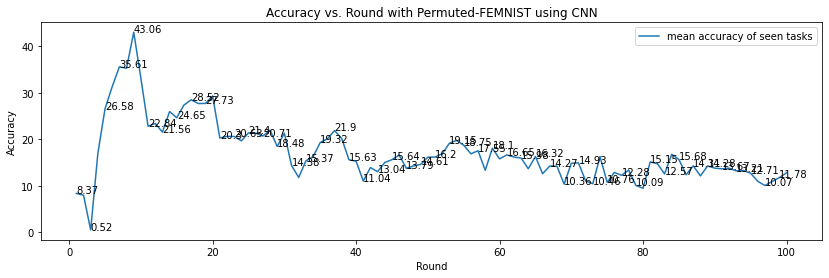

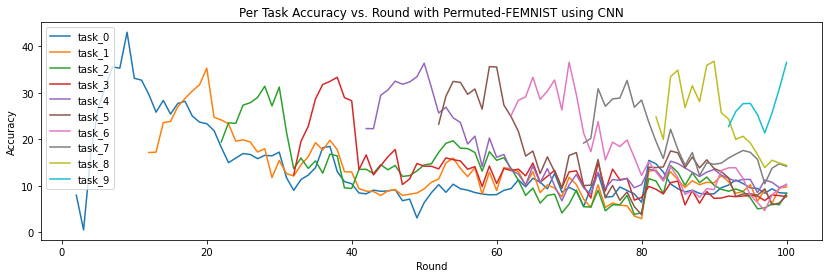

In [ ]:

plot_CL_hist(metrics_centralized, "Accuracy vs. Round with Permuted-FEMNIST using CNN", num_task=10)

In [ ]:
def print_CL_hist(hist: Any, title: str) -> None:
  if not isinstance(hist, Dict): 
    accs = hist.metrics_centralized['all_acc']
    mean_accuracy = hist.metrics_centralized['mean_accuracy']
  else:
    accs = hist['all_acc']
    mean_accuracy = hist['mean_accuracy']
  print(accs)
  print(mean_accuracy)

In [ ]:
print_CL_hist(permuted_hist_fed_none)

#### 5-Task 10-class Comparisions

##### with KD

In [ ]:
permuted_hist_fed_fta_kd = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_fta_kd.json', permuted_hist_fed_fta_kd)

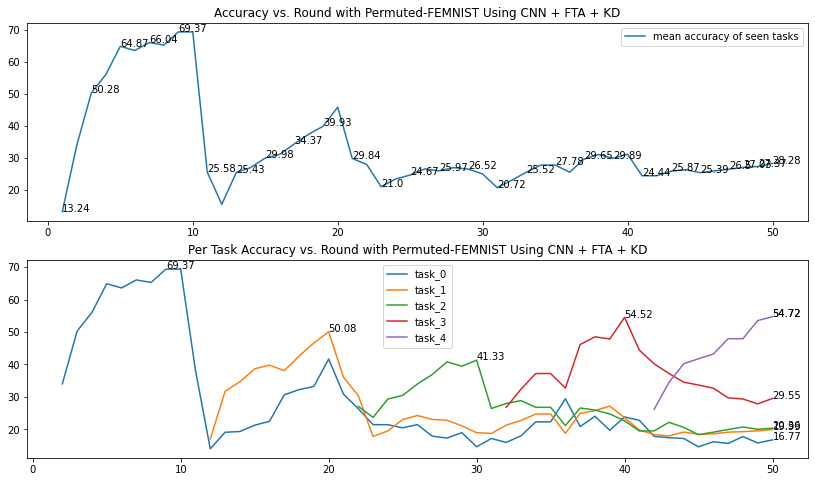

In [ ]:
permuted_hist_fed_fta_kd = load_hist_object("permuted_hist_fed_fta_kd.json")
plot_CL_hist(permuted_hist_fed_fta_kd, "Accuracy vs. Round with Permuted-FEMNIST Using CNN + FTA + KD")

In [ ]:
permuted_hist_fed_fta_adpt_kd = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_fta_adpt_kd.json', permuted_hist_fed_fta_adpt_kd)

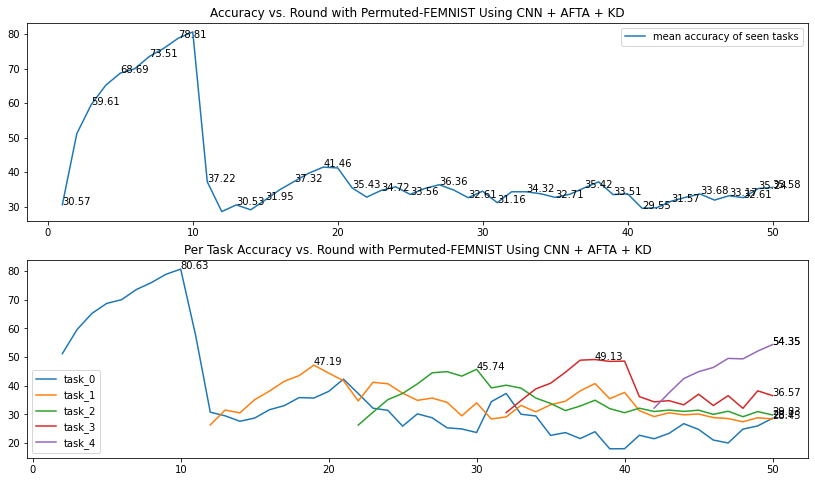

In [ ]:
permuted_hist_fed_fta_adpt_kd = load_hist_object("permuted_hist_fed_fta_adpt_kd.json")
plot_CL_hist(permuted_hist_fed_fta_adpt_kd, "Accuracy vs. Round with Permuted-FEMNIST Using CNN + AFTA + KD")

In [ ]:
permuted_hist_fed_none_kd = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_none_kd.json', permuted_hist_fed_none_kd)

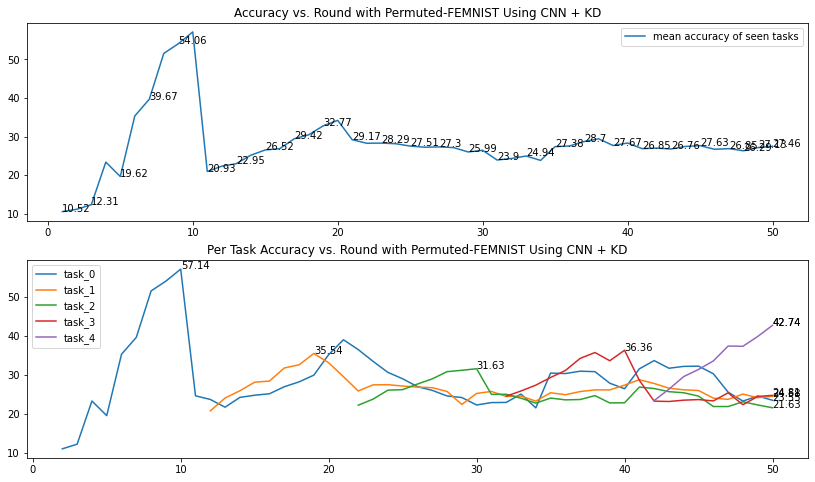

In [ ]:
permuted_hist_fed_none_kd = load_hist_object("permuted_hist_fed_none_kd.json")
plot_CL_hist(permuted_hist_fed_none_kd, "Accuracy vs. Round with Permuted-FEMNIST Using CNN + KD")

##### with EWC

In [ ]:
permuted_hist_fed_fta_ewc = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_fta_ewc.json', permuted_hist_fed_fta_ewc)

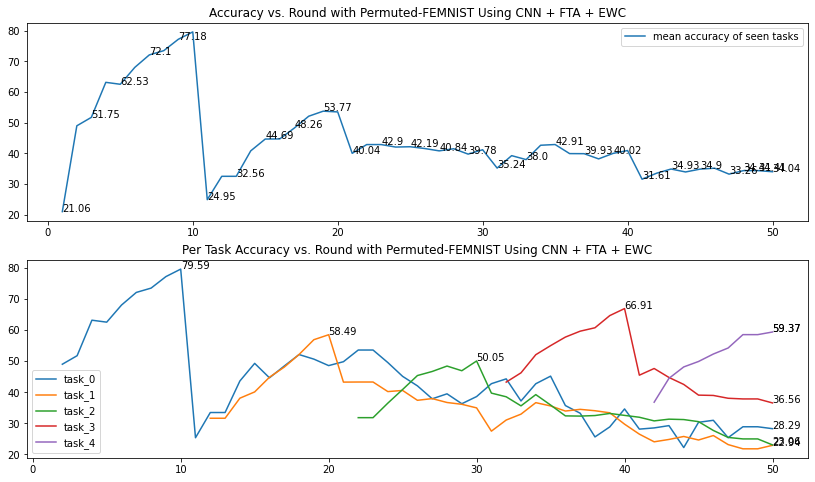

In [ ]:
permuted_hist_fed_fta_ewc = load_hist_object("permuted_hist_fed_fta_ewc.json")
plot_CL_hist(permuted_hist_fed_fta_ewc, "Accuracy vs. Round with Permuted-FEMNIST Using CNN + FTA + EWC")

In [ ]:
permuted_hist_fed_fta_adpt_ewc = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_fta_adpt_ewc2.json', permuted_hist_fed_fta_adpt_ewc)

avg acc of last three rounds 34.42 [32.61652957 35.19682726 35.43282413]
task 0 max accuracy 80.9 final accuracy 28.56 forgetting 52.34
task 1 max accuracy 47.68 final accuracy 28.74 forgetting 18.94
task 2 max accuracy 44.88 final accuracy 29.62 forgetting 15.260000000000002
task 3 max accuracy 49.84 final accuracy 35.65 forgetting 14.190000000000005
task 4 max accuracy 54.59 final accuracy 54.59 forgetting 0.0


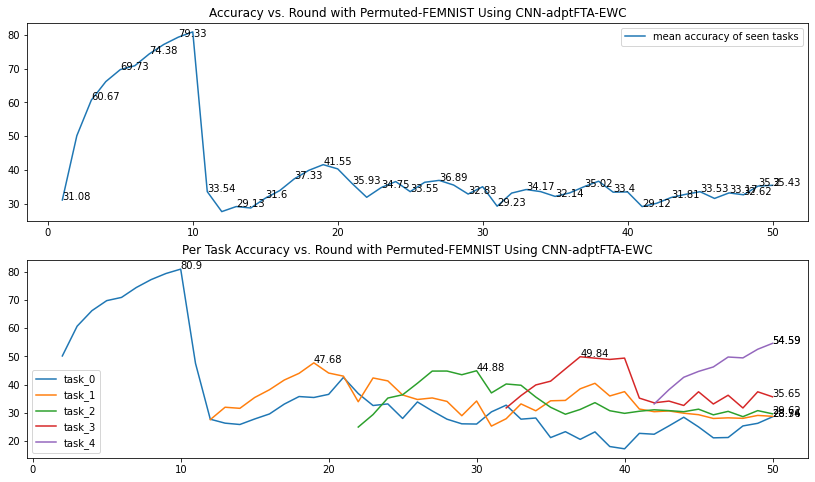

In [ ]:
# This history, permuted_hist_fed_FTA_adpt_ewc2.json, is accidentally lost
permuted_hist_fed_fta_adpt_ewc = load_hist_object("permuted_hist_fed_FTA_adpt_ewc2.json")
plot_CL_hist(permuted_hist_fed_fta_adpt_ewc, "Accuracy vs. Round with Permuted-FEMNIST Using CNN + AFTA + EWC")

In [ ]:
permuted_hist_fed_none_ewc = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_none_ewc.json', permuted_hist_fed_none_ewc)

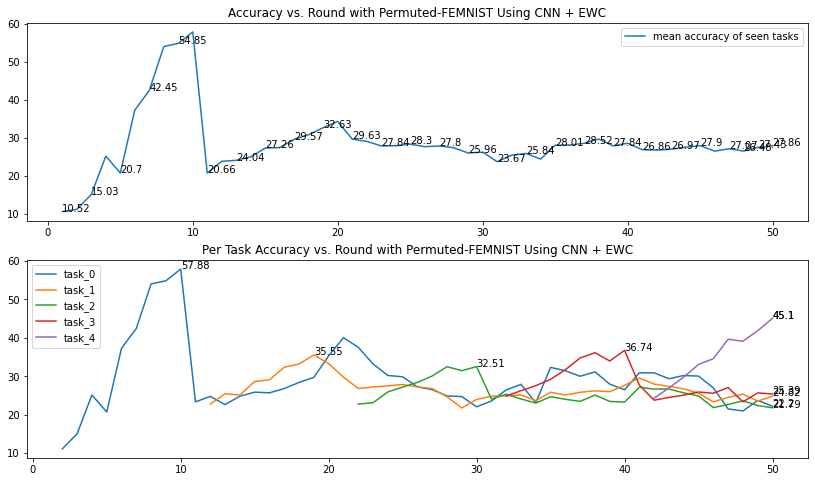

In [ ]:
permuted_hist_fed_none_ewc = load_hist_object("permuted_hist_fed_none_ewc.json")
plot_CL_hist(permuted_hist_fed_none_ewc, "Accuracy vs. Round with Permuted-FEMNIST Using CNN + EWC")

##### without CL technique

In [ ]:
permuted_hist_fed_fta = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_fta.json', permuted_hist_fed_fta)

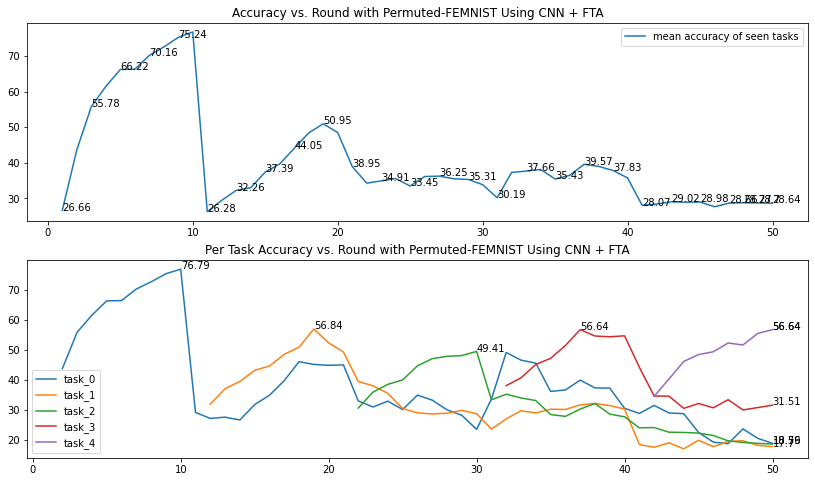

In [ ]:
permuted_hist_fed_fta = load_hist_object("permuted_hist_fed_fta.json")
plot_CL_hist(permuted_hist_fed_fta, "Accuracy vs. Round with Permuted-FEMNIST Using CNN + FTA")

In [ ]:
permuted_hist_fed_fta_adpt = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_fta_adpt.json', permuted_hist_fed_fta_adpt)

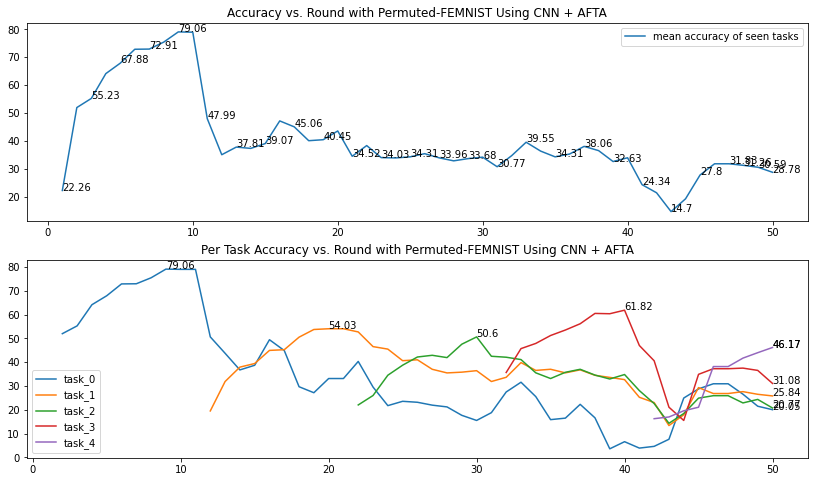

In [ ]:
permuted_hist_fed_fta_adpt = load_hist_object("permuted_hist_fed_fta_adpt.json")
plot_CL_hist(permuted_hist_fed_fta_adpt, "Accuracy vs. Round with Permuted-FEMNIST Using CNN + AFTA")

In [ ]:
permuted_hist_fed_none = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_none.json', permuted_hist_fed_none)

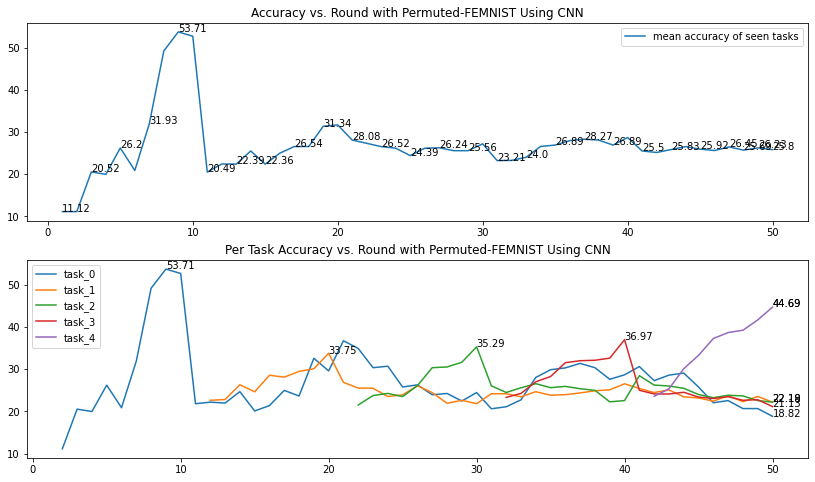

In [ ]:
permuted_hist_fed_none = load_hist_object("permuted_hist_fed_none.json")
plot_CL_hist(permuted_hist_fed_none, "Accuracy vs. Round with Permuted-FEMNIST Using CNN")

5 task 100 epoch CNN

In [ ]:
permuted_hist_fed_moreround = fl.simulation.start_simulation(
    client_fn=permuted_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=100),
    strategy=permuted_strategy,
)

save_hist_object('permuted_hist_fed_moreround.json', permuted_hist_fed_moreround)

In [ ]:
plot_CL_hist(permuted_hist_fed_moreround, "Permuted Accuracy vs. Round with Federated Partition using CNN (20 round per task)")

## SplitFEMINIST

### pre-processing

In [ ]:
home_dir = Path("/content")
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

TASK_NUM = 5
split_partitions = []
for task_idx in range(TASK_NUM):
  taskid = 'task' + str(task_idx)
  split_partition = dataset_dir / 'client_data_mappings' / taskid
  split_partitions.append(split_partition)
print(split_partitions)    

[PosixPath('/content/femnist/client_data_mappings/task0'), PosixPath('/content/femnist/client_data_mappings/task1'), PosixPath('/content/femnist/client_data_mappings/task2'), PosixPath('/content/femnist/client_data_mappings/task3'), PosixPath('/content/femnist/client_data_mappings/task4')]


In [ ]:
# centralized_mapping
centralized_split_partitions = []
for name in ["train", "test", "val"]:
    filename = name + ".csv"
    partition = pd.read_csv(centralized_mapping / filename)

    for task_idx in range(TASK_NUM):
        split_labels = [task_idx * 2, task_idx * 2 + 1]
        taskid = 'centralized_task' + str(task_idx)
        split_partition = dataset_dir / 'client_data_mappings'/ taskid / str(0)
        centralized_split_partitions.append(split_partition)

        folder_path = split_partition
        folder_path.mkdir(parents=True, exist_ok=True)

        splited = partition[partition["label"].isin(split_labels)]

        splited["label"] = splited["label"] % 2

        dir_path: Path = folder_path / filename
        splited.to_csv(dir_path, index=False)
centralized_split_partitions = centralized_split_partitions[:5]
print(centralized_split_partitions)

<ipython-input-26-bb84e6bf0668>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  splited["label"] = splited["label"] % 2
<ipython-input-26-bb84e6bf0668>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  splited["label"] = splited["label"] % 2
<ipython-input-26-bb84e6bf0668>:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[PosixPath('/content/femnist/client_data_mappings/centralized_task0/0'), PosixPath('/content/femnist/client_data_mappings/centralized_task1/0'), PosixPath('/content/femnist/client_data_mappings/centralized_task2/0'), PosixPath('/content/femnist/client_data_mappings/centralized_task3/0'), PosixPath('/content/femnist/client_data_mappings/centralized_task4/0')]


In [ ]:
import pandas as pd
from tqdm import tqdm

def split_to_five(original_partition):
  for client in tqdm(range(3229)):
      fed_par_dir : Path = original_partition / str(client)
      partition_train = pd.read_csv(fed_par_dir /  "train.csv")
      partition_test = pd.read_csv(fed_par_dir /  "train.csv")

      for task_idx in range(TASK_NUM):
          split_labels = [task_idx * 2, task_idx * 2 + 1]
          # print(task_idx, split_labels)
          split_partition = split_partitions[task_idx]
          folder_path = split_partition /  str(client)
          folder_path.mkdir(parents=True, exist_ok=True)

          splited_train = partition_train[partition_train["label"].isin(split_labels)]
          splited_test = partition_test[partition_test["label"].isin(split_labels)]

          splited_train["label"] = splited_train["label"] % 2
          splited_test["label"] = splited_test["label"] % 2

          train_path: Path = folder_path / "train.csv"
          test_path: Path = folder_path / "test.csv"

          splited_train.to_csv(train_path, index=False)
          splited_test.to_csv(test_path, index=False)

split_to_five(federated_partition)

流式输出内容被截断，只能显示最后 5000 行内容。
<ipython-input-27-fb1b5f3674f2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  splited_test["label"] = splited_test["label"] % 2
<ipython-input-27-fb1b5f3674f2>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  splited_train["label"] = splited_train["label"] % 2
<ipython-input-27-fb1b5f3674f2>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

### Modifications

In [ ]:
from client_utils import *

def get_split_evaluation_function(
    data_dir: Path,
    centralized_mapping: Path,
    device: str,
    batch_size: int,
    num_workers: int,
    model_generator: Callable[[], Module],
    criterion: Module,
) -> Callable[[int, NDArrays, Dict[str, Any]], Tuple[float, Dict[str, Scalar]]]:
    """Wrapper function for the external federated evaluation function.
    It provides the external federated evaluation function with some
    parameters for the dataloader, the model generator function, and
    the criterion used in the evaluation.

    Args:
        data_dir (Path): path to the dataset folder.
        centralized_mapping (Path): path to the mapping .csv file chosen.
        device (str):  device name onto which perform the computation.
        batch_size (int): batch size of the test set to use.
        num_workers (int): correspond to `num_workers` param in the Dataloader object.
        model_generator (Callable[[], Module]):  model generator function.
        criterion (Module): PyTorch Module containing the criterion for evaluating the model.

    Returns:
        Callable[[int, NDArrays, Dict[str, Any]], Tuple[float, Dict[str, Scalar]]]: external federated evaluation function.
    """

    full_file: Path = centralized_mapping
    datasets = [load_FEMNIST_dataset(data_dir, mapping, "val") for mapping in centralized_split_partitions]

    def federated_evaluation_function(
        server_round: int,
        parameters: NDArrays,
        fed_eval_config: Dict[
            str, Any
        ],  # mandatory argument, even if it's not being used
    ) -> Tuple[float, Dict[str, Scalar]]:
        """Evaluation function external to the federation.
        It uses the centralized val set for sake of simplicity.

        Args:
            server_round (int): current federated round.
            parameters (NDArrays): current model parameters.
            fed_eval_config (Dict[str, Any]): mandatory argument in Flower, can contain some configuration info

        Returns:
            Tuple[float, Dict[str, Scalar]]: evaluation results
        """
        net: Module = set_model_parameters(model_generator(), parameters)
        net.to(device)

        losses, accs = [], []
        task_num = TASK_NUM
        task_id = ((server_round - 1) // 10) % task_num
        n_task = task_id + 1
        
        for dataset in datasets[:n_task]:
            valid_loader = DataLoader(
                dataset=dataset,
                batch_size=batch_size,
                shuffle=False,
                num_workers=num_workers,
                drop_last=False,
            )
            
            loss, acc = test_FEMNIST(
                net=net,
                test_loader=valid_loader,
                device=device,
                criterion=criterion,
            )
            losses.append(loss)
            accs.append(acc)
        print(server_round, accs)
        return np.mean(losses), {"mean_accuracy": np.mean(accs), "all_loss": losses, "all_acc":accs}

    return federated_evaluation_function

In [ ]:
# client.py
from client import *

class SplitFlowerRayClient(FlowerRayClient):
    def __init__(
        self,
        cid: int,
        data_dir: Path,
        partition_dir: Path,
        model_generator: Callable[[], Module],
    ) -> None:
        super(SplitFlowerRayClient, self).__init__(cid, data_dir, partition_dir, model_generator)

    def _create_data_loader(self, config: Dict[str, Scalar], name: str) -> DataLoader:
        """Creates the data loader using the specified config parameters

        Args:
            config (Dict[str, Scalar]): Dictionary containing dataloader and dataset parameters
            mode (str): Load the training or testing set for the client

        Returns:
            DataLoader: A pytorch dataloader iterable for training/testing
        """
        # print(config["task"])
        batch_size = int(config["batch_size"])
        num_workers = int(config["num_workers"])
        dataset = self._load_dataset(name, config["task"])

        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=False,
            num_workers=num_workers,
            drop_last=(name == "train"),
        )

    def _load_dataset(self, name, task) -> Dataset:
        full_file: Path = split_partitions[task] / str(self.cid)
        return load_FEMNIST_dataset(
            data_dir=self.data_dir, mapping=full_file, name=name
        )

    def _train(
        self, net: Module, train_loader: DataLoader, config: Dict[str, Scalar]
    ) -> float:

        # Change here for different CL techniques 
        # train_FEMNIST
        # train_FEMNIST_kd
        # train_FEMNIST_ewc
        return train_FEMNIST_kd(
            net=net,
            train_loader=train_loader,
            epochs=int(config["epochs"]),
            device=self.device,
            optimizer=torch.optim.AdamW(
                net.parameters(),
                lr=float(config["client_learning_rate"]),
                weight_decay=float(config["weight_decay"]),
            ),
            criterion=torch.nn.CrossEntropyLoss(),
        )

    def _test(
        self, net, test_loader: DataLoader, config: Dict[str, Scalar]
    ) -> Tuple[float, float]:
        return test_FEMNIST(
            net=net,
            test_loader=test_loader,
            device=self.device,
            criterion=torch.nn.CrossEntropyLoss(),
        )

def get_split_client_generator(
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Optional[Callable[[int], int]] = None,
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        data_dir (Path): path to the dataset folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], FlowerRayClient]: client instance.
    """

    def client_fn(cid: str) -> FlowerRayClient:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns:
            FlowerRayClient: client instance.
        """
        return SplitFlowerRayClient(
            cid=mapping_fn(int(cid)) if mapping_fn is not None else int(cid),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
        )

    return client_fn

### Experiments

#### configs

In [ ]:
# Select sparsity strategy for the network
network_list = ["FTA_CNN", "FTA_Adap_CNN", "PP_CNN", "CNN", "FTA_MLP", "MLP"]
network = network_list[1]

torch.manual_seed(Seeds.DEFAULT)
if network == "FTA_CNN":
  network_generator_fta = get_network_generator_cnn_fta()
elif network == "FTA_Adap_CNN":
  network_generator_fta = get_network_generator_cnn_fta_adap()
elif network == "PP_CNN":
  network_generator_fta = get_network_generator_cnn_pp()
elif network == "CNN":
  torch.manual_seed(Seeds.DEFAULT)
  network_generator_fta = get_network_generator_cnn()
elif network == "FTA_MLP":
  network_generator_fta = get_network_generator_mlp_fta()
elif network == "MLP":
  network_generator_fta = get_network_generator_mlp()

seed_net_fta = network_generator_fta()
seed_model_fta_params: NDArrays = get_model_parameters(seed_net_fta)

In [ ]:
# Create client generators for both LDA partition and natural partition
# lda_flower_client_generator: Callable[
#     [int], FlowerRayClient
# ] = get_split_client_generator(network_generator_fta, data_dir, lda_partition) # type: ignore

split_federated_flower_client_generator: Callable[
    [int], FlowerRayClient
] = get_split_client_generator(network_generator_fta, data_dir, federated_partition) # type: ignore

In [ ]:
def get_split_fit_config_fn() -> Callable[[int], Dict[str, str]]:
    """Return a function which returns training configurations."""

    def fit_config(server_round: int) -> Dict[str, str]:
        """Return a configuration with static batch size and (local) epochs."""
        task_id = ((server_round - 1) // 10) % TASK_NUM
        config = {
            "epochs": 10,
            "batch_size": 16,
            "client_learning_rate": 0.0005, # For FTA, important to have a small learning rate (e.g. 5e-4 instead of 1e-2)
            "weight_decay": 0.001,
            "num_workers": 2,
            "task": task_id
        }
        return config

    return fit_config

def get_split_eval_config_fn() -> Callable[[int], Dict[str, str]]:
    """Return a function which returns training configurations."""

    def eval_config(server_round: int) -> Dict[str, str]:
        """Return a configuration with static batch size and (local) epochs."""
        task_id = ((server_round - 1) // 10) % TASK_NUM
        config = {
            "batch_size": 64,
            "num_workers": 2,
            "task": task_id
        }
        return config

    return eval_config

In [ ]:
num_total_clients = 3229
num_clients_per_round: int = 5
num_evaluate_clients: int = 0
fraction_fit: float = float(num_clients_per_round) / num_total_clients
fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients

accept_failures = False
server_learning_rate = 1.0
min_fit_clients = 2
min_evaluate_clients = 0
min_available_clients = 2
initial_parameters: Parameters = ndarrays_to_parameters(seed_model_fta_params)
client_resources = {
    "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0, # maximum amount of resources that a client can take
}

test_config: Dict[str, Any] = {
    "batch_size": 64,
    "num_workers": 2,
}

split_evaluation_function = get_split_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=test_config["batch_size"],
    num_workers=test_config["num_workers"],
    model_generator=network_generator_fta,
    criterion=nn.CrossEntropyLoss()
)

split_strategy = FedAvg(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_evaluate_clients=min_evaluate_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=get_split_fit_config_fn(), # this line is different
    on_evaluate_config_fn=get_split_eval_config_fn(), # this line is different
    evaluate_fn=split_evaluation_function, # this line is different
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
    server_learning_rate=server_learning_rate,
)

#### Class-IL Comparisons (archived, this set-up is too hard for the model)

In [ ]:
split_hist_fed_none = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)
save_hist_object('split_hist_fed_none.json', split_hist_fed_none)

In [ ]:
split_hist_fed_none = load_hist_object("split_hist_fed_none.json")
plot_CL_hist(split_hist_fed_none, "Split Accuracy vs. Round with Federated Partition using CNN")

In [ ]:
split_hist_fed_fta = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_fta.json', split_hist_fed_fta)

In [ ]:
split_hist_fed_fta = load_hist_object("split_hist_fed_fta.json")
plot_CL_hist(split_hist_fed_fta, "Split Accuracy vs. Round with Federated Partition using CNN-FTA")

In [ ]:
split_hist_fed_fta_adpt = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_fta_adpt.json', split_hist_fed_fta_adpt)

In [ ]:
split_hist_fed_fta_adpt = load_hist_object("split_hist_fed_fta_adpt.json")
plot_CL_hist(split_hist_fed_fta_adpt, "Split Accuracy vs. Round with Federated Partition using CNN-adptFTA")

#### Domain-IL Comparisons

##### with KD

In [ ]:
split_hist_fed_fta_kd = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_fta_kd.json', split_hist_fed_fta_kd)

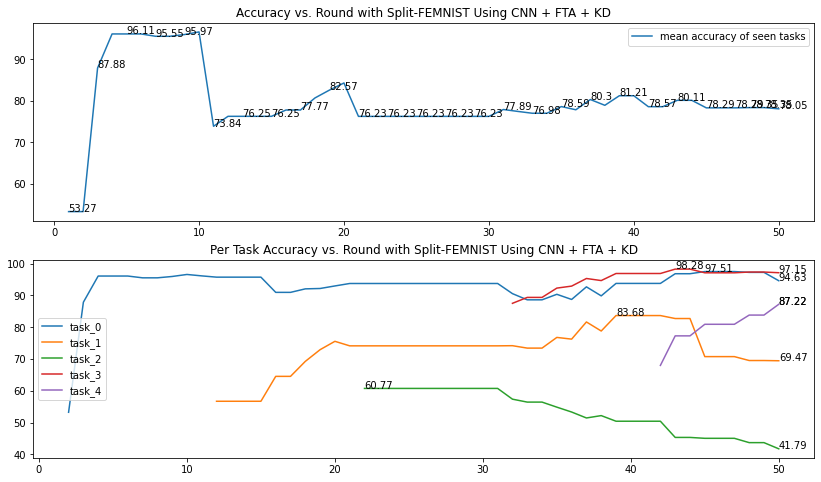

In [ ]:
split_hist_fed_fta_kd = load_hist_object("split_hist_fed_fta_kd.json")
plot_CL_hist(split_hist_fed_fta_kd, "Accuracy vs. Round with Split-FEMNIST Using CNN + FTA + KD")

In [ ]:
split_hist_fed_fta_adpt_kd = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_fta_adpt_kd.json', split_hist_fed_fta_adpt_kd)

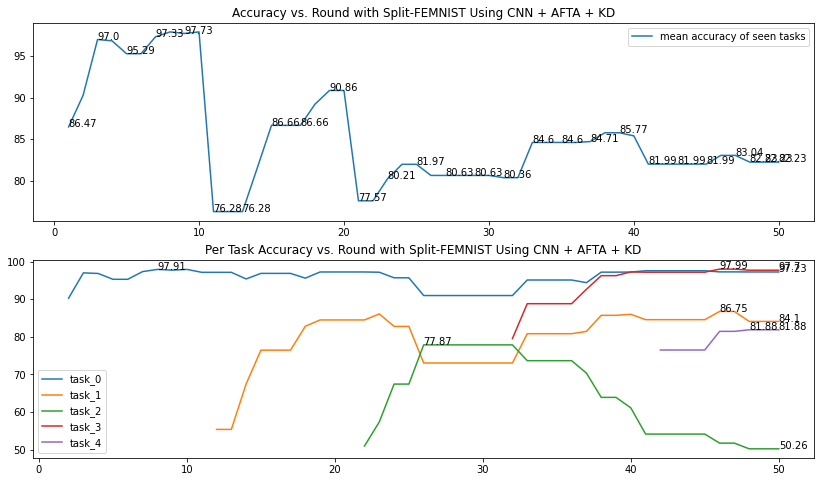

In [ ]:
split_hist_fed_fta_adpt_kd = load_hist_object("split_hist_fed_fta_adpt_kd.json")
plot_CL_hist(split_hist_fed_fta_adpt_kd, "Accuracy vs. Round with Split-FEMNIST Using CNN + AFTA + KD")

In [ ]:
split_hist_fed_none_kd = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_none_kd.json', split_hist_fed_none_kd)

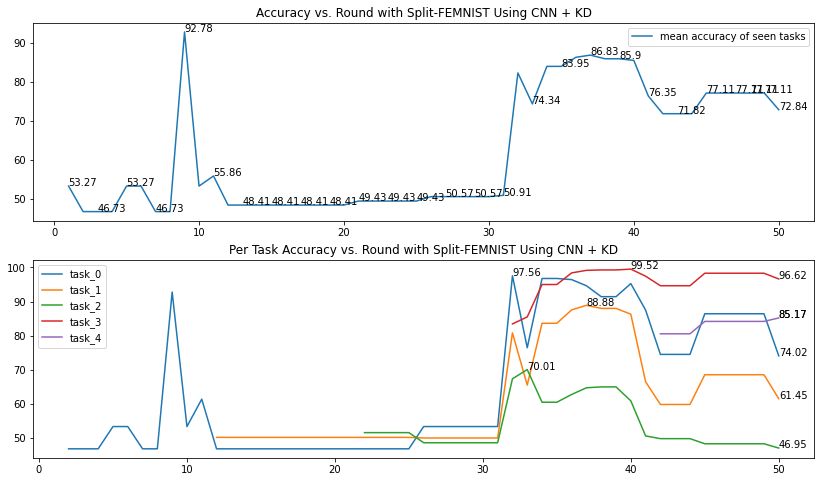

In [ ]:
split_hist_fed_none_kd = load_hist_object("split_hist_fed_none_kd.json")
plot_CL_hist(split_hist_fed_none_kd, "Accuracy vs. Round with Split-FEMNIST Using CNN + KD")

##### with EWC

In [ ]:
split_hist_fed_fta_ewc = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_fta_ewc.json', split_hist_fed_fta_ewc)

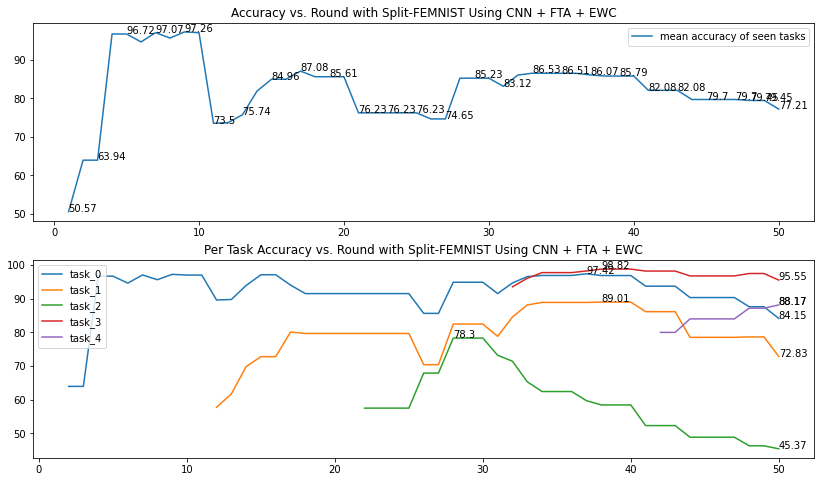

In [ ]:
split_hist_fed_fta_ewc = load_hist_object("split_hist_fed_fta_ewc.json")
plot_CL_hist(split_hist_fed_fta_ewc, "Accuracy vs. Round with Split-FEMNIST Using CNN + FTA + EWC")

In [ ]:
split_hist_fed_fta_adpt_ewc = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_fta_adpt_ewc.json', split_hist_fed_fta_adpt_ewc)

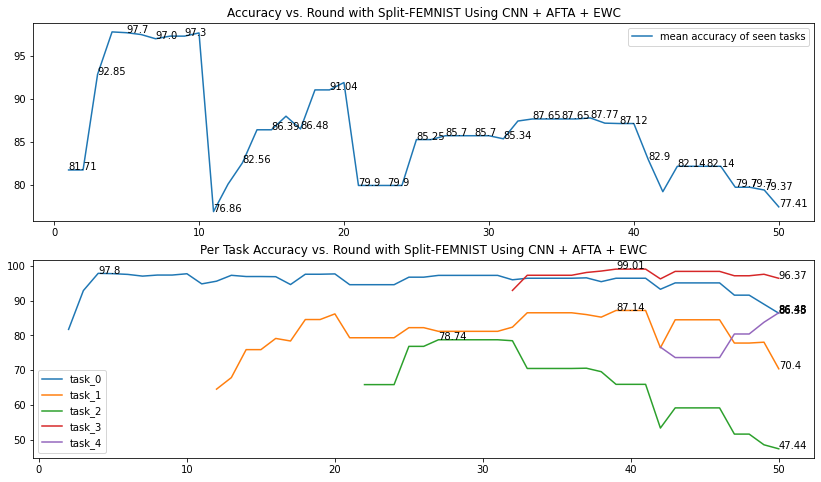

In [ ]:
split_hist_fed_fta_adpt_ewc = load_hist_object("split_hist_fed_fta_adpt_ewc.json")
plot_CL_hist(split_hist_fed_fta_adpt_ewc, "Accuracy vs. Round with Split-FEMNIST Using CNN + AFTA + EWC")

In [ ]:
split_hist_fed_none_ewc = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_none_ewc.json', split_hist_fed_none_ewc)

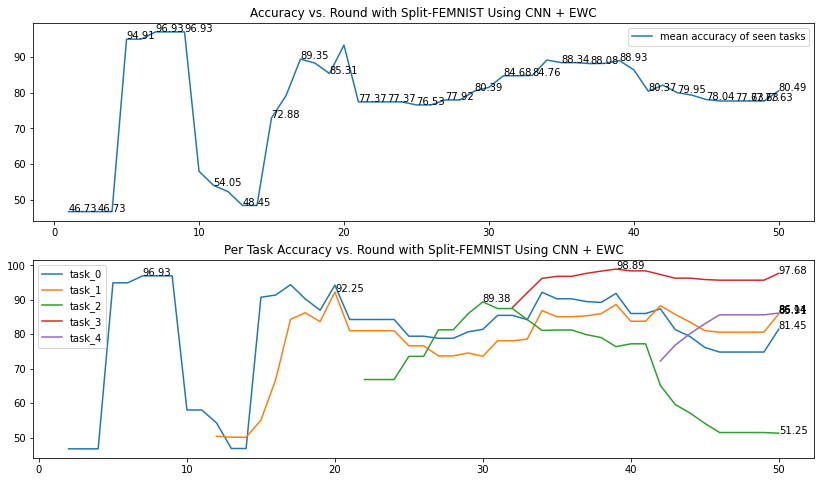

In [ ]:
split_hist_fed_none_ewc = load_hist_object("split_hist_fed_none_ewc.json")
plot_CL_hist(split_hist_fed_none_ewc, "Accuracy vs. Round with Split-FEMNIST Using CNN + EWC")

##### without CL techniques

In [ ]:
split_hist_fed_none = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_none_kd.json', split_hist_fed_none)

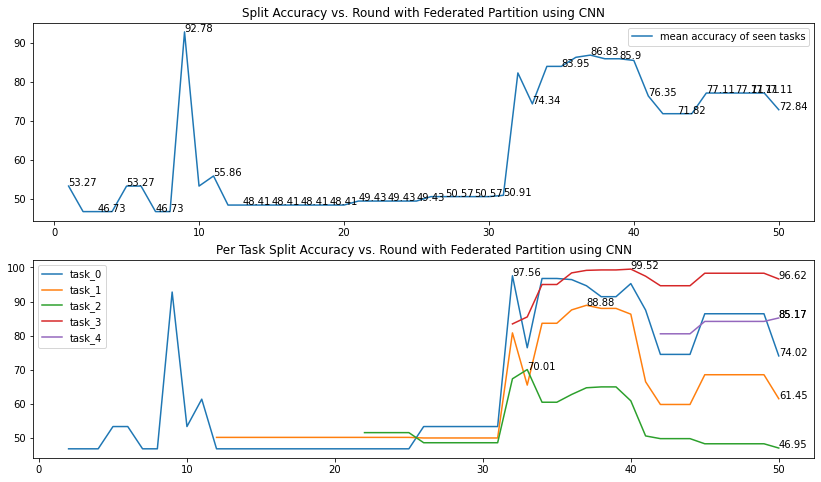

In [ ]:
split_hist_fed_none = load_hist_object("split_hist_fed_none_kd.json")
plot_CL_hist(split_hist_fed_none, "Split Accuracy vs. Round with Federated Partition using CNN")

In [ ]:
split_hist_fed_fta = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_fta_kd.json', split_hist_fed_fta)

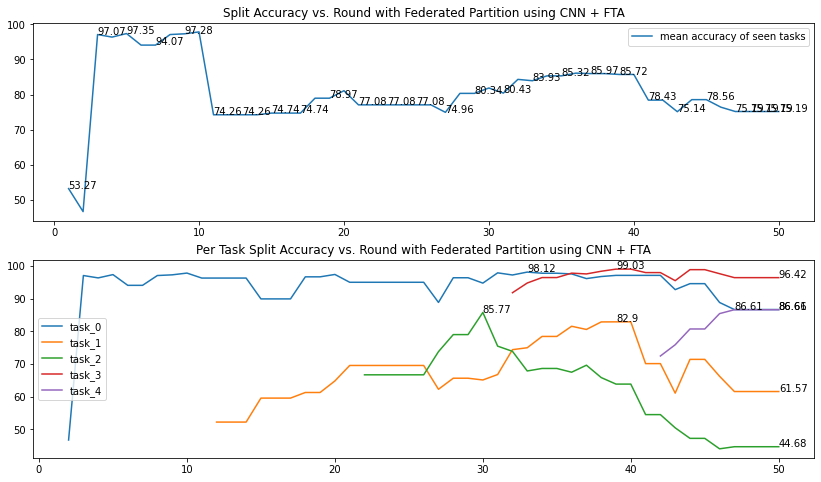

In [ ]:
split_hist_fed_fta = load_hist_object("split_hist_fed_fta.json")
plot_CL_hist(split_hist_fed_fta, "Split Accuracy vs. Round with Federated Partition using CNN + FTA")

In [ ]:
split_hist_fed_fta_adpt = fl.simulation.start_simulation(
    client_fn=split_federated_flower_client_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    config=ServerConfig(num_rounds=50),
    strategy=split_strategy,
)

save_hist_object('split_hist_fed_fta_adpt.json', split_hist_fed_fta_adpt)

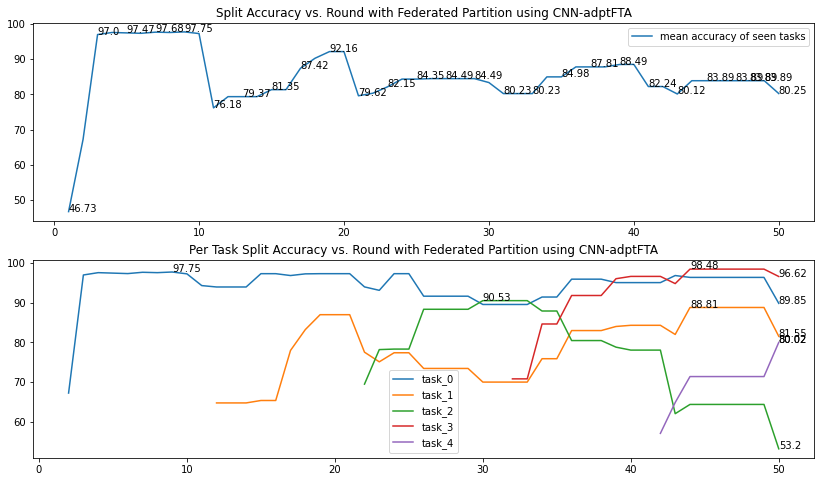

In [ ]:
split_hist_fed_fta_adpt = load_hist_object("split_hist_fed_fta_adpt.json")
plot_CL_hist(split_hist_fed_fta_adpt, "Split Accuracy vs. Round with Federated Partition using CNN-adptFTA")